### Unidad 1: Taller de resolución de problemas de clasificación automática

<h1> Notebook 2 - Logistic Regression from Scratch in Python</h1>

Tutorial realizado por Nick Becker (NVIDIA): https://beckernick.github.io/logistic-regression-from-scratch/

In this post, I'm going to walk through implementig basic binary logistic regression from scratch. Logistic regression is a generalized linear model that we can use to model or predict categorical outcome variables. We might use logistic regression to predict whether someone will be denied or approved for a loan, but probably not to predict the value of someone's house.

So, how does it work? In logistic regression, we're essentially trying to find the weights that maximize the likelihood of producing our given data. Maximum Likelihood Estimation is a well covered topic in statistics courses (my Intro to Statistics professor from sophomore year of college has a straightforward, high-level description [here](http://www2.stat.duke.edu/~banks/111-lectures.dir/lect10.pdf)), and it is extremely useful.

Since this maximizing the likelihood is an iterative process, I'll solve the optimization problem with gradient descent. Before I do that, though, I need some data.

# Generating Data
Like in my post on [building neural networks from scratch](https://beckernick.github.io/neural-network-scratch/), I'm going to use simulated data. I can easily simulate separable data by sampling from a multivariate normal distribution.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(12)
num_observations = 5000

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))

#Valor obtenido para cada observacion
print(simulated_separableish_features)
#Categoria real de cada observacion
print(simulated_labels)

[[-0.2015173  -0.6833582 ]
 [ 0.37451947 -0.8280822 ]
 [-0.16189468 -1.2471066 ]
 ...
 [ 2.3255963   4.181329  ]
 [ 0.24707289  4.2294044 ]
 [ 1.7190224   4.8253503 ]]
[0. 0. 0. ... 1. 1. 1.]


 <div style="color:red">
    COMENTARIOS:
 <li>
     <ul>Los datos están generados de manera aleatoria siguiendo una distribución normal.</ul>
    <ul>Los datos tienen 2 caractéristicas x1 y x2.</ul>
    <ul> 2 variables: una para las caracteristicas y una para los labels.</ul>
    <ul> numpy.random.multivariate_normal(mean, cov,[ size, check_valid, tol]) </ul>
    </li>
 </div> 

Let's see how it looks.

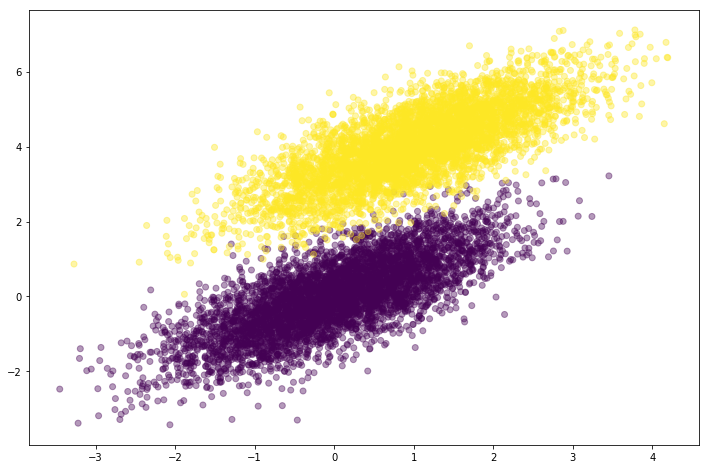

In [20]:
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)

 <div style="color:red">
    <p> Amarillo representa x2, morado representa x1 </p>
 </div> 

# Picking a Link Function
Generalized linear models usually tranform a linear model of the predictors by using a [link function](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function). In logistic regression, the link function is the [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function). We can implement this really easily.

In [27]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

# Maximizing the Likelihood

To maximize the likelihood, I need a way to compute the likelihood and the gradient of the likelihood. Fortunately, the likelihood (for binary classification) can be reduced to a fairly intuitive form by switching to the log-likelihood. We're able to do this without affecting the weights parameter estimation because log transformation are [monotonic](https://en.wikipedia.org/wiki/Monotonic_function).

For anyone interested in the derivations of the functions I'm using, check out Section 4.4.1 of Hastie, Tibsharani, and Friedman's [Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/). For those less mathematically inclined, Carlos Guestrin (Univesity of Washington) details one possible derivation of the log-likelihood in a series of short lectures on [Coursera](https://www.coursera.org/learn/ml-classification/lecture/1ZeTC/very-optional-expressing-the-log-likelihood) using indicator functions.

## Calculating the Log-Likelihood

The log-likelihood can be viewed as as sum over all the training data. Mathematically,

$$\begin{equation}
ll = \sum_{i=1}^{N}y_{i}\beta ^{T}x_{i} - log(1+e^{\beta^{T}x_{i}})
\end{equation}$$

where $y$ is the target class, $x_{i}$ represents an individual data point, and $\beta$ is the weights vector.

I can easily turn that into a function and take advantage of matrix algebra.

In [28]:
def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum( target*scores - np.log(1 + np.exp(scores)) )
    return ll

## Calculating the Gradient

Now I need an equation for the gradient of the log-likelihood. By taking the derivative of the equation above and reformulating in matrix form, the gradient becomes: 

$$\begin{equation}
\bigtriangledown ll = X^{T}(Y - Predictions)
\end{equation}$$

Again, this is really easy to implement. It's so simple I don't even need to wrap it into a function. The gradient here looks very similar to the output layer gradient in a neural network (see my [post](https://beckernick.github.io/neural-network-scratch/) on neural networks if you're curious).

This shouldn't be too surprising, since a neural network is basically just a series of non-linear link functions applied after linear manipulations of the input data.

# Building the Logistic Regression Function

Finally, I'm ready to build the model function. I'll add in the option to calculate the model with an intercept, since it's a good option to have.

In [58]:
def logistic_regression(features, target, num_steps, learning_rate, add_intercept = False):
    print(features)
    print(target)
    print(num_steps)
    print(learning_rate)
    print(features.T)
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))
        
    weights = np.zeros(features.shape[1])
    
    for step in range(num_steps):
        #primero se calcula la f(x)
        scores = np.dot(features, weights)
        #luego se aplica funcion sismoide
        predictions = sigmoid(scores)

        # Update weights with log likelihood gradient
        output_error_signal = target - predictions
        print("error"+str(output_error_signal))
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient

        # Print log-likelihood every so often
        if step % 10000 == 0:
            print(log_likelihood(features, target, weights))
        
    return weights




Time to do the regression.

In [59]:
weights = logistic_regression(simulated_separableish_features, simulated_labels,
                     num_steps = 50000, learning_rate = 5e-5, add_intercept=True)

[[-0.2015173  -0.6833582 ]
 [ 0.37451947 -0.8280822 ]
 [-0.16189468 -1.2471066 ]
 ...
 [ 2.3255963   4.181329  ]
 [ 0.24707289  4.2294044 ]
 [ 1.7190224   4.8253503 ]]
[0. 0. 0. ... 1. 1. 1.]
50000
5e-05
[[-0.2015173   0.37451947 -0.16189468 ...  2.3255963   0.24707289
   1.7190224 ]
 [-0.6833582  -0.8280822  -1.2471066  ...  4.181329    4.2294044
   4.8253503 ]]
error[-0.5 -0.5 -0.5 ...  0.5  0.5  0.5]
-4346.264779152365
error[-0.40933872 -0.40900526 -0.34438045 ...  0.08482989  0.10468215
  0.06749296]
error[-0.37591152 -0.3714345  -0.30498215 ...  0.07299236  0.08781794
  0.05510826]
error[-0.34680076 -0.33842486 -0.27279263 ...  0.0673614   0.07820953
  0.04865099]
error[-0.32092711 -0.30900918 -0.24551838 ...  0.06440317  0.07181539
  0.04469905]
error[-0.29771243 -0.2826546  -0.22197921 ...  0.06278429  0.06708562
  0.04199743]
error[-0.2767737  -0.25898696 -0.20144114 ...  0.06188672  0.06330393
  0.03998078]
error[-0.25782377 -0.23770623 -0.18339257 ...  0.06138856  0.06010286


error[-0.00230244 -0.00064735 -0.0004522  ...  0.02487439  0.00097428
  0.00169981]
error[-0.00228769 -0.0006422  -0.00044856 ...  0.02482595  0.0009682
  0.00169136]
error[-0.00227308 -0.00063711 -0.00044496 ...  0.02477771  0.00096218
  0.00168299]
error[-0.00225861 -0.00063208 -0.0004414  ...  0.02472968  0.00095621
  0.00167467]
error[-0.00224427 -0.0006271  -0.00043788 ...  0.02468185  0.00095029
  0.00166642]
error[-0.00223006 -0.00062217 -0.0004344  ...  0.02463422  0.00094443
  0.00165823]
error[-0.00221598 -0.00061729 -0.00043096 ...  0.0245868   0.00093862
  0.00165011]
error[-0.00220203 -0.00061247 -0.00042755 ...  0.02453957  0.00093286
  0.00164204]
error[-0.00218821 -0.0006077  -0.00042418 ...  0.02449254  0.00092715
  0.00163404]
error[-0.00217452 -0.00060298 -0.00042085 ...  0.02444571  0.0009215
  0.0016261 ]
error[-0.00216095 -0.00059831 -0.00041755 ...  0.02439907  0.00091589
  0.00161821]
error[-0.0021475  -0.00059369 -0.00041429 ...  0.02435263  0.00091033
  0.0016

error[-5.51025587e-04 -1.10097126e-04 -7.49929975e-05 ...  1.56724857e-02
  2.38836657e-04  5.47902769e-04]
error[-5.49127746e-04 -1.09628674e-04 -7.46686386e-05 ...  1.56540396e-02
  2.38021478e-04  5.46379263e-04]
error[-5.47239127e-04 -1.09162883e-04 -7.43461407e-05 ...  1.56356370e-02
  2.37210208e-04  5.44862026e-04]
error[-5.45359669e-04 -1.08699732e-04 -7.40254906e-05 ...  1.56172778e-02
  2.36402823e-04  5.43351023e-04]
error[-5.43489317e-04 -1.08239204e-04 -7.37066748e-05 ...  1.55989618e-02
  2.35599299e-04  5.41846220e-04]
error[-5.41628011e-04 -1.07781279e-04 -7.33896804e-05 ...  1.55806888e-02
  2.34799612e-04  5.40347582e-04]
error[-5.39775695e-04 -1.07325939e-04 -7.30744941e-05 ...  1.55624588e-02
  2.34003739e-04  5.38855076e-04]
error[-5.37932312e-04 -1.06873165e-04 -7.27611030e-05 ...  1.55442714e-02
  2.33211654e-04  5.37368667e-04]
error[-5.36097806e-04 -1.06422939e-04 -7.24494943e-05 ...  1.55261266e-02
  2.32423336e-04  5.35888323e-04]
error[-5.34272121e-04 -1.059

error[-2.28063953e-04 -3.70607357e-05 -2.47569668e-05 ...  1.14975316e-02
  9.93226580e-05  2.66968075e-04]
error[-2.27511854e-04 -3.69501744e-05 -2.46816949e-05 ...  1.14874888e-02
  9.90827077e-05  2.66436373e-04]
error[-2.26961610e-04 -3.68400474e-05 -2.46067226e-05 ...  1.14774628e-02
  9.88435582e-05  2.65906204e-04]
error[-2.26413213e-04 -3.67303524e-05 -2.45320481e-05 ...  1.14674537e-02
  9.86052062e-05  2.65377562e-04]
error[-2.25866654e-04 -3.66210875e-05 -2.44576702e-05 ...  1.14574613e-02
  9.83676483e-05  2.64850442e-04]
error[-2.25321926e-04 -3.65122505e-05 -2.43835873e-05 ...  1.14474857e-02
  9.81308810e-05  2.64324838e-04]
error[-2.24779021e-04 -3.64038393e-05 -2.43097979e-05 ...  1.14375268e-02
  9.78949010e-05  2.63800744e-04]
error[-2.24237931e-04 -3.62958518e-05 -2.42363006e-05 ...  1.14275845e-02
  9.76597048e-05  2.63278154e-04]
error[-2.23698648e-04 -3.61882860e-05 -2.41630941e-05 ...  1.14176588e-02
  9.74252892e-05  2.62757063e-04]
error[-2.23161164e-04 -3.608

error[-1.17821467e-04 -1.64305982e-05 -1.07977586e-05 ...  9.02329140e-03
  5.13095878e-05  1.54556725e-04]
error[-1.17599681e-04 -1.63925476e-05 -1.07722284e-05 ...  9.01695123e-03
  5.12128066e-05  1.54314514e-04]
error[-1.17378469e-04 -1.63546121e-05 -1.07467764e-05 ...  9.01061940e-03
  5.11162749e-05  1.54072845e-04]
error[-1.17157827e-04 -1.63167912e-05 -1.07214025e-05 ...  9.00429591e-03
  5.10199920e-05  1.53831717e-04]
error[-1.16937756e-04 -1.62790844e-05 -1.06961062e-05 ...  8.99798073e-03
  5.09239570e-05  1.53591128e-04]
error[-1.16718252e-04 -1.62414914e-05 -1.06708873e-05 ...  8.99167385e-03
  5.08281691e-05  1.53351077e-04]
error[-1.16499314e-04 -1.62040117e-05 -1.06457456e-05 ...  8.98537526e-03
  5.07326274e-05  1.53111561e-04]
error[-1.16280939e-04 -1.61666448e-05 -1.06206807e-05 ...  8.97908493e-03
  5.06373313e-05  1.52872580e-04]
error[-1.16063127e-04 -1.61293904e-05 -1.05956923e-05 ...  8.97280285e-03
  5.05422798e-05  1.52634131e-04]
error[-1.15845875e-04 -1.609

error[-6.81532787e-05 -8.38121661e-06 -5.42808209e-06 ...  7.33769641e-03
  2.96234483e-05  9.77975179e-05]
error[-6.80484325e-05 -8.36537464e-06 -5.41759279e-06 ...  7.33337871e-03
  2.95776557e-05  9.76711856e-05]
error[-6.79438063e-05 -8.34957152e-06 -5.40712961e-06 ...  7.32906569e-03
  2.95319591e-05  9.75450843e-05]
error[-6.78393994e-05 -8.33380714e-06 -5.39669249e-06 ...  7.32475733e-03
  2.94863584e-05  9.74192134e-05]
error[-6.77352112e-05 -8.31808138e-06 -5.38628134e-06 ...  7.32045365e-03
  2.94408532e-05  9.72935724e-05]
error[-6.76312411e-05 -8.30239411e-06 -5.37589607e-06 ...  7.31615461e-03
  2.93954433e-05  9.71681607e-05]
error[-6.75274886e-05 -8.28674524e-06 -5.36553662e-06 ...  7.31186023e-03
  2.93501285e-05  9.70429778e-05]
error[-6.74239532e-05 -8.27113462e-06 -5.35520290e-06 ...  7.30757049e-03
  2.93049084e-05  9.69180232e-05]
error[-6.73206341e-05 -8.25556217e-06 -5.34489484e-06 ...  7.30328538e-03
  2.92597829e-05  9.67932962e-05]
error[-6.72175308e-05 -8.240

error[-4.52902789e-05 -5.07345128e-06 -3.24834411e-06 ...  6.26816977e-03
  1.96395817e-05  6.93233920e-05]
error[-4.52301516e-05 -5.06518302e-06 -3.24292690e-06 ...  6.26493450e-03
  1.96133351e-05  6.92456659e-05]
error[-4.51701327e-05 -5.05693218e-06 -3.23752129e-06 ...  6.26170227e-03
  1.95871358e-05  6.91680625e-05]
error[-4.51102218e-05 -5.04869871e-06 -3.23212725e-06 ...  6.25847308e-03
  1.95609838e-05  6.90905814e-05]
error[-4.50504188e-05 -5.04048258e-06 -3.22674476e-06 ...  6.25524692e-03
  1.95348790e-05  6.90132225e-05]
error[-4.49907234e-05 -5.03228372e-06 -3.22137377e-06 ...  6.25202379e-03
  1.95088213e-05  6.89359855e-05]
error[-4.49311353e-05 -5.02410211e-06 -3.21601427e-06 ...  6.24880369e-03
  1.94828104e-05  6.88588701e-05]
error[-4.48716544e-05 -5.01593768e-06 -3.21066622e-06 ...  6.24558661e-03
  1.94568465e-05  6.87818760e-05]
error[-4.48122803e-05 -5.00779041e-06 -3.20532958e-06 ...  6.24237255e-03
  1.94309292e-05  6.87050031e-05]
error[-4.47530128e-05 -4.999

error[-3.13065821e-05 -3.22469414e-06 -2.04257186e-06 ...  5.42488579e-03
  1.35387459e-05  5.07139577e-05]
error[-3.12701280e-05 -3.22008832e-06 -2.03958413e-06 ...  5.42239669e-03
  1.35228534e-05  5.06638471e-05]
error[-3.12337314e-05 -3.21549097e-06 -2.03660198e-06 ...  5.41990965e-03
  1.35069861e-05  5.06138058e-05]
error[-3.11973921e-05 -3.21090209e-06 -2.03362542e-06 ...  5.41742468e-03
  1.34911437e-05  5.05638338e-05]
error[-3.11611100e-05 -3.20632165e-06 -2.03065444e-06 ...  5.41494176e-03
  1.34753264e-05  5.05139309e-05]
error[-3.11248849e-05 -3.20174963e-06 -2.02768901e-06 ...  5.41246090e-03
  1.34595341e-05  5.04640970e-05]
error[-3.10887168e-05 -3.19718602e-06 -2.02472912e-06 ...  5.40998209e-03
  1.34437666e-05  5.04143319e-05]
error[-3.10526056e-05 -3.19263079e-06 -2.02177477e-06 ...  5.40750533e-03
  1.34280241e-05  5.03646357e-05]
error[-3.10165511e-05 -3.18808393e-06 -2.01882594e-06 ...  5.40503063e-03
  1.34123063e-05  5.03150080e-05]
error[-3.09805532e-05 -3.183

error[-2.18271167e-05 -2.07203615e-06 -1.29831362e-06 ...  4.70230584e-03
  9.40952097e-06  3.73188565e-05]
error[-2.18047231e-05 -2.06943044e-06 -1.29664034e-06 ...  4.70038177e-03
  9.39977661e-06  3.72862265e-05]
error[-2.17823604e-05 -2.06682895e-06 -1.29496981e-06 ...  4.69845912e-03
  9.39004579e-06  3.72536363e-05]
error[-2.17600287e-05 -2.06423167e-06 -1.29330203e-06 ...  4.69653788e-03
  9.38032850e-06  3.72210858e-05]
error[-2.17377278e-05 -2.06163858e-06 -1.29163700e-06 ...  4.69461805e-03
  9.37062471e-06  3.71885751e-05]
error[-2.17154578e-05 -2.05904969e-06 -1.28997470e-06 ...  4.69269963e-03
  9.36093439e-06  3.71561040e-05]
error[-2.16932186e-05 -2.05646497e-06 -1.28831514e-06 ...  4.69078261e-03
  9.35125752e-06  3.71236725e-05]
error[-2.16710101e-05 -2.05388443e-06 -1.28665831e-06 ...  4.68886700e-03
  9.34159408e-06  3.70912805e-05]
error[-2.16488322e-05 -2.05130806e-06 -1.28500420e-06 ...  4.68695280e-03
  9.33194405e-06  3.70589280e-05]
error[-2.16266850e-05 -2.048

error[-1.59189215e-05 -1.40734542e-06 -8.73279162e-07 ...  4.14366927e-03
  6.84110737e-06  2.85038452e-05]
error[-1.59042883e-05 -1.40576065e-06 -8.72270739e-07 ...  4.14213527e-03
  6.83475335e-06  2.84814370e-05]
error[-1.58896733e-05 -1.40417816e-06 -8.71263803e-07 ...  4.14060228e-03
  6.82840723e-06  2.84590534e-05]
error[-1.58750763e-05 -1.40259797e-06 -8.70258349e-07 ...  4.13907030e-03
  6.82206900e-06  2.84366942e-05]
error[-1.58604974e-05 -1.40102006e-06 -8.69254376e-07 ...  4.13753933e-03
  6.81573866e-06  2.84143595e-05]
error[-1.58459365e-05 -1.39944443e-06 -8.68251881e-07 ...  4.13600938e-03
  6.80941619e-06  2.83920493e-05]
error[-1.58313937e-05 -1.39787107e-06 -8.67250860e-07 ...  4.13448044e-03
  6.80310158e-06  2.83697634e-05]
error[-1.58168688e-05 -1.39629999e-06 -8.66251312e-07 ...  4.13295251e-03
  6.79679482e-06  2.83475019e-05]
error[-1.58023618e-05 -1.39473117e-06 -8.65253234e-07 ...  4.13142559e-03
  6.79049589e-06  2.83252648e-05]
error[-1.57878728e-05 -1.393

error[-1.18490473e-05 -9.80262503e-07 -6.02628350e-07 ...  3.67734188e-03
  5.07578540e-06  2.21348114e-05]
error[-1.18392131e-05 -9.79266383e-07 -6.02000044e-07 ...  3.67610223e-03
  5.07152514e-06  2.21190521e-05]
error[-1.18293899e-05 -9.78271563e-07 -6.01372573e-07 ...  3.67486333e-03
  5.06726966e-06  2.21033083e-05]
error[-1.18195776e-05 -9.77278039e-07 -6.00745936e-07 ...  3.67362517e-03
  5.06301897e-06  2.20875802e-05]
error[-1.18097764e-05 -9.76285810e-07 -6.00120131e-07 ...  3.67238775e-03
  5.05877304e-06  2.20718676e-05]
error[-1.17999860e-05 -9.75294874e-07 -5.99495156e-07 ...  3.67115108e-03
  5.05453189e-06  2.20561706e-05]
error[-1.17902066e-05 -9.74305229e-07 -5.98871012e-07 ...  3.66991515e-03
  5.05029549e-06  2.20404890e-05]
error[-1.17804380e-05 -9.73316872e-07 -5.98247695e-07 ...  3.66867996e-03
  5.04606384e-06  2.20248230e-05]
error[-1.17706804e-05 -9.72329801e-07 -5.97625206e-07 ...  3.66744551e-03
  5.04183694e-06  2.20091725e-05]
error[-1.17609336e-05 -9.713

error[-9.26628695e-06 -7.25474587e-07 -4.42485416e-07 ...  3.32681622e-03
  3.95805639e-06  1.79213954e-05]
error[-9.25922157e-06 -7.24797593e-07 -4.42061580e-07 ...  3.32577904e-03
  3.95500228e-06  1.79096450e-05]
error[-9.25216343e-06 -7.24121408e-07 -4.41638262e-07 ...  3.32474243e-03
  3.95195132e-06  1.78979053e-05]
error[-9.24511252e-06 -7.23446033e-07 -4.41215461e-07 ...  3.32370639e-03
  3.94890351e-06  1.78861763e-05]
error[-9.23806884e-06 -7.22771467e-07 -4.40793175e-07 ...  3.32267093e-03
  3.94585884e-06  1.78744580e-05]
error[-9.23103237e-06 -7.22097706e-07 -4.40371404e-07 ...  3.32163605e-03
  3.94281731e-06  1.78627504e-05]
error[-9.22400311e-06 -7.21424752e-07 -4.39950147e-07 ...  3.32060174e-03
  3.93977892e-06  1.78510534e-05]
error[-9.21698104e-06 -7.20752602e-07 -4.39529403e-07 ...  3.31956800e-03
  3.93674366e-06  1.78393670e-05]
error[-9.20996616e-06 -7.20081255e-07 -4.39109173e-07 ...  3.31853483e-03
  3.93371153e-06  1.78276913e-05]
error[-9.20295846e-06 -7.194

error[-7.30437002e-06 -5.42229555e-07 -3.28162889e-07 ...  3.01759977e-03
  3.11091330e-06  1.46025850e-05]
error[-7.29923867e-06 -5.41763544e-07 -3.27873284e-07 ...  3.01672771e-03
  3.10870032e-06  1.45937443e-05]
error[-7.29411217e-06 -5.41298046e-07 -3.27584004e-07 ...  3.01585609e-03
  3.10648945e-06  1.45849110e-05]
error[-7.28899051e-06 -5.40833062e-07 -3.27295049e-07 ...  3.01498492e-03
  3.10428067e-06  1.45760852e-05]
error[-7.28387369e-06 -5.40368589e-07 -3.27006419e-07 ...  3.01411420e-03
  3.10207400e-06  1.45672668e-05]
error[-7.27876169e-06 -5.39904629e-07 -3.26718113e-07 ...  3.01324392e-03
  3.09986943e-06  1.45584557e-05]
error[-7.27365451e-06 -5.39441179e-07 -3.26430130e-07 ...  3.01237410e-03
  3.09766695e-06  1.45496521e-05]
error[-7.26855216e-06 -5.38978239e-07 -3.26142472e-07 ...  3.01150471e-03
  3.09546656e-06  1.45408559e-05]
error[-7.26345461e-06 -5.38515809e-07 -3.25855136e-07 ...  3.01063577e-03
  3.09326826e-06  1.45320671e-05]
error[-7.25836187e-06 -5.380

error[-5.83974065e-06 -4.12377332e-07 -2.47734704e-07 ...  2.75156081e-03
  2.47996605e-06  1.20390551e-05]
error[-5.83594250e-06 -4.12049322e-07 -2.47532292e-07 ...  2.75082060e-03
  2.47833185e-06  1.20322937e-05]
error[-5.83214766e-06 -4.11721647e-07 -2.47330091e-07 ...  2.75008075e-03
  2.47669909e-06  1.20255375e-05]
error[-5.82835614e-06 -4.11394306e-07 -2.47128100e-07 ...  2.74934125e-03
  2.47506777e-06  1.20187866e-05]
error[-5.82456793e-06 -4.11067298e-07 -2.46926320e-07 ...  2.74860210e-03
  2.47343789e-06  1.20120410e-05]
error[-5.82078304e-06 -4.10740624e-07 -2.46724749e-07 ...  2.74786331e-03
  2.47180944e-06  1.20053007e-05]
error[-5.81700145e-06 -4.10414283e-07 -2.46523388e-07 ...  2.74712487e-03
  2.47018243e-06  1.19985656e-05]
error[-5.81322316e-06 -4.10088275e-07 -2.46322237e-07 ...  2.74638678e-03
  2.46855685e-06  1.19918357e-05]
error[-5.80944818e-06 -4.09762599e-07 -2.46121294e-07 ...  2.74564905e-03
  2.46693270e-06  1.19851111e-05]
error[-5.80567649e-06 -4.094

error[-4.71563207e-06 -3.17503575e-07 -1.89379009e-07 ...  2.51817247e-03
  1.99685193e-06  1.00079123e-05]
error[-4.71278301e-06 -3.17269053e-07 -1.89235274e-07 ...  2.51754008e-03
  1.99562900e-06  1.00026817e-05]
error[-4.70993627e-06 -3.17034753e-07 -1.89091678e-07 ...  2.51690798e-03
  1.99440707e-06  9.99745485e-06]
error[-4.70709184e-06 -3.16800675e-07 -1.88948221e-07 ...  2.51627616e-03
  1.99318614e-06  9.99223183e-06]
error[-4.70424972e-06 -3.16566819e-07 -1.88804902e-07 ...  2.51564463e-03
  1.99196621e-06  9.98701261e-06]
error[-4.70140991e-06 -3.16333185e-07 -1.88661723e-07 ...  2.51501337e-03
  1.99074728e-06  9.98179717e-06]
error[-4.69857241e-06 -3.16099772e-07 -1.88518681e-07 ...  2.51438240e-03
  1.98952935e-06  9.97658552e-06]
error[-4.69573721e-06 -3.15866580e-07 -1.88375778e-07 ...  2.51375170e-03
  1.98831241e-06  9.97137765e-06]
error[-4.69290431e-06 -3.15633609e-07 -1.88233013e-07 ...  2.51312129e-03
  1.98709647e-06  9.96617356e-06]
error[-4.69007371e-06 -3.154

error[-3.89280798e-06 -2.51156404e-07 -1.48836325e-07 ...  2.32489583e-03
  1.64403999e-06  8.47716614e-06]
error[-3.89060689e-06 -2.50982834e-07 -1.48730606e-07 ...  2.32434712e-03
  1.64309730e-06  8.47301331e-06]
error[-3.88840747e-06 -2.50809419e-07 -1.48624983e-07 ...  2.32379864e-03
  1.64215534e-06  8.46886331e-06]
error[-3.88620972e-06 -2.50636158e-07 -1.48519455e-07 ...  2.32325039e-03
  1.64121410e-06  8.46471613e-06]
error[-3.88401365e-06 -2.50463050e-07 -1.48414023e-07 ...  2.32270237e-03
  1.64027358e-06  8.46057178e-06]
error[-3.88181925e-06 -2.50290096e-07 -1.48308686e-07 ...  2.32215458e-03
  1.63933378e-06  8.45643024e-06]
error[-3.87962652e-06 -2.50117295e-07 -1.48203445e-07 ...  2.32160702e-03
  1.63839471e-06  8.45229153e-06]
error[-3.87743545e-06 -2.49944647e-07 -1.48098299e-07 ...  2.32105968e-03
  1.63745635e-06  8.44815563e-06]
error[-3.87524605e-06 -2.49772153e-07 -1.47993248e-07 ...  2.32051258e-03
  1.63651872e-06  8.44402255e-06]
error[-3.87305832e-06 -2.495

error[-3.24182671e-06 -2.00824242e-07 -1.18267464e-07 ...  2.15363214e-03
  1.36553465e-06  7.23350375e-06]
error[-3.24010642e-06 -2.00694024e-07 -1.18188624e-07 ...  2.15315327e-03
  1.36479952e-06  7.23017336e-06]
error[-3.23838736e-06 -2.00563915e-07 -1.18109851e-07 ...  2.15267459e-03
  1.36406492e-06  7.22684511e-06]
error[-3.23666952e-06 -2.00433914e-07 -1.18031145e-07 ...  2.15219609e-03
  1.36333085e-06  7.22351900e-06]
error[-3.23495292e-06 -2.00304021e-07 -1.17952506e-07 ...  2.15171778e-03
  1.36259731e-06  7.22019501e-06]
error[-3.23323754e-06 -2.00174237e-07 -1.17873934e-07 ...  2.15123967e-03
  1.36186430e-06  7.21687315e-06]
error[-3.23152339e-06 -2.00044560e-07 -1.17795429e-07 ...  2.15076174e-03
  1.36113182e-06  7.21355342e-06]
error[-3.22981046e-06 -1.99914992e-07 -1.17716990e-07 ...  2.15028400e-03
  1.36039987e-06  7.21023582e-06]
error[-3.22809876e-06 -1.99785531e-07 -1.17638618e-07 ...  2.14980645e-03
  1.35966844e-06  7.20692034e-06]
error[-3.22638828e-06 -1.996

error[-2.72806279e-06 -1.62650906e-07 -9.52188519e-08 ...  2.00318725e-03
  1.14621904e-06  6.22720189e-06]
error[-2.72669957e-06 -1.62551614e-07 -9.51590789e-08 ...  2.00276635e-03
  1.14563777e-06  6.22449856e-06]
error[-2.72533726e-06 -1.62452401e-07 -9.50993538e-08 ...  2.00234560e-03
  1.14505689e-06  6.22179688e-06]
error[-2.72397587e-06 -1.62353265e-07 -9.50396767e-08 ...  2.00192500e-03
  1.14447640e-06  6.21909683e-06]
error[-2.72261540e-06 -1.62254208e-07 -9.49800474e-08 ...  2.00150457e-03
  1.14389631e-06  6.21639841e-06]
error[-2.72125585e-06 -1.62155228e-07 -9.49204658e-08 ...  2.00108429e-03
  1.14331662e-06  6.21370162e-06]
error[-2.71989721e-06 -1.62056326e-07 -9.48609321e-08 ...  2.00066417e-03
  1.14273732e-06  6.21100646e-06]
error[-2.71853948e-06 -1.61957501e-07 -9.48014460e-08 ...  2.00024421e-03
  1.14215841e-06  6.20831293e-06]
error[-2.71718268e-06 -1.61858754e-07 -9.47420077e-08 ...  1.99982440e-03
  1.14157989e-06  6.20562103e-06]
error[-2.71582678e-06 -1.617

error[-2.32602957e-06 -1.33867681e-07 -7.79358573e-08 ...  1.87312253e-03
  9.74965146e-07  5.42137254e-06]
error[-2.32493032e-06 -1.33790412e-07 -7.78895887e-08 ...  1.87274915e-03
  9.74497404e-07  5.41914421e-06]
error[-2.32383177e-06 -1.33713200e-07 -7.78433552e-08 ...  1.87237591e-03
  9.74029963e-07  5.41691716e-06]
error[-2.32273393e-06 -1.33636045e-07 -7.77971568e-08 ...  1.87200280e-03
  9.73562823e-07  5.41469139e-06]
error[-2.32163678e-06 -1.33558948e-07 -7.77509935e-08 ...  1.87162982e-03
  9.73095984e-07  5.41246689e-06]
error[-2.32054034e-06 -1.33481908e-07 -7.77048652e-08 ...  1.87125698e-03
  9.72629446e-07  5.41024367e-06]
error[-2.31944459e-06 -1.33404925e-07 -7.76587720e-08 ...  1.87088427e-03
  9.72163208e-07  5.40802172e-06]
error[-2.31834954e-06 -1.33328000e-07 -7.76127137e-08 ...  1.87051169e-03
  9.71697271e-07  5.40580104e-06]
error[-2.31725520e-06 -1.33251131e-07 -7.75666904e-08 ...  1.87013924e-03
  9.71231634e-07  5.40358164e-06]
error[-2.31616155e-06 -1.331

error[-1.98846593e-06 -1.10536888e-07 -6.40010083e-08 ...  1.75309216e-03
  8.31474020e-07  4.72989970e-06]
error[-1.98757666e-06 -1.10476523e-07 -6.39650524e-08 ...  1.75276050e-03
  8.31096421e-07  4.72805795e-06]
error[-1.98668793e-06 -1.10416200e-07 -6.39291223e-08 ...  1.75242895e-03
  8.30719053e-07  4.72621721e-06]
error[-1.98579974e-06 -1.10355920e-07 -6.38932181e-08 ...  1.75209751e-03
  8.30341916e-07  4.72437747e-06]
error[-1.98491208e-06 -1.10295682e-07 -6.38573397e-08 ...  1.75176619e-03
  8.29965009e-07  4.72253872e-06]
error[-1.98402496e-06 -1.10235486e-07 -6.38214871e-08 ...  1.75143497e-03
  8.29588332e-07  4.72070098e-06]
error[-1.98313838e-06 -1.10175333e-07 -6.37856603e-08 ...  1.75110387e-03
  8.29211886e-07  4.71886424e-06]
error[-1.98225233e-06 -1.10115222e-07 -6.37498593e-08 ...  1.75077288e-03
  8.28835669e-07  4.71702850e-06]
error[-1.98136682e-06 -1.10055154e-07 -6.37140840e-08 ...  1.75044201e-03
  8.28459682e-07  4.71519375e-06]
error[-1.98048184e-06 -1.099

error[-1.72269427e-06 -9.27728966e-08 -5.34449896e-08 ...  1.64973582e-03
  7.18730971e-07  4.17421380e-06]
error[-1.72196202e-06 -9.27247502e-08 -5.34164513e-08 ...  1.64943840e-03
  7.18420658e-07  4.17266745e-06]
error[-1.72123019e-06 -9.26766362e-08 -5.33879326e-08 ...  1.64914107e-03
  7.18110526e-07  4.17112189e-06]
error[-1.72049878e-06 -9.26285544e-08 -5.33594334e-08 ...  1.64884385e-03
  7.17800574e-07  4.16957714e-06]
error[-1.71976779e-06 -9.25805049e-08 -5.33309537e-08 ...  1.64854671e-03
  7.17490802e-07  4.16803319e-06]
error[-1.71903722e-06 -9.25324875e-08 -5.33024935e-08 ...  1.64824968e-03
  7.17181211e-07  4.16649004e-06]
error[-1.71830707e-06 -9.24845023e-08 -5.32740528e-08 ...  1.64795274e-03
  7.16871799e-07  4.16494769e-06]
error[-1.71757735e-06 -9.24365493e-08 -5.32456315e-08 ...  1.64765589e-03
  7.16562568e-07  4.16340613e-06]
error[-1.71684804e-06 -9.23886284e-08 -5.32172297e-08 ...  1.64735914e-03
  7.16253516e-07  4.16186538e-06]
error[-1.71611915e-06 -9.234

error[-1.48835732e-06 -7.76058351e-08 -4.44765551e-08 ...  1.55042200e-03
  6.19523123e-07  3.67457170e-06]
error[-1.48775681e-06 -7.75676120e-08 -4.44540119e-08 ...  1.55015600e-03
  6.19269162e-07  3.67327833e-06]
error[-1.48715662e-06 -7.75294134e-08 -4.44314834e-08 ...  1.54989008e-03
  6.19015340e-07  3.67198561e-06]
error[-1.48655676e-06 -7.74912390e-08 -4.44089695e-08 ...  1.54962424e-03
  6.18761659e-07  3.67069352e-06]
error[-1.48595723e-06 -7.74530890e-08 -4.43864702e-08 ...  1.54935849e-03
  6.18508119e-07  3.66940207e-06]
error[-1.48535803e-06 -7.74149633e-08 -4.43639856e-08 ...  1.54909281e-03
  6.18254719e-07  3.66811126e-06]
error[-1.48475916e-06 -7.73768619e-08 -4.43415157e-08 ...  1.54882722e-03
  6.18001459e-07  3.66682109e-06]
error[-1.48416061e-06 -7.73387847e-08 -4.43190604e-08 ...  1.54856171e-03
  6.17748339e-07  3.66553155e-06]
error[-1.48356239e-06 -7.73007318e-08 -4.42966196e-08 ...  1.54829628e-03
  6.17495359e-07  3.66424265e-06]
error[-1.48296450e-06 -7.726

error[-1.30427562e-06 -6.60546945e-08 -3.76789049e-08 ...  1.46569586e-03
  5.41745686e-07  3.27467153e-06]
error[-1.30377374e-06 -6.60236717e-08 -3.76606912e-08 ...  1.46545550e-03
  5.41533841e-07  3.27357137e-06]
error[-1.30327212e-06 -6.59926677e-08 -3.76424890e-08 ...  1.46521521e-03
  5.41322108e-07  3.27247172e-06]
error[-1.30277077e-06 -6.59616827e-08 -3.76242980e-08 ...  1.46497499e-03
  5.41110487e-07  3.27137260e-06]
error[-1.30226967e-06 -6.59307164e-08 -3.76061183e-08 ...  1.46473484e-03
  5.40898977e-07  3.27027399e-06]
error[-1.30176884e-06 -6.58997691e-08 -3.75879500e-08 ...  1.46449476e-03
  5.40687580e-07  3.26917590e-06]
error[-1.30126828e-06 -6.58688405e-08 -3.75697929e-08 ...  1.46425475e-03
  5.40476294e-07  3.26807833e-06]
error[-1.30076797e-06 -6.58379308e-08 -3.75516471e-08 ...  1.46401482e-03
  5.40265120e-07  3.26698128e-06]
error[-1.30026792e-06 -6.58070398e-08 -3.75335126e-08 ...  1.46377495e-03
  5.40054058e-07  3.26588474e-06]
error[-1.29976814e-06 -6.577

error[-1.14941520e-06 -5.66119416e-08 -3.21467984e-08 ...  1.38876262e-03
  4.76437493e-07  2.93240611e-06]
error[-1.14899268e-06 -5.65865454e-08 -3.21319534e-08 ...  1.38854460e-03
  4.76259474e-07  2.93146422e-06]
error[-1.14857037e-06 -5.65611640e-08 -3.21171172e-08 ...  1.38832664e-03
  4.76081546e-07  2.93052277e-06]
error[-1.14814826e-06 -5.65357974e-08 -3.21022899e-08 ...  1.38810875e-03
  4.75903707e-07  2.92958174e-06]
error[-1.14772637e-06 -5.65104456e-08 -3.20874714e-08 ...  1.38789091e-03
  4.75725959e-07  2.92864113e-06]
error[-1.14730470e-06 -5.64851086e-08 -3.20726617e-08 ...  1.38767314e-03
  4.75548300e-07  2.92770095e-06]
error[-1.14688323e-06 -5.64597862e-08 -3.20578608e-08 ...  1.38745543e-03
  4.75370732e-07  2.92676120e-06]
error[-1.14646197e-06 -5.64344787e-08 -3.20430688e-08 ...  1.38723778e-03
  4.75193253e-07  2.92582187e-06]
error[-1.14604093e-06 -5.64091858e-08 -3.20282855e-08 ...  1.38702019e-03
  4.75015864e-07  2.92488296e-06]
error[-1.14562009e-06 -5.638

error[-1.02001268e-06 -4.89337360e-08 -2.76676763e-08 ...  1.31964331e-03
  4.21964663e-07  2.64171026e-06]
error[-1.01965370e-06 -4.89127223e-08 -2.76554440e-08 ...  1.31944459e-03
  4.21813686e-07  2.64089731e-06]
error[-1.01929489e-06 -4.88917204e-08 -2.76432188e-08 ...  1.31924592e-03
  4.21662782e-07  2.64008472e-06]
error[-1.01893625e-06 -4.88707301e-08 -2.76310005e-08 ...  1.31904731e-03
  4.21511951e-07  2.63927249e-06]
error[-1.01857779e-06 -4.88497516e-08 -2.76187892e-08 ...  1.31884875e-03
  4.21361193e-07  2.63846060e-06]
error[-1.01821950e-06 -4.88287848e-08 -2.76065849e-08 ...  1.31865024e-03
  4.21210509e-07  2.63764907e-06]
error[-1.01786138e-06 -4.88078297e-08 -2.75943875e-08 ...  1.31845179e-03
  4.21059898e-07  2.63683789e-06]
error[-1.01750343e-06 -4.87868863e-08 -2.75821971e-08 ...  1.31825339e-03
  4.20909360e-07  2.63602706e-06]
error[-1.01714565e-06 -4.87659546e-08 -2.75700137e-08 ...  1.31805505e-03
  4.20758895e-07  2.63521659e-06]
error[-1.01678805e-06 -4.874

error[-9.09105519e-07 -4.25217260e-08 -2.39425128e-08 ...  1.25617164e-03
  3.75359826e-07  2.38868640e-06]
error[-9.08798821e-07 -4.25042242e-08 -2.39323660e-08 ...  1.25598999e-03
  3.75231062e-07  2.38798129e-06]
error[-9.08492266e-07 -4.24867319e-08 -2.39222247e-08 ...  1.25580838e-03
  3.75102358e-07  2.38727648e-06]
error[-9.08185852e-07 -4.24692489e-08 -2.39120889e-08 ...  1.25562682e-03
  3.74973715e-07  2.38657196e-06]
error[-9.07879579e-07 -4.24517753e-08 -2.39019587e-08 ...  1.25544531e-03
  3.74845131e-07  2.38586773e-06]
error[-9.07573448e-07 -4.24343111e-08 -2.38918341e-08 ...  1.25526384e-03
  3.74716608e-07  2.38516380e-06]
error[-9.07267458e-07 -4.24168563e-08 -2.38817150e-08 ...  1.25508243e-03
  3.74588145e-07  2.38446016e-06]
error[-9.06961609e-07 -4.23994108e-08 -2.38716015e-08 ...  1.25490106e-03
  3.74459741e-07  2.38375682e-06]
error[-9.06655902e-07 -4.23819746e-08 -2.38614935e-08 ...  1.25471974e-03
  3.74331397e-07  2.38305377e-06]
error[-9.06350335e-07 -4.236

error[-8.14859367e-07 -3.72067340e-08 -2.08668507e-08 ...  1.19855898e-03
  3.35823999e-07  2.17048817e-06]
error[-8.14595390e-07 -3.71920302e-08 -2.08583587e-08 ...  1.19839227e-03
  3.35713357e-07  2.16987255e-06]
error[-8.14331531e-07 -3.71773339e-08 -2.08498713e-08 ...  1.19822560e-03
  3.35602765e-07  2.16925718e-06]
error[-8.14067789e-07 -3.71626453e-08 -2.08413883e-08 ...  1.19805897e-03
  3.35492222e-07  2.16864205e-06]
error[-8.13804163e-07 -3.71479643e-08 -2.08329098e-08 ...  1.19789238e-03
  3.35381730e-07  2.16802717e-06]
error[-8.13540656e-07 -3.71332908e-08 -2.08244358e-08 ...  1.19772584e-03
  3.35271287e-07  2.16741254e-06]
error[-8.13277265e-07 -3.71186249e-08 -2.08159662e-08 ...  1.19755934e-03
  3.35160893e-07  2.16679815e-06]
error[-8.13013991e-07 -3.71039665e-08 -2.08075011e-08 ...  1.19739288e-03
  3.35050549e-07  2.16618402e-06]
error[-8.12750834e-07 -3.70893157e-08 -2.07990405e-08 ...  1.19722647e-03
  3.34940255e-07  2.16557013e-06]
error[-8.12487794e-07 -3.707

error[-7.31922224e-07 -3.26402633e-08 -1.82344357e-08 ...  1.14453546e-03
  3.01090520e-07  1.97574351e-06]
error[-7.31694439e-07 -3.26278727e-08 -1.82273069e-08 ...  1.14438228e-03
  3.00995207e-07  1.97520484e-06]
error[-7.31466751e-07 -3.26154883e-08 -1.82201816e-08 ...  1.14422913e-03
  3.00899935e-07  1.97466638e-06]
error[-7.31239161e-07 -3.26031101e-08 -1.82130600e-08 ...  1.14407602e-03
  3.00804704e-07  1.97412812e-06]
error[-7.31011669e-07 -3.25907380e-08 -1.82059421e-08 ...  1.14392296e-03
  3.00709514e-07  1.97359008e-06]
error[-7.30784273e-07 -3.25783720e-08 -1.81988277e-08 ...  1.14376993e-03
  3.00614366e-07  1.97305224e-06]
error[-7.30556975e-07 -3.25660122e-08 -1.81917169e-08 ...  1.14361693e-03
  3.00519259e-07  1.97251461e-06]
error[-7.30329775e-07 -3.25536585e-08 -1.81846098e-08 ...  1.14346398e-03
  3.00424193e-07  1.97197719e-06]
error[-7.30102671e-07 -3.25413110e-08 -1.81775062e-08 ...  1.14331106e-03
  3.00329168e-07  1.97143998e-06]
error[-7.29875665e-07 -3.252

error[-6.60957853e-07 -2.88223688e-08 -1.60417097e-08 ...  1.09539182e-03
  2.71419856e-07  1.80683627e-06]
error[-6.60759913e-07 -2.88118414e-08 -1.60356748e-08 ...  1.09525054e-03
  2.71337164e-07  1.80636197e-06]
error[-6.60562056e-07 -2.88013190e-08 -1.60296427e-08 ...  1.09510929e-03
  2.71254507e-07  1.80588784e-06]
error[-6.60364280e-07 -2.87908017e-08 -1.60236137e-08 ...  1.09496808e-03
  2.71171884e-07  1.80541390e-06]
error[-6.60166585e-07 -2.87802894e-08 -1.60175876e-08 ...  1.09482690e-03
  2.71089296e-07  1.80494013e-06]
error[-6.59968972e-07 -2.87697822e-08 -1.60115644e-08 ...  1.09468575e-03
  2.71006742e-07  1.80446654e-06]
error[-6.59771441e-07 -2.87592800e-08 -1.60055442e-08 ...  1.09454464e-03
  2.70924223e-07  1.80399313e-06]
error[-6.59573991e-07 -2.87487828e-08 -1.59995269e-08 ...  1.09440356e-03
  2.70841738e-07  1.80351989e-06]
error[-6.59376623e-07 -2.87382906e-08 -1.59935126e-08 ...  1.09426251e-03
  2.70759287e-07  1.80304683e-06]
error[-6.59179336e-07 -2.872

error[-5.98970033e-07 -2.55604200e-08 -1.41749568e-08 ...  1.04987710e-03
  2.45543497e-07  1.65737523e-06]
error[-5.98797255e-07 -2.55514283e-08 -1.41698202e-08 ...  1.04974648e-03
  2.45471429e-07  1.65695594e-06]
error[-5.98624545e-07 -2.55424407e-08 -1.41646861e-08 ...  1.04961590e-03
  2.45399391e-07  1.65653681e-06]
error[-5.98451904e-07 -2.55334573e-08 -1.41595544e-08 ...  1.04948535e-03
  2.45327382e-07  1.65611783e-06]
error[-5.98279333e-07 -2.55244780e-08 -1.41544251e-08 ...  1.04935483e-03
  2.45255402e-07  1.65569900e-06]
error[-5.98106830e-07 -2.55155029e-08 -1.41492983e-08 ...  1.04922433e-03
  2.45183451e-07  1.65528032e-06]
error[-5.97934395e-07 -2.55065320e-08 -1.41441739e-08 ...  1.04909387e-03
  2.45111529e-07  1.65486179e-06]
error[-5.97762030e-07 -2.54975651e-08 -1.41390518e-08 ...  1.04896344e-03
  2.45039635e-07  1.65444342e-06]
error[-5.97589733e-07 -2.54886025e-08 -1.41339323e-08 ...  1.04883304e-03
  2.44967771e-07  1.65402519e-06]
error[-5.97417504e-07 -2.547

error[-5.44436091e-07 -2.27514672e-08 -1.25730094e-08 ...  1.00750659e-03
  2.22814057e-07  1.52423943e-06]
error[-5.44284697e-07 -2.27437525e-08 -1.25686174e-08 ...  1.00738560e-03
  2.22751007e-07  1.52386752e-06]
error[-5.44133361e-07 -2.27360411e-08 -1.25642274e-08 ...  1.00726464e-03
  2.22687981e-07  1.52349574e-06]
error[-5.43982084e-07 -2.27283333e-08 -1.25598393e-08 ...  1.00714371e-03
  2.22624979e-07  1.52312409e-06]
error[-5.43830865e-07 -2.27206289e-08 -1.25554533e-08 ...  1.00702280e-03
  2.22562002e-07  1.52275257e-06]
error[-5.43679705e-07 -2.27129279e-08 -1.25510693e-08 ...  1.00690192e-03
  2.22499050e-07  1.52238119e-06]
error[-5.43528602e-07 -2.27052304e-08 -1.25466873e-08 ...  1.00678107e-03
  2.22436122e-07  1.52200993e-06]
error[-5.43377558e-07 -2.26975363e-08 -1.25423072e-08 ...  1.00666024e-03
  2.22373219e-07  1.52163880e-06]
error[-5.43226572e-07 -2.26898456e-08 -1.25379292e-08 ...  1.00653944e-03
  2.22310340e-07  1.52126780e-06]
error[-5.43075644e-07 -2.268

error[-4.97082423e-07 -2.03620083e-08 -1.12148529e-08 ...  9.68662688e-04
  2.03107098e-07  1.40724681e-06]
error[-4.96948988e-07 -2.03553437e-08 -1.12110711e-08 ...  9.68550259e-04
  2.03051609e-07  1.40691520e-06]
error[-4.96815604e-07 -2.03486820e-08 -1.12072909e-08 ...  9.68437854e-04
  2.02996141e-07  1.40658370e-06]
error[-4.96682269e-07 -2.03420232e-08 -1.12035125e-08 ...  9.68325473e-04
  2.02940694e-07  1.40625231e-06]
error[-4.96548984e-07 -2.03353672e-08 -1.11997357e-08 ...  9.68213116e-04
  2.02885268e-07  1.40592103e-06]
error[-4.96415749e-07 -2.03287142e-08 -1.11959606e-08 ...  9.68100784e-04
  2.02829863e-07  1.40558987e-06]
error[-4.96282564e-07 -2.03220640e-08 -1.11921871e-08 ...  9.67988477e-04
  2.02774479e-07  1.40525882e-06]
error[-4.96149428e-07 -2.03154166e-08 -1.11884153e-08 ...  9.67876194e-04
  2.02719116e-07  1.40492787e-06]
error[-4.96016341e-07 -2.03087722e-08 -1.11846452e-08 ...  9.67763935e-04
  2.02663773e-07  1.40459705e-06]
error[-4.95883305e-07 -2.030

error[-4.53967398e-07 -1.82295462e-08 -1.00067294e-08 ...  9.31378208e-04
  1.85190743e-07  1.29948741e-06]
error[-4.53849790e-07 -1.82237883e-08 -1.00034728e-08 ...  9.31273753e-04
  1.85141909e-07  1.29919174e-06]
error[-4.53732224e-07 -1.82180328e-08 -1.00002175e-08 ...  9.31169320e-04
  1.85093092e-07  1.29889617e-06]
error[-4.53614702e-07 -1.82122797e-08 -9.99696369e-09 ...  9.31064909e-04
  1.85044293e-07  1.29860069e-06]
error[-4.53497221e-07 -1.82065290e-08 -9.99371123e-09 ...  9.30960521e-04
  1.84995512e-07  1.29830532e-06]
error[-4.53379783e-07 -1.82007807e-08 -9.99046016e-09 ...  9.30856154e-04
  1.84946749e-07  1.29801004e-06]
error[-4.53262387e-07 -1.81950349e-08 -9.98721048e-09 ...  9.30751809e-04
  1.84898003e-07  1.29771485e-06]
error[-4.53145034e-07 -1.81892914e-08 -9.98396218e-09 ...  9.30647486e-04
  1.84849276e-07  1.29741976e-06]
error[-4.53027723e-07 -1.81835503e-08 -9.98071527e-09 ...  9.30543185e-04
  1.84800566e-07  1.29712477e-06]
error[-4.52910454e-07 -1.817

error[-4.16307663e-07 -1.64029379e-08 -8.97519475e-09 ...  8.97090981e-04
  1.69564209e-07  1.20429812e-06]
error[-4.16203442e-07 -1.63979318e-08 -8.97237217e-09 ...  8.96993650e-04
  1.69520996e-07  1.20403322e-06]
error[-4.16099258e-07 -1.63929276e-08 -8.96955075e-09 ...  8.96896338e-04
  1.69477797e-07  1.20376841e-06]
error[-4.15995111e-07 -1.63879255e-08 -8.96673049e-09 ...  8.96799046e-04
  1.69434614e-07  1.20350368e-06]
error[-4.15891000e-07 -1.63829255e-08 -8.96391141e-09 ...  8.96701775e-04
  1.69391446e-07  1.20323903e-06]
error[-4.15786925e-07 -1.63779274e-08 -8.96109349e-09 ...  8.96604523e-04
  1.69348294e-07  1.20297447e-06]
error[-4.15682887e-07 -1.63729314e-08 -8.95827674e-09 ...  8.96507291e-04
  1.69305157e-07  1.20270999e-06]
error[-4.15578885e-07 -1.63679374e-08 -8.95546116e-09 ...  8.96410079e-04
  1.69262035e-07  1.20244560e-06]
error[-4.15474920e-07 -1.63629454e-08 -8.95264674e-09 ...  8.96312887e-04
  1.69218928e-07  1.20218129e-06]
error[-4.15370991e-07 -1.635

error[-3.83337963e-07 -1.48333113e-08 -8.09149737e-09 ...  8.65565517e-04
  1.55903005e-07  1.12006820e-06]
error[-3.83245108e-07 -1.48289313e-08 -8.08903519e-09 ...  8.65474555e-04
  1.55864556e-07  1.11982972e-06]
error[-3.83152284e-07 -1.48245530e-08 -8.08657400e-09 ...  8.65383611e-04
  1.55826121e-07  1.11959132e-06]
error[-3.83059491e-07 -1.48201764e-08 -8.08411379e-09 ...  8.65292685e-04
  1.55787699e-07  1.11935299e-06]
error[-3.82966731e-07 -1.48158015e-08 -8.08165458e-09 ...  8.65201778e-04
  1.55749291e-07  1.11911473e-06]
error[-3.82874001e-07 -1.48114284e-08 -8.07919635e-09 ...  8.65110888e-04
  1.55710896e-07  1.11887654e-06]
error[-3.82781303e-07 -1.48070570e-08 -8.07673911e-09 ...  8.65020017e-04
  1.55672513e-07  1.11863843e-06]
error[-3.82688637e-07 -1.48026873e-08 -8.07428286e-09 ...  8.64929164e-04
  1.55634144e-07  1.11840039e-06]
error[-3.82596002e-07 -1.47983193e-08 -8.07182759e-09 ...  8.64838328e-04
  1.55595788e-07  1.11816243e-06]
error[-3.82503398e-07 -1.479

error[-3.55246352e-07 -1.35190749e-08 -7.35371548e-09 ...  8.37441673e-04
  1.44278555e-07  1.04758003e-06]
error[-3.55162903e-07 -1.35152039e-08 -7.35154546e-09 ...  8.37356246e-04
  1.44244046e-07  1.04736365e-06]
error[-3.55079481e-07 -1.35113343e-08 -7.34937628e-09 ...  8.37270836e-04
  1.44209548e-07  1.04714733e-06]
error[-3.54996087e-07 -1.35074663e-08 -7.34720795e-09 ...  8.37185442e-04
  1.44175062e-07  1.04693108e-06]
error[-3.54912721e-07 -1.35035997e-08 -7.34504046e-09 ...  8.37100065e-04
  1.44140588e-07  1.04671490e-06]
error[-3.54829382e-07 -1.34997346e-08 -7.34287382e-09 ...  8.37014705e-04
  1.44106124e-07  1.04649878e-06]
error[-3.54746070e-07 -1.34958710e-08 -7.34070803e-09 ...  8.36929361e-04
  1.44071673e-07  1.04628272e-06]
error[-3.54662786e-07 -1.34920089e-08 -7.33854308e-09 ...  8.36844033e-04
  1.44037233e-07  1.04606673e-06]
error[-3.54579529e-07 -1.34881482e-08 -7.33637897e-09 ...  8.36758723e-04
  1.44002804e-07  1.04585080e-06]
error[-3.54496300e-07 -1.348

error[-3.30642140e-07 -1.23865679e-08 -6.71966358e-09 ...  8.11732752e-04
  1.34109928e-07  9.83498733e-07]
error[-3.30566708e-07 -1.23831236e-08 -6.71773778e-09 ...  8.11652262e-04
  1.34078773e-07  9.83301374e-07]
error[-3.30491300e-07 -1.23796805e-08 -6.71581271e-09 ...  8.11571787e-04
  1.34047627e-07  9.83104073e-07]
error[-3.30415917e-07 -1.23762387e-08 -6.71388838e-09 ...  8.11491328e-04
  1.34016491e-07  9.82906829e-07]
error[-3.30340557e-07 -1.23727982e-08 -6.71196477e-09 ...  8.11410884e-04
  1.33985365e-07  9.82709643e-07]
error[-3.30265222e-07 -1.23693590e-08 -6.71004190e-09 ...  8.11330455e-04
  1.33954250e-07  9.82512515e-07]
error[-3.30189911e-07 -1.23659211e-08 -6.70811976e-09 ...  8.11250042e-04
  1.33923145e-07  9.82315445e-07]
error[-3.30114625e-07 -1.23624844e-08 -6.70619834e-09 ...  8.11169644e-04
  1.33892050e-07  9.82118433e-07]
error[-3.30039362e-07 -1.23590490e-08 -6.70427766e-09 ...  8.11089261e-04
  1.33860965e-07  9.81921478e-07]
error[-3.29964124e-07 -1.235

error[-3.09332339e-07 -1.14205164e-08 -6.18017048e-09 ...  7.88557593e-04
  1.25313209e-07  9.27514801e-07]
error[-3.09263674e-07 -1.14174267e-08 -6.17844714e-09 ...  7.88481452e-04
  1.25284881e-07  9.27333648e-07]
error[-3.09195032e-07 -1.14143381e-08 -6.17672444e-09 ...  7.88405325e-04
  1.25256562e-07  9.27152547e-07]
error[-3.09126411e-07 -1.14112506e-08 -6.17500238e-09 ...  7.88329213e-04
  1.25228252e-07  9.26971498e-07]
error[-3.09057811e-07 -1.14081642e-08 -6.17328096e-09 ...  7.88253115e-04
  1.25199950e-07  9.26790500e-07]
error[-3.08989233e-07 -1.14050789e-08 -6.17156018e-09 ...  7.88177030e-04
  1.25171658e-07  9.26609555e-07]
error[-3.08920677e-07 -1.14019948e-08 -6.16984003e-09 ...  7.88100960e-04
  1.25143374e-07  9.26428661e-07]
error[-3.08852142e-07 -1.13989117e-08 -6.16812052e-09 ...  7.88024904e-04
  1.25115100e-07  9.26247819e-07]
error[-3.08783628e-07 -1.13958298e-08 -6.16640165e-09 ...  7.87948862e-04
  1.25086835e-07  9.26067029e-07]
error[-3.08715136e-07 -1.139

error[-2.89224667e-07 -1.05222623e-08 -5.67976550e-09 ...  7.65828929e-04
  1.17022231e-07  8.74246289e-07]
error[-2.89162232e-07 -1.05194940e-08 -5.67822526e-09 ...  7.65756959e-04
  1.16996502e-07  8.74080186e-07]
error[-2.89099816e-07 -1.05167267e-08 -5.67668557e-09 ...  7.65685003e-04
  1.16970781e-07  8.73914129e-07]
error[-2.89037419e-07 -1.05139604e-08 -5.67514645e-09 ...  7.65613059e-04
  1.16945069e-07  8.73748118e-07]
error[-2.88975041e-07 -1.05111950e-08 -5.67360788e-09 ...  7.65541128e-04
  1.16919364e-07  8.73582153e-07]
error[-2.88912683e-07 -1.05084307e-08 -5.67206986e-09 ...  7.65469210e-04
  1.16893667e-07  8.73416235e-07]
error[-2.88850343e-07 -1.05056673e-08 -5.67053240e-09 ...  7.65397306e-04
  1.16867978e-07  8.73250363e-07]
error[-2.88788023e-07 -1.05029048e-08 -5.66899549e-09 ...  7.65325414e-04
  1.16842297e-07  8.73084537e-07]
error[-2.88725721e-07 -1.05001434e-08 -5.66745914e-09 ...  7.65253535e-04
  1.16816624e-07  8.72918758e-07]
error[-2.88663439e-07 -1.049

error[-2.69615568e-07 -9.65939101e-09 -5.20028077e-09 ...  7.42768530e-04
  1.08946384e-07  8.21852867e-07]
error[-2.69559054e-07 -9.65692357e-09 -5.19891145e-09 ...  7.42700695e-04
  1.08923123e-07  8.21701197e-07]
error[-2.69502556e-07 -9.65445697e-09 -5.19754261e-09 ...  7.42632872e-04
  1.08899869e-07  8.21549569e-07]
error[-2.69446076e-07 -9.65199122e-09 -5.19617424e-09 ...  7.42565062e-04
  1.08876622e-07  8.21397982e-07]
error[-2.69389612e-07 -9.64952633e-09 -5.19480636e-09 ...  7.42497263e-04
  1.08853383e-07  8.21246437e-07]
error[-2.69333165e-07 -9.64706227e-09 -5.19343896e-09 ...  7.42429477e-04
  1.08830150e-07  8.21094932e-07]
error[-2.69276734e-07 -9.64459907e-09 -5.19207204e-09 ...  7.42361702e-04
  1.08806925e-07  8.20943469e-07]
error[-2.69220321e-07 -9.64213671e-09 -5.19070561e-09 ...  7.42293940e-04
  1.08783706e-07  8.20792047e-07]
error[-2.69163924e-07 -9.63967520e-09 -5.18933965e-09 ...  7.42226189e-04
  1.08760494e-07  8.20640666e-07]
error[-2.69107544e-07 -9.637

error[-2.53388995e-07 -8.95567010e-09 -4.81018444e-09 ...  7.22944286e-04
  1.02271263e-07  7.78139493e-07]
error[-2.53337259e-07 -8.95344185e-09 -4.80895068e-09 ...  7.22879928e-04
  1.02249992e-07  7.77999576e-07]
error[-2.53285538e-07 -8.95121435e-09 -4.80771735e-09 ...  7.22815581e-04
  1.02228727e-07  7.77859697e-07]
error[-2.53233832e-07 -8.94898760e-09 -4.80648443e-09 ...  7.22751245e-04
  1.02207468e-07  7.77719854e-07]
error[-2.53182142e-07 -8.94676159e-09 -4.80525194e-09 ...  7.22686921e-04
  1.02186216e-07  7.77580049e-07]
error[-2.53130466e-07 -8.94453634e-09 -4.80401988e-09 ...  7.22622608e-04
  1.02164970e-07  7.77440281e-07]
error[-2.53078806e-07 -8.94231183e-09 -4.80278823e-09 ...  7.22558305e-04
  1.02143731e-07  7.77300549e-07]
error[-2.53027160e-07 -8.94008807e-09 -4.80155701e-09 ...  7.22494014e-04
  1.02122498e-07  7.77160856e-07]
error[-2.52975529e-07 -8.93786505e-09 -4.80032621e-09 ...  7.22429734e-04
  1.02101270e-07  7.77021199e-07]
error[-2.52923914e-07 -8.935

error[-2.37290039e-07 -8.26719249e-09 -4.42943377e-09 ...  7.02540048e-04
  9.56559969e-08  7.34426025e-07]
error[-2.37242931e-07 -8.26519257e-09 -4.42832911e-09 ...  7.02479192e-04
  9.56366508e-08  7.34297586e-07]
error[-2.37195836e-07 -8.26319330e-09 -4.42722482e-09 ...  7.02418346e-04
  9.56173103e-08  7.34169180e-07]
error[-2.37148755e-07 -8.26119469e-09 -4.42612089e-09 ...  7.02357510e-04
  9.55979753e-08  7.34040808e-07]
error[-2.37101687e-07 -8.25919673e-09 -4.42501734e-09 ...  7.02296685e-04
  9.55786459e-08  7.33912468e-07]
error[-2.37054632e-07 -8.25719943e-09 -4.42391416e-09 ...  7.02235870e-04
  9.55593222e-08  7.33784163e-07]
error[-2.37007591e-07 -8.25520278e-09 -4.42281134e-09 ...  7.02175065e-04
  9.55400039e-08  7.33655890e-07]
error[-2.36960563e-07 -8.25320678e-09 -4.42170890e-09 ...  7.02114271e-04
  9.55206911e-08  7.33527650e-07]
error[-2.36913548e-07 -8.25121144e-09 -4.42060682e-09 ...  7.02053487e-04
  9.55013839e-08  7.33399444e-07]
error[-2.36866547e-07 -8.249

error[-2.22614560e-07 -7.64844346e-09 -4.08806208e-09 ...  6.83234347e-04
  8.96324912e-08  6.94257884e-07]
error[-2.22571568e-07 -7.64664365e-09 -4.08707029e-09 ...  6.83176732e-04
  8.96148551e-08  6.94139740e-07]
error[-2.22528587e-07 -7.64484440e-09 -4.08607882e-09 ...  6.83119126e-04
  8.95972241e-08  6.94021626e-07]
error[-2.22485619e-07 -7.64304574e-09 -4.08508767e-09 ...  6.83061530e-04
  8.95795980e-08  6.93903542e-07]
error[-2.22442662e-07 -7.64124764e-09 -4.08409685e-09 ...  6.83003944e-04
  8.95619767e-08  6.93785487e-07]
error[-2.22399717e-07 -7.63945013e-09 -4.08310635e-09 ...  6.82946367e-04
  8.95443604e-08  6.93667463e-07]
error[-2.22356784e-07 -7.63765318e-09 -4.08211618e-09 ...  6.82888800e-04
  8.95267491e-08  6.93549469e-07]
error[-2.22313863e-07 -7.63585681e-09 -4.08112633e-09 ...  6.82831242e-04
  8.95091428e-08  6.93431504e-07]
error[-2.22270954e-07 -7.63406101e-09 -4.08013680e-09 ...  6.82773694e-04
  8.94915413e-08  6.93313569e-07]
error[-2.22228057e-07 -7.632

error[-2.09246103e-07 -7.09252330e-09 -3.78206641e-09 ...  6.65000900e-04
  8.41515222e-08  6.57382637e-07]
error[-2.09206770e-07 -7.09089890e-09 -3.78117333e-09 ...  6.64946282e-04
  8.41354051e-08  6.57273724e-07]
error[-2.09167448e-07 -7.08927501e-09 -3.78028053e-09 ...  6.64891672e-04
  8.41192924e-08  6.57164838e-07]
error[-2.09128137e-07 -7.08765162e-09 -3.77938802e-09 ...  6.64837071e-04
  8.41031840e-08  6.57055978e-07]
error[-2.09088836e-07 -7.08602874e-09 -3.77849580e-09 ...  6.64782478e-04
  8.40870802e-08  6.56947146e-07]
error[-2.09049546e-07 -7.08440636e-09 -3.77760386e-09 ...  6.64727895e-04
  8.40709806e-08  6.56838340e-07]
error[-2.09010267e-07 -7.08278449e-09 -3.77671220e-09 ...  6.64673321e-04
  8.40548855e-08  6.56729562e-07]
error[-2.08970998e-07 -7.08116313e-09 -3.77582083e-09 ...  6.64618755e-04
  8.40387948e-08  6.56620810e-07]
error[-2.08931740e-07 -7.07954227e-09 -3.77492974e-09 ...  6.64564198e-04
  8.40227086e-08  6.56512085e-07]
error[-2.08892492e-07 -7.077

error[-1.97328046e-07 -6.60342804e-09 -3.51345412e-09 ...  6.48173034e-04
  7.92704190e-08  6.24263620e-07]
error[-1.97291901e-07 -6.60195435e-09 -3.51264566e-09 ...  6.48121124e-04
  7.92556233e-08  6.24162810e-07]
error[-1.97255765e-07 -6.60048111e-09 -3.51183745e-09 ...  6.48069222e-04
  7.92408318e-08  6.24062025e-07]
error[-1.97219639e-07 -6.59900831e-09 -3.51102949e-09 ...  6.48017328e-04
  7.92260441e-08  6.23961264e-07]
error[-1.97183523e-07 -6.59753597e-09 -3.51022179e-09 ...  6.47965443e-04
  7.92112603e-08  6.23860528e-07]
error[-1.97147416e-07 -6.59606407e-09 -3.50941433e-09 ...  6.47913566e-04
  7.91964807e-08  6.23759816e-07]
error[-1.97111319e-07 -6.59459262e-09 -3.50860713e-09 ...  6.47861697e-04
  7.91817050e-08  6.23659128e-07]
error[-1.97075231e-07 -6.59312162e-09 -3.50780017e-09 ...  6.47809837e-04
  7.91669330e-08  6.23558465e-07]
error[-1.97039153e-07 -6.59165107e-09 -3.50699347e-09 ...  6.47757984e-04
  7.91521653e-08  6.23457826e-07]
error[-1.97003084e-07 -6.590

error[-1.85470152e-07 -6.12318713e-09 -3.25029383e-09 ...  6.30841015e-04
  7.44191579e-08  5.91067422e-07]
error[-1.85437105e-07 -6.12185792e-09 -3.24956630e-09 ...  6.30791838e-04
  7.44056456e-08  5.90974552e-07]
error[-1.85404067e-07 -6.12052911e-09 -3.24883901e-09 ...  6.30742668e-04
  7.43921367e-08  5.90881703e-07]
error[-1.85371037e-07 -6.11920070e-09 -3.24811193e-09 ...  6.30693505e-04
  7.43786313e-08  5.90788875e-07]
error[-1.85338015e-07 -6.11787268e-09 -3.24738507e-09 ...  6.30644351e-04
  7.43651294e-08  5.90696070e-07]
error[-1.85305003e-07 -6.11654505e-09 -3.24665843e-09 ...  6.30595204e-04
  7.43516309e-08  5.90603287e-07]
error[-1.85271998e-07 -6.11521782e-09 -3.24593201e-09 ...  6.30546065e-04
  7.43381361e-08  5.90510526e-07]
error[-1.85239002e-07 -6.11389098e-09 -3.24520582e-09 ...  6.30496933e-04
  7.43246449e-08  5.90417787e-07]
error[-1.85206015e-07 -6.11256454e-09 -3.24447984e-09 ...  6.30447809e-04
  7.43111570e-08  5.90325069e-07]
error[-1.85173036e-07 -6.111

error[-1.74556710e-07 -5.68709469e-09 -3.01186994e-09 ...  6.14318836e-04
  6.99591771e-08  5.60285224e-07]
error[-1.74526447e-07 -5.68589352e-09 -3.01121398e-09 ...  6.14272209e-04
  6.99468163e-08  5.60199544e-07]
error[-1.74496191e-07 -5.68469269e-09 -3.01055821e-09 ...  6.14225589e-04
  6.99344587e-08  5.60113884e-07]
error[-1.74465943e-07 -5.68349221e-09 -3.00990263e-09 ...  6.14178976e-04
  6.99221041e-08  5.60028243e-07]
error[-1.74435703e-07 -5.68229208e-09 -3.00924725e-09 ...  6.14132370e-04
  6.99097527e-08  5.59942622e-07]
error[-1.74405470e-07 -5.68109230e-09 -3.00859207e-09 ...  6.14085771e-04
  6.98974045e-08  5.59857021e-07]
error[-1.74375245e-07 -5.67989286e-09 -3.00793707e-09 ...  6.14039179e-04
  6.98850595e-08  5.59771440e-07]
error[-1.74345028e-07 -5.67869377e-09 -3.00728228e-09 ...  6.13992595e-04
  6.98727176e-08  5.59685878e-07]
error[-1.74314818e-07 -5.67749503e-09 -3.00662767e-09 ...  6.13946017e-04
  6.98603788e-08  5.59600336e-07]
error[-1.74284616e-07 -5.676

error[-1.64858354e-07 -5.30452686e-09 -2.80316803e-09 ...  5.99132198e-04
  6.59999545e-08  5.32732824e-07]
error[-1.64830508e-07 -5.30343536e-09 -2.80257323e-09 ...  5.99087867e-04
  6.59885927e-08  5.32653435e-07]
error[-1.64802669e-07 -5.30234418e-09 -2.80197861e-09 ...  5.99043543e-04
  6.59772336e-08  5.32574065e-07]
error[-1.64774836e-07 -5.30125330e-09 -2.80138415e-09 ...  5.98999226e-04
  6.59658773e-08  5.32494712e-07]
error[-1.64747011e-07 -5.30016274e-09 -2.80078987e-09 ...  5.98954915e-04
  6.59545240e-08  5.32415377e-07]
error[-1.64719192e-07 -5.29907248e-09 -2.80019576e-09 ...  5.98910611e-04
  6.59431735e-08  5.32336060e-07]
error[-1.64691380e-07 -5.29798253e-09 -2.79960183e-09 ...  5.98866313e-04
  6.59318257e-08  5.32256761e-07]
error[-1.64663575e-07 -5.29689289e-09 -2.79900806e-09 ...  5.98822022e-04
  6.59204807e-08  5.32177480e-07]
error[-1.64635777e-07 -5.29580356e-09 -2.79841447e-09 ...  5.98777738e-04
  6.59091387e-08  5.32098217e-07]
error[-1.64607986e-07 -5.294

error[-1.55567618e-07 -4.94262938e-09 -2.60616590e-09 ...  5.84096424e-04
  6.22110724e-08  5.06152733e-07]
error[-1.55542035e-07 -4.94163925e-09 -2.60562750e-09 ...  5.84054322e-04
  6.22006450e-08  5.06079280e-07]
error[-1.55516458e-07 -4.94064940e-09 -2.60508926e-09 ...  5.84012226e-04
  6.21902200e-08  5.06005844e-07]
error[-1.55490887e-07 -4.93965981e-09 -2.60455117e-09 ...  5.83970136e-04
  6.21797974e-08  5.05932423e-07]
error[-1.55465323e-07 -4.93867050e-09 -2.60401323e-09 ...  5.83928052e-04
  6.21693775e-08  5.05859019e-07]
error[-1.55439764e-07 -4.93768147e-09 -2.60347545e-09 ...  5.83885975e-04
  6.21589601e-08  5.05785631e-07]
error[-1.55414212e-07 -4.93669271e-09 -2.60293781e-09 ...  5.83843904e-04
  6.21485453e-08  5.05712259e-07]
error[-1.55388666e-07 -4.93570422e-09 -2.60240033e-09 ...  5.83801839e-04
  6.21381330e-08  5.05638904e-07]
error[-1.55363126e-07 -4.93471600e-09 -2.60186300e-09 ...  5.83759780e-04
  6.21277231e-08  5.05565565e-07]
error[-1.55337592e-07 -4.933

error[-1.47165275e-07 -4.61938058e-09 -2.43057545e-09 ...  5.70049529e-04
  5.87880108e-08  4.81947807e-07]
error[-1.47141693e-07 -4.61847891e-09 -2.43008617e-09 ...  5.70009467e-04
  5.87784083e-08  4.81879641e-07]
error[-1.47118116e-07 -4.61757748e-09 -2.42959703e-09 ...  5.69969412e-04
  5.87688084e-08  4.81811490e-07]
error[-1.47094545e-07 -4.61667630e-09 -2.42910802e-09 ...  5.69929363e-04
  5.87592105e-08  4.81743353e-07]
error[-1.47070979e-07 -4.61577536e-09 -2.42861915e-09 ...  5.69889319e-04
  5.87496151e-08  4.81675231e-07]
error[-1.47047419e-07 -4.61487467e-09 -2.42813042e-09 ...  5.69849281e-04
  5.87400218e-08  4.81607124e-07]
error[-1.47023865e-07 -4.61397421e-09 -2.42764182e-09 ...  5.69809249e-04
  5.87304311e-08  4.81539032e-07]
error[-1.47000316e-07 -4.61307401e-09 -2.42715335e-09 ...  5.69769222e-04
  5.87208423e-08  4.81470954e-07]
error[-1.46976773e-07 -4.61217404e-09 -2.42666502e-09 ...  5.69729201e-04
  5.87112560e-08  4.81402891e-07]
error[-1.46953235e-07 -4.611

error[-1.39915503e-07 -4.34369310e-09 -2.28111763e-09 ...  5.57556333e-04
  5.58373476e-08  4.60928293e-07]
error[-1.39893611e-07 -4.34286524e-09 -2.28066926e-09 ...  5.57518053e-04
  5.58284416e-08  4.60864623e-07]
error[-1.39871724e-07 -4.34203761e-09 -2.28022101e-09 ...  5.57479779e-04
  5.58195377e-08  4.60800967e-07]
error[-1.39849842e-07 -4.34121019e-09 -2.27977288e-09 ...  5.57441511e-04
  5.58106359e-08  4.60737325e-07]
error[-1.39827964e-07 -4.34038299e-09 -2.27932487e-09 ...  5.57403248e-04
  5.58017361e-08  4.60673695e-07]
error[-1.39806092e-07 -4.33955602e-09 -2.27887698e-09 ...  5.57364990e-04
  5.57928383e-08  4.60610079e-07]
error[-1.39784225e-07 -4.33872926e-09 -2.27842922e-09 ...  5.57326738e-04
  5.57839426e-08  4.60546477e-07]
error[-1.39762363e-07 -4.33790272e-09 -2.27798157e-09 ...  5.57288491e-04
  5.57750490e-08  4.60482888e-07]
error[-1.39740506e-07 -4.33707640e-09 -2.27753405e-09 ...  5.57250249e-04
  5.57661577e-08  4.60419313e-07]
error[-1.39718654e-07 -4.336

error[-1.32693064e-07 -4.07213616e-09 -2.13418417e-09 ...  5.44736882e-04
  5.29005838e-08  4.39856456e-07]
error[-1.32672821e-07 -4.07137947e-09 -2.13377516e-09 ...  5.44700398e-04
  5.28923564e-08  4.39797203e-07]
error[-1.32652582e-07 -4.07062298e-09 -2.13336625e-09 ...  5.44663919e-04
  5.28841310e-08  4.39737962e-07]
error[-1.32632347e-07 -4.06986668e-09 -2.13295745e-09 ...  5.44627445e-04
  5.28759073e-08  4.39678733e-07]
error[-1.32612117e-07 -4.06911058e-09 -2.13254876e-09 ...  5.44590975e-04
  5.28676857e-08  4.39619516e-07]
error[-1.32591892e-07 -4.06835468e-09 -2.13214018e-09 ...  5.44554511e-04
  5.28594658e-08  4.39560311e-07]
error[-1.32571671e-07 -4.06759897e-09 -2.13173171e-09 ...  5.44518052e-04
  5.28512477e-08  4.39501119e-07]
error[-1.32551455e-07 -4.06684346e-09 -2.13132334e-09 ...  5.44481598e-04
  5.28430316e-08  4.39441939e-07]
error[-1.32531243e-07 -4.06608814e-09 -2.13091508e-09 ...  5.44445149e-04
  5.28348175e-08  4.39382771e-07]
error[-1.32511036e-07 -4.065

error[-1.26065321e-07 -3.82576489e-09 -2.00113863e-09 ...  5.32617636e-04
  5.02082061e-08  4.20397472e-07]
error[-1.26046559e-07 -3.82507137e-09 -2.00076448e-09 ...  5.32582817e-04
  5.02005878e-08  4.20342213e-07]
error[-1.26027800e-07 -3.82437804e-09 -2.00039043e-09 ...  5.32548004e-04
  5.01929712e-08  4.20286965e-07]
error[-1.26009046e-07 -3.82368487e-09 -2.00001648e-09 ...  5.32513195e-04
  5.01853564e-08  4.20231728e-07]
error[-1.25990296e-07 -3.82299189e-09 -1.99964262e-09 ...  5.32478390e-04
  5.01777432e-08  4.20176502e-07]
error[-1.25971550e-07 -3.82229908e-09 -1.99926886e-09 ...  5.32443591e-04
  5.01701317e-08  4.20121288e-07]
error[-1.25952808e-07 -3.82160644e-09 -1.99889520e-09 ...  5.32408796e-04
  5.01625220e-08  4.20066085e-07]
error[-1.25934070e-07 -3.82091399e-09 -1.99852164e-09 ...  5.32374006e-04
  5.01549139e-08  4.20010893e-07]
error[-1.25915336e-07 -3.82022170e-09 -1.99814817e-09 ...  5.32339221e-04
  5.01473075e-08  4.19955712e-07]
error[-1.25896607e-07 -3.819

error[-1.20039735e-07 -3.60421943e-09 -1.88172465e-09 ...  5.21279849e-04
  4.77626972e-08  4.02599123e-07]
error[-1.20022292e-07 -3.60358154e-09 -1.88138114e-09 ...  5.21246562e-04
  4.77556209e-08  4.02547444e-07]
error[-1.20004852e-07 -3.60294381e-09 -1.88103772e-09 ...  5.21213278e-04
  4.77485461e-08  4.02495776e-07]
error[-1.19987416e-07 -3.60230623e-09 -1.88069439e-09 ...  5.21180000e-04
  4.77414729e-08  4.02444118e-07]
error[-1.19969984e-07 -3.60166882e-09 -1.88035115e-09 ...  5.21146725e-04
  4.77344012e-08  4.02392470e-07]
error[-1.19952555e-07 -3.60103156e-09 -1.88000799e-09 ...  5.21113456e-04
  4.77273311e-08  4.02340833e-07]
error[-1.19935131e-07 -3.60039446e-09 -1.87966492e-09 ...  5.21080190e-04
  4.77202625e-08  4.02289206e-07]
error[-1.19917710e-07 -3.59975752e-09 -1.87932194e-09 ...  5.21046929e-04
  4.77131955e-08  4.02237589e-07]
error[-1.19900293e-07 -3.59912074e-09 -1.87897905e-09 ...  5.21013673e-04
  4.77061302e-08  4.02185982e-07]
error[-1.19882879e-07 -3.598

error[-1.14385034e-07 -3.39850885e-09 -1.77104836e-09 ...  5.10340823e-04
  4.54697716e-08  3.85798210e-07]
error[-1.14368804e-07 -3.39792155e-09 -1.77073267e-09 ...  5.10308987e-04
  4.54631933e-08  3.85749846e-07]
error[-1.14352577e-07 -3.39733440e-09 -1.77041706e-09 ...  5.10277155e-04
  4.54566164e-08  3.85701491e-07]
error[-1.14336353e-07 -3.39674739e-09 -1.77010153e-09 ...  5.10245327e-04
  4.54500410e-08  3.85653146e-07]
error[-1.14320133e-07 -3.39616052e-09 -1.76978608e-09 ...  5.10213503e-04
  4.54434669e-08  3.85604810e-07]
error[-1.14303917e-07 -3.39557379e-09 -1.76947071e-09 ...  5.10181684e-04
  4.54368941e-08  3.85556483e-07]
error[-1.14287704e-07 -3.39498721e-09 -1.76915541e-09 ...  5.10149868e-04
  4.54303229e-08  3.85508166e-07]
error[-1.14271494e-07 -3.39440077e-09 -1.76884020e-09 ...  5.10118057e-04
  4.54237533e-08  3.85459858e-07]
error[-1.14255288e-07 -3.39381447e-09 -1.76852506e-09 ...  5.10086250e-04
  4.54171848e-08  3.85411560e-07]
error[-1.14239085e-07 -3.393

error[-1.09195583e-07 -3.21166760e-09 -1.67070328e-09 ...  5.00027228e-04
  4.33673445e-08  3.70291591e-07]
error[-1.09180445e-07 -3.21112533e-09 -1.67041231e-09 ...  4.99996737e-04
  4.33612141e-08  3.70246227e-07]
error[-1.09165309e-07 -3.21058320e-09 -1.67012141e-09 ...  4.99966250e-04
  4.33550847e-08  3.70200872e-07]
error[-1.09150177e-07 -3.21004119e-09 -1.66983058e-09 ...  4.99935767e-04
  4.33489568e-08  3.70155526e-07]
error[-1.09135047e-07 -3.20949931e-09 -1.66953982e-09 ...  4.99905287e-04
  4.33428301e-08  3.70110188e-07]
error[-1.09119921e-07 -3.20895757e-09 -1.66924913e-09 ...  4.99874812e-04
  4.33367048e-08  3.70064859e-07]
error[-1.09104798e-07 -3.20841595e-09 -1.66895852e-09 ...  4.99844341e-04
  4.33305806e-08  3.70019539e-07]
error[-1.09089678e-07 -3.20787446e-09 -1.66866797e-09 ...  4.99813874e-04
  4.33244579e-08  3.69974228e-07]
error[-1.09074562e-07 -3.20733310e-09 -1.66837750e-09 ...  4.99783410e-04
  4.33183364e-08  3.69928925e-07]
error[-1.09059448e-07 -3.206

error[-1.04253070e-07 -3.03551147e-09 -1.57626207e-09 ...  4.89941469e-04
  4.13666849e-08  3.55440405e-07]
error[-1.04238951e-07 -3.03501083e-09 -1.57599390e-09 ...  4.89912272e-04
  4.13609721e-08  3.55397861e-07]
error[-1.04224834e-07 -3.03451029e-09 -1.57572579e-09 ...  4.89883079e-04
  4.13552604e-08  3.55355325e-07]
error[-1.04210721e-07 -3.03400988e-09 -1.57545775e-09 ...  4.89853889e-04
  4.13495501e-08  3.55312797e-07]
error[-1.04196611e-07 -3.03350958e-09 -1.57518977e-09 ...  4.89824703e-04
  4.13438411e-08  3.55270277e-07]
error[-1.04182503e-07 -3.03300940e-09 -1.57492185e-09 ...  4.89795520e-04
  4.13381330e-08  3.55227765e-07]
error[-1.04168399e-07 -3.03250934e-09 -1.57465400e-09 ...  4.89766342e-04
  4.13324263e-08  3.55185262e-07]
error[-1.04154297e-07 -3.03200939e-09 -1.57438622e-09 ...  4.89737167e-04
  4.13267206e-08  3.55142766e-07]
error[-1.04140198e-07 -3.03150956e-09 -1.57411849e-09 ...  4.89707995e-04
  4.13210163e-08  3.55100278e-07]
error[-1.04126102e-07 -3.031

error[-9.97195743e-08 -2.87552822e-09 -1.49063839e-09 ...  4.80448135e-04
  3.95331416e-08  3.41743904e-07]
error[-9.97063727e-08 -2.87506463e-09 -1.49039049e-09 ...  4.80420136e-04
  3.95278046e-08  3.41703912e-07]
error[-9.96931738e-08 -2.87460114e-09 -1.49014264e-09 ...  4.80392140e-04
  3.95224686e-08  3.41663928e-07]
error[-9.96799776e-08 -2.87413777e-09 -1.48989486e-09 ...  4.80364147e-04
  3.95171338e-08  3.41623951e-07]
error[-9.96667840e-08 -2.87367450e-09 -1.48964713e-09 ...  4.80336158e-04
  3.95118001e-08  3.41583982e-07]
error[-9.96535930e-08 -2.87321133e-09 -1.48939946e-09 ...  4.80308173e-04
  3.95064672e-08  3.41544020e-07]
error[-9.96404047e-08 -2.87274827e-09 -1.48915184e-09 ...  4.80280191e-04
  3.95011357e-08  3.41504065e-07]
error[-9.96272190e-08 -2.87228532e-09 -1.48890429e-09 ...  4.80252213e-04
  3.94958051e-08  3.41464118e-07]
error[-9.96140360e-08 -2.87182248e-09 -1.48865679e-09 ...  4.80224238e-04
  3.94904756e-08  3.41424178e-07]
error[-9.96008556e-08 -2.871

error[-9.54780670e-08 -2.72727982e-09 -1.41142702e-09 ...  4.71341219e-04
  3.78191004e-08  3.28861947e-07]
error[-9.54657080e-08 -2.72684992e-09 -1.41119750e-09 ...  4.71314350e-04
  3.78141080e-08  3.28824312e-07]
error[-9.54533514e-08 -2.72642011e-09 -1.41096804e-09 ...  4.71287485e-04
  3.78091166e-08  3.28786685e-07]
error[-9.54409973e-08 -2.72599040e-09 -1.41073864e-09 ...  4.71260623e-04
  3.78041262e-08  3.28749064e-07]
error[-9.54286455e-08 -2.72556079e-09 -1.41050928e-09 ...  4.71233764e-04
  3.77991368e-08  3.28711450e-07]
error[-9.54162962e-08 -2.72513128e-09 -1.41027998e-09 ...  4.71206908e-04
  3.77941486e-08  3.28673843e-07]
error[-9.54039493e-08 -2.72470186e-09 -1.41005073e-09 ...  4.71180056e-04
  3.77891610e-08  3.28636242e-07]
error[-9.53916049e-08 -2.72427253e-09 -1.40982154e-09 ...  4.71153207e-04
  3.77841746e-08  3.28598649e-07]
error[-9.53792629e-08 -2.72384331e-09 -1.40959239e-09 ...  4.71126361e-04
  3.77791892e-08  3.28561062e-07]
error[-9.53669233e-08 -2.723

error[-9.14585564e-08 -2.58811121e-09 -1.33718866e-09 ...  4.62496072e-04
  3.61960866e-08  3.16590976e-07]
error[-9.14469811e-08 -2.58771233e-09 -1.33697606e-09 ...  4.62470284e-04
  3.61914145e-08  3.16555546e-07]
error[-9.14354081e-08 -2.58731354e-09 -1.33676351e-09 ...  4.62444499e-04
  3.61867436e-08  3.16520123e-07]
error[-9.14238373e-08 -2.58691484e-09 -1.33655100e-09 ...  4.62418717e-04
  3.61820733e-08  3.16484706e-07]
error[-9.14122688e-08 -2.58651623e-09 -1.33633855e-09 ...  4.62392939e-04
  3.61774042e-08  3.16449296e-07]
error[-9.14007024e-08 -2.58611771e-09 -1.33612614e-09 ...  4.62367163e-04
  3.61727357e-08  3.16413892e-07]
error[-9.13891383e-08 -2.58571927e-09 -1.33591377e-09 ...  4.62341391e-04
  3.61680683e-08  3.16378494e-07]
error[-9.13775765e-08 -2.58532093e-09 -1.33570146e-09 ...  4.62315622e-04
  3.61634018e-08  3.16343103e-07]
error[-9.13660168e-08 -2.58492267e-09 -1.33548919e-09 ...  4.62289856e-04
  3.61587362e-08  3.16307718e-07]
error[-9.13544595e-08 -2.584

error[-8.77134374e-08 -2.45963854e-09 -1.26876600e-09 ...  4.54053592e-04
  3.46850731e-08  3.05099661e-07]
error[-8.77025791e-08 -2.45926777e-09 -1.26856869e-09 ...  4.54028820e-04
  3.46806940e-08  3.05066260e-07]
error[-8.76917230e-08 -2.45889708e-09 -1.26837143e-09 ...  4.54004051e-04
  3.46763157e-08  3.05032865e-07]
error[-8.76808688e-08 -2.45852648e-09 -1.26817421e-09 ...  4.53979285e-04
  3.46719381e-08  3.04999476e-07]
error[-8.76700167e-08 -2.45815595e-09 -1.26797703e-09 ...  4.53954521e-04
  3.46675616e-08  3.04966092e-07]
error[-8.76591667e-08 -2.45778550e-09 -1.26777990e-09 ...  4.53929761e-04
  3.46631858e-08  3.04932715e-07]
error[-8.76483188e-08 -2.45741514e-09 -1.26758281e-09 ...  4.53905003e-04
  3.46588108e-08  3.04899343e-07]
error[-8.76374729e-08 -2.45704485e-09 -1.26738577e-09 ...  4.53880249e-04
  3.46544368e-08  3.04865978e-07]
error[-8.76266290e-08 -2.45667465e-09 -1.26718877e-09 ...  4.53855497e-04
  3.46500634e-08  3.04832618e-07]
error[-8.76157872e-08 -2.456

error[-8.41066134e-08 -2.33703664e-09 -1.20357366e-09 ...  4.45726960e-04
  3.32310053e-08  2.93977287e-07]
error[-8.40964332e-08 -2.33669220e-09 -1.20339066e-09 ...  4.45703174e-04
  3.32269030e-08  2.93945815e-07]
error[-8.40862550e-08 -2.33634783e-09 -1.20320769e-09 ...  4.45679391e-04
  3.32228012e-08  2.93914348e-07]
error[-8.40760786e-08 -2.33600353e-09 -1.20302477e-09 ...  4.45655610e-04
  3.32187005e-08  2.93882887e-07]
error[-8.40659041e-08 -2.33565931e-09 -1.20284188e-09 ...  4.45631833e-04
  3.32146002e-08  2.93851431e-07]
error[-8.40557315e-08 -2.33531516e-09 -1.20265903e-09 ...  4.45608058e-04
  3.32105010e-08  2.93819981e-07]
error[-8.40455608e-08 -2.33497109e-09 -1.20247623e-09 ...  4.45584286e-04
  3.32064023e-08  2.93788536e-07]
error[-8.40353920e-08 -2.33462708e-09 -1.20229346e-09 ...  4.45560517e-04
  3.32023047e-08  2.93757097e-07]
error[-8.40252251e-08 -2.33428315e-09 -1.20211073e-09 ...  4.45536751e-04
  3.31982075e-08  2.93725662e-07]
error[-8.40150601e-08 -2.333

error[-8.07326387e-08 -2.22338330e-09 -1.14323469e-09 ...  4.37752226e-04
  3.18718750e-08  2.83521472e-07]
error[-8.07230814e-08 -2.22306281e-09 -1.14306467e-09 ...  4.37729371e-04
  3.18680266e-08  2.83491781e-07]
error[-8.07135259e-08 -2.22274239e-09 -1.14289470e-09 ...  4.37706518e-04
  3.18641790e-08  2.83462096e-07]
error[-8.07039721e-08 -2.22242204e-09 -1.14272475e-09 ...  4.37683667e-04
  3.18603318e-08  2.83432416e-07]
error[-8.06944201e-08 -2.22210175e-09 -1.14255485e-09 ...  4.37660819e-04
  3.18564856e-08  2.83402740e-07]
error[-8.06848698e-08 -2.22178152e-09 -1.14238498e-09 ...  4.37637974e-04
  3.18526400e-08  2.83373070e-07]
error[-8.06753212e-08 -2.22146137e-09 -1.14221514e-09 ...  4.37615131e-04
  3.18487953e-08  2.83343404e-07]
error[-8.06657744e-08 -2.22114128e-09 -1.14204534e-09 ...  4.37592292e-04
  3.18449510e-08  2.83313744e-07]
error[-8.06562294e-08 -2.22082126e-09 -1.14187558e-09 ...  4.37569454e-04
  3.18411076e-08  2.83284089e-07]
error[-8.06466861e-08 -2.220

error[-7.76082889e-08 -2.11905840e-09 -1.08793277e-09 ...  4.30196971e-04
  3.06142593e-08  2.73792847e-07]
error[-7.75992983e-08 -2.11875950e-09 -1.08777444e-09 ...  4.30174984e-04
  3.06106418e-08  2.73764786e-07]
error[-7.75903093e-08 -2.11846066e-09 -1.08761615e-09 ...  4.30152998e-04
  3.06070249e-08  2.73736729e-07]
error[-7.75813219e-08 -2.11816188e-09 -1.08745789e-09 ...  4.30131016e-04
  3.06034087e-08  2.73708677e-07]
error[-7.75723362e-08 -2.11786316e-09 -1.08729967e-09 ...  4.30109035e-04
  3.05997931e-08  2.73680630e-07]
error[-7.75633520e-08 -2.11756451e-09 -1.08714147e-09 ...  4.30087058e-04
  3.05961783e-08  2.73652587e-07]
error[-7.75543695e-08 -2.11726591e-09 -1.08698331e-09 ...  4.30065083e-04
  3.05925640e-08  2.73624549e-07]
error[-7.75453886e-08 -2.11696738e-09 -1.08682519e-09 ...  4.30043110e-04
  3.05889505e-08  2.73596516e-07]
error[-7.75364093e-08 -2.11666891e-09 -1.08666709e-09 ...  4.30021140e-04
  3.05853376e-08  2.73568487e-07]
error[-7.75274316e-08 -2.116

error[-7.45830605e-08 -2.01891269e-09 -1.03492611e-09 ...  4.22715087e-04
  2.93974582e-08  2.64328469e-07]
error[-7.45746090e-08 -2.01863414e-09 -1.03477879e-09 ...  4.22693946e-04
  2.93940603e-08  2.64301966e-07]
error[-7.45661591e-08 -2.01835565e-09 -1.03463149e-09 ...  4.22672808e-04
  2.93906628e-08  2.64275467e-07]
error[-7.45577106e-08 -2.01807721e-09 -1.03448423e-09 ...  4.22651672e-04
  2.93872660e-08  2.64248972e-07]
error[-7.45492636e-08 -2.01779883e-09 -1.03433700e-09 ...  4.22630538e-04
  2.93838698e-08  2.64222482e-07]
error[-7.45408181e-08 -2.01752050e-09 -1.03418980e-09 ...  4.22609407e-04
  2.93804741e-08  2.64195996e-07]
error[-7.45323741e-08 -2.01724223e-09 -1.03404263e-09 ...  4.22588278e-04
  2.93770792e-08  2.64169514e-07]
error[-7.45239316e-08 -2.01696402e-09 -1.03389549e-09 ...  4.22567152e-04
  2.93736848e-08  2.64143037e-07]
error[-7.45154905e-08 -2.01668586e-09 -1.03374838e-09 ...  4.22546028e-04
  2.93702909e-08  2.64116564e-07]
error[-7.45070510e-08 -2.016

error[-7.18571859e-08 -1.92943176e-09 -9.87633641e-10 ...  4.15824665e-04
  2.83018665e-08  2.55761589e-07]
error[-7.18492120e-08 -1.92917107e-09 -9.87495962e-10 ...  4.15804293e-04
  2.82986629e-08  2.55736473e-07]
error[-7.18412394e-08 -1.92891044e-09 -9.87358310e-10 ...  4.15783923e-04
  2.82954596e-08  2.55711360e-07]
error[-7.18332681e-08 -1.92864986e-09 -9.87220686e-10 ...  4.15763555e-04
  2.82922569e-08  2.55686252e-07]
error[-7.18252983e-08 -1.92838932e-09 -9.87083090e-10 ...  4.15743190e-04
  2.82890548e-08  2.55661147e-07]
error[-7.18173299e-08 -1.92812884e-09 -9.86945522e-10 ...  4.15722827e-04
  2.82858533e-08  2.55636047e-07]
error[-7.18093628e-08 -1.92786842e-09 -9.86807982e-10 ...  4.15702466e-04
  2.82826523e-08  2.55610951e-07]
error[-7.18013971e-08 -1.92760804e-09 -9.86670469e-10 ...  4.15682108e-04
  2.82794520e-08  2.55585858e-07]
error[-7.17934328e-08 -1.92734771e-09 -9.86532985e-10 ...  4.15661751e-04
  2.82762521e-08  2.55560770e-07]
error[-7.17854699e-08 -1.927

error[-6.92163649e-08 -1.84344606e-09 -9.42253057e-10 ...  4.09006398e-04
  2.72412161e-08  2.47425240e-07]
error[-6.92088457e-08 -1.84320224e-09 -9.42124471e-10 ...  4.08986776e-04
  2.72381971e-08  2.47401451e-07]
error[-6.92013279e-08 -1.84295847e-09 -9.41995911e-10 ...  4.08967156e-04
  2.72351789e-08  2.47377666e-07]
error[-6.91938114e-08 -1.84271475e-09 -9.41867376e-10 ...  4.08947538e-04
  2.72321611e-08  2.47353885e-07]
error[-6.91862961e-08 -1.84247108e-09 -9.41738867e-10 ...  4.08927923e-04
  2.72291437e-08  2.47330107e-07]
error[-6.91787822e-08 -1.84222745e-09 -9.41610383e-10 ...  4.08908309e-04
  2.72261270e-08  2.47306333e-07]
error[-6.91712695e-08 -1.84198387e-09 -9.41481925e-10 ...  4.08888698e-04
  2.72231108e-08  2.47282563e-07]
error[-6.91637581e-08 -1.84174034e-09 -9.41353492e-10 ...  4.08869088e-04
  2.72200950e-08  2.47258797e-07]
error[-6.91562479e-08 -1.84149686e-09 -9.41225085e-10 ...  4.08849481e-04
  2.72170798e-08  2.47235034e-07]
error[-6.91487391e-08 -1.841

error[-6.67533794e-08 -1.76389266e-09 -9.00326180e-10 ...  4.02513078e-04
  2.62526880e-08  2.39616312e-07]
error[-6.67462775e-08 -1.76366418e-09 -9.00205851e-10 ...  4.02494160e-04
  2.62498387e-08  2.39593747e-07]
error[-6.67391768e-08 -1.76343575e-09 -9.00085546e-10 ...  4.02475244e-04
  2.62469899e-08  2.39571185e-07]
error[-6.67320773e-08 -1.76320736e-09 -8.99965264e-10 ...  4.02456331e-04
  2.62441413e-08  2.39548627e-07]
error[-6.67249790e-08 -1.76297902e-09 -8.99845006e-10 ...  4.02437419e-04
  2.62412936e-08  2.39526072e-07]
error[-6.67178818e-08 -1.76275072e-09 -8.99724771e-10 ...  4.02418509e-04
  2.62384461e-08  2.39503521e-07]
error[-6.67107859e-08 -1.76252246e-09 -8.99604560e-10 ...  4.02399602e-04
  2.62355990e-08  2.39480973e-07]
error[-6.67036912e-08 -1.76229425e-09 -8.99484372e-10 ...  4.02380696e-04
  2.62327526e-08  2.39458429e-07]
error[-6.66965976e-08 -1.76206608e-09 -8.99364208e-10 ...  4.02361793e-04
  2.62299067e-08  2.39435888e-07]
error[-6.66895052e-08 -1.761

error[-6.43924266e-08 -1.68823326e-09 -8.60506468e-10 ...  3.96160042e-04
  2.53057675e-08  2.32098868e-07]
error[-6.43857181e-08 -1.68801913e-09 -8.60393848e-10 ...  3.96141804e-04
  2.53030776e-08  2.32077462e-07]
error[-6.43790107e-08 -1.68780503e-09 -8.60281250e-10 ...  3.96123567e-04
  2.53003885e-08  2.32056058e-07]
error[-6.43723044e-08 -1.68759098e-09 -8.60168674e-10 ...  3.96105333e-04
  2.52976997e-08  2.32034659e-07]
error[-6.43655992e-08 -1.68737697e-09 -8.60056119e-10 ...  3.96087101e-04
  2.52950114e-08  2.32013262e-07]
error[-6.43588951e-08 -1.68716300e-09 -8.59943586e-10 ...  3.96068870e-04
  2.52923236e-08  2.31991869e-07]
error[-6.43521921e-08 -1.68694907e-09 -8.59831074e-10 ...  3.96050642e-04
  2.52896359e-08  2.31970479e-07]
error[-6.43454903e-08 -1.68673518e-09 -8.59718584e-10 ...  3.96032415e-04
  2.52869490e-08  2.31949093e-07]
error[-6.43387895e-08 -1.68652133e-09 -8.59606116e-10 ...  3.96014191e-04
  2.52842625e-08  2.31927710e-07]
error[-6.43320898e-08 -1.686

error[-6.21612233e-08 -1.61728538e-09 -8.23217225e-10 ...  3.90033710e-04
  2.44114989e-08  2.24964610e-07]
error[-6.21548805e-08 -1.61708447e-09 -8.23111703e-10 ...  3.90016119e-04
  2.44089576e-08  2.24944287e-07]
error[-6.21485388e-08 -1.61688360e-09 -8.23006201e-10 ...  3.89998529e-04
  2.44064168e-08  2.24923966e-07]
error[-6.21421980e-08 -1.61668277e-09 -8.22900718e-10 ...  3.89980941e-04
  2.44038764e-08  2.24903649e-07]
error[-6.21358583e-08 -1.61648197e-09 -8.22795256e-10 ...  3.89963354e-04
  2.44013362e-08  2.24883334e-07]
error[-6.21295197e-08 -1.61628121e-09 -8.22689813e-10 ...  3.89945770e-04
  2.43987966e-08  2.24863023e-07]
error[-6.21231820e-08 -1.61608049e-09 -8.22584390e-10 ...  3.89928187e-04
  2.43962573e-08  2.24842715e-07]
error[-6.21168454e-08 -1.61587981e-09 -8.22478987e-10 ...  3.89910607e-04
  2.43937185e-08  2.24822409e-07]
error[-6.21105098e-08 -1.61567916e-09 -8.22373604e-10 ...  3.89893028e-04
  2.43911801e-08  2.24802107e-07]
error[-6.21041753e-08 -1.615

error[-6.00807387e-08 -1.55162811e-09 -7.88754339e-10 ...  3.84208001e-04
  2.35781953e-08  2.18285038e-07]
error[-6.00747315e-08 -1.55143924e-09 -7.88655267e-10 ...  3.84191016e-04
  2.35757899e-08  2.18265713e-07]
error[-6.00687253e-08 -1.55125041e-09 -7.88556214e-10 ...  3.84174032e-04
  2.35733849e-08  2.18246390e-07]
error[-6.00627200e-08 -1.55106160e-09 -7.88457179e-10 ...  3.84157051e-04
  2.35709804e-08  2.18227070e-07]
error[-6.00567156e-08 -1.55087284e-09 -7.88358163e-10 ...  3.84140071e-04
  2.35685763e-08  2.18207753e-07]
error[-6.00507123e-08 -1.55068410e-09 -7.88259165e-10 ...  3.84123092e-04
  2.35661727e-08  2.18188438e-07]
error[-6.00447098e-08 -1.55049540e-09 -7.88160185e-10 ...  3.84106116e-04
  2.35637693e-08  2.18169127e-07]
error[-6.00387084e-08 -1.55030674e-09 -7.88061224e-10 ...  3.84089141e-04
  2.35613663e-08  2.18149818e-07]
error[-6.00327079e-08 -1.55011811e-09 -7.87962281e-10 ...  3.84072168e-04
  2.35589638e-08  2.18130513e-07]
error[-6.00267083e-08 -1.549

error[-5.80525940e-08 -1.48809790e-09 -7.55451490e-10 ...  3.78417874e-04
  2.27663911e-08  2.11747237e-07]
error[-5.80469087e-08 -1.48792048e-09 -7.55358549e-10 ...  3.78401484e-04
  2.27641163e-08  2.11728873e-07]
error[-5.80412243e-08 -1.48774310e-09 -7.55265626e-10 ...  3.78385095e-04
  2.27618416e-08  2.11710512e-07]
error[-5.80355408e-08 -1.48756574e-09 -7.55172719e-10 ...  3.78368708e-04
  2.27595675e-08  2.11692153e-07]
error[-5.80298583e-08 -1.48738842e-09 -7.55079830e-10 ...  3.78352323e-04
  2.27572937e-08  2.11673797e-07]
error[-5.80241766e-08 -1.48721114e-09 -7.54986957e-10 ...  3.78335939e-04
  2.27550204e-08  2.11655444e-07]
error[-5.80184958e-08 -1.48703388e-09 -7.54894102e-10 ...  3.78319557e-04
  2.27527474e-08  2.11637094e-07]
error[-5.80128159e-08 -1.48685665e-09 -7.54801263e-10 ...  3.78303176e-04
  2.27504745e-08  2.11618746e-07]
error[-5.80071369e-08 -1.48667946e-09 -7.54708441e-10 ...  3.78286798e-04
  2.27482023e-08  2.11600400e-07]
error[-5.80014588e-08 -1.486

error[-5.61269295e-08 -1.42822371e-09 -7.24106016e-10 ...  3.72813401e-04
  2.19961140e-08  2.05514878e-07]
error[-5.61215451e-08 -1.42805692e-09 -7.24018751e-10 ...  3.72797579e-04
  2.19939609e-08  2.05497416e-07]
error[-5.61161615e-08 -1.42789015e-09 -7.23931502e-10 ...  3.72781758e-04
  2.19918082e-08  2.05479957e-07]
error[-5.61107787e-08 -1.42772341e-09 -7.23844268e-10 ...  3.72765939e-04
  2.19896559e-08  2.05462501e-07]
error[-5.61053968e-08 -1.42755670e-09 -7.23757050e-10 ...  3.72750122e-04
  2.19875038e-08  2.05445047e-07]
error[-5.61000157e-08 -1.42739002e-09 -7.23669848e-10 ...  3.72734306e-04
  2.19853520e-08  2.05427596e-07]
error[-5.60946354e-08 -1.42722337e-09 -7.23582661e-10 ...  3.72718492e-04
  2.19832006e-08  2.05410147e-07]
error[-5.60892560e-08 -1.42705675e-09 -7.23495490e-10 ...  3.72702679e-04
  2.19810494e-08  2.05392700e-07]
error[-5.60838774e-08 -1.42689016e-09 -7.23408335e-10 ...  3.72686868e-04
  2.19788987e-08  2.05375256e-07]
error[-5.60784997e-08 -1.426

error[-5.44456136e-08 -1.37631137e-09 -6.96962129e-10 ...  3.67830456e-04
  2.13239959e-08  2.00052784e-07]
error[-5.44404878e-08 -1.37615363e-09 -6.96879701e-10 ...  3.67815133e-04
  2.13219475e-08  2.00036102e-07]
error[-5.44353629e-08 -1.37599593e-09 -6.96797289e-10 ...  3.67799811e-04
  2.13198994e-08  2.00019422e-07]
error[-5.44302387e-08 -1.37583825e-09 -6.96714890e-10 ...  3.67784491e-04
  2.13178515e-08  2.00002745e-07]
error[-5.44251153e-08 -1.37568060e-09 -6.96632507e-10 ...  3.67769172e-04
  2.13158040e-08  1.99986070e-07]
error[-5.44199927e-08 -1.37552297e-09 -6.96550138e-10 ...  3.67753855e-04
  2.13137568e-08  1.99969397e-07]
error[-5.44148709e-08 -1.37536537e-09 -6.96467783e-10 ...  3.67738539e-04
  2.13117100e-08  1.99952727e-07]
error[-5.44097499e-08 -1.37520780e-09 -6.96385443e-10 ...  3.67723225e-04
  2.13096634e-08  1.99936059e-07]
error[-5.44046296e-08 -1.37505026e-09 -6.96303118e-10 ...  3.67707912e-04
  2.13076172e-08  1.99919394e-07]
error[-5.43995102e-08 -1.374

error[-5.27616105e-08 -1.32466511e-09 -6.69989344e-10 ...  3.62751535e-04
  2.06512074e-08  1.94562068e-07]
error[-5.27567401e-08 -1.32451626e-09 -6.69911651e-10 ...  3.62736714e-04
  2.06492621e-08  1.94546158e-07]
error[-5.27518704e-08 -1.32436743e-09 -6.69833971e-10 ...  3.62721895e-04
  2.06473172e-08  1.94530251e-07]
error[-5.27470015e-08 -1.32421862e-09 -6.69756304e-10 ...  3.62707077e-04
  2.06453725e-08  1.94514346e-07]
error[-5.27421333e-08 -1.32406985e-09 -6.69678652e-10 ...  3.62692260e-04
  2.06434283e-08  1.94498443e-07]
error[-5.27372658e-08 -1.32392109e-09 -6.69601012e-10 ...  3.62677445e-04
  2.06414843e-08  1.94482542e-07]
error[-5.27323990e-08 -1.32377236e-09 -6.69523386e-10 ...  3.62662631e-04
  2.06395405e-08  1.94466644e-07]
error[-5.27275330e-08 -1.32362366e-09 -6.69445774e-10 ...  3.62647819e-04
  2.06375970e-08  1.94450747e-07]
error[-5.27226677e-08 -1.32347499e-09 -6.69368175e-10 ...  3.62633008e-04
  2.06356539e-08  1.94434853e-07]
error[-5.27178032e-08 -1.323

error[-5.13560256e-08 -1.28183130e-09 -6.47644020e-10 ...  3.58441695e-04
  2.00899708e-08  1.89963396e-07]
error[-5.13513653e-08 -1.28168971e-09 -6.47570191e-10 ...  3.58427295e-04
  2.00881105e-08  1.89948125e-07]
error[-5.13467058e-08 -1.28154814e-09 -6.47496375e-10 ...  3.58412897e-04
  2.00862504e-08  1.89932855e-07]
error[-5.13420469e-08 -1.28140659e-09 -6.47422572e-10 ...  3.58398500e-04
  2.00843908e-08  1.89917588e-07]
error[-5.13373887e-08 -1.28126506e-09 -6.47348781e-10 ...  3.58384105e-04
  2.00825312e-08  1.89902323e-07]
error[-5.13327312e-08 -1.28112356e-09 -6.47275003e-10 ...  3.58369711e-04
  2.00806720e-08  1.89887060e-07]
error[-5.13280744e-08 -1.28098208e-09 -6.47201238e-10 ...  3.58355318e-04
  2.00788131e-08  1.89871799e-07]
error[-5.13234183e-08 -1.28084063e-09 -6.47127485e-10 ...  3.58340927e-04
  2.00769545e-08  1.89856540e-07]
error[-5.13187628e-08 -1.28069920e-09 -6.47053745e-10 ...  3.58326537e-04
  2.00750963e-08  1.89841284e-07]
error[-5.13141081e-08 -1.280

error[-4.98638158e-08 -1.23663653e-09 -6.24092561e-10 ...  3.53792641e-04
  1.94944735e-08  1.85065130e-07]
error[-4.98593756e-08 -1.23650248e-09 -6.24022748e-10 ...  3.53778691e-04
  1.94927020e-08  1.85050529e-07]
error[-4.98549360e-08 -1.23636846e-09 -6.23952947e-10 ...  3.53764742e-04
  1.94909310e-08  1.85035930e-07]
error[-4.98504971e-08 -1.23623446e-09 -6.23883158e-10 ...  3.53750795e-04
  1.94891600e-08  1.85021334e-07]
error[-4.98460589e-08 -1.23610048e-09 -6.23813381e-10 ...  3.53736849e-04
  1.94873894e-08  1.85006739e-07]
error[-4.98416213e-08 -1.23596652e-09 -6.23743615e-10 ...  3.53722904e-04
  1.94856190e-08  1.84992146e-07]
error[-4.98371843e-08 -1.23583258e-09 -6.23673861e-10 ...  3.53708961e-04
  1.94838489e-08  1.84977556e-07]
error[-4.98327480e-08 -1.23569867e-09 -6.23604119e-10 ...  3.53695018e-04
  1.94820790e-08  1.84962967e-07]
error[-4.98283124e-08 -1.23556478e-09 -6.23534389e-10 ...  3.53681078e-04
  1.94803093e-08  1.84948380e-07]
error[-4.98238774e-08 -1.235

error[-4.84373563e-08 -1.19370763e-09 -6.01746992e-10 ...  3.49274358e-04
  1.89255399e-08  1.80366621e-07]
error[-4.84331235e-08 -1.19358065e-09 -6.01680933e-10 ...  3.49260840e-04
  1.89238522e-08  1.80352655e-07]
error[-4.84288913e-08 -1.19345369e-09 -6.01614886e-10 ...  3.49247322e-04
  1.89221648e-08  1.80338691e-07]
error[-4.84246597e-08 -1.19332675e-09 -6.01548849e-10 ...  3.49233807e-04
  1.89204775e-08  1.80324728e-07]
error[-4.84204287e-08 -1.19319984e-09 -6.01482823e-10 ...  3.49220292e-04
  1.89187904e-08  1.80310768e-07]
error[-4.84161984e-08 -1.19307294e-09 -6.01416808e-10 ...  3.49206779e-04
  1.89171038e-08  1.80296809e-07]
error[-4.84119686e-08 -1.19294606e-09 -6.01350804e-10 ...  3.49193267e-04
  1.89154173e-08  1.80282853e-07]
error[-4.84077395e-08 -1.19281921e-09 -6.01284811e-10 ...  3.49179756e-04
  1.89137309e-08  1.80268898e-07]
error[-4.84035110e-08 -1.19269237e-09 -6.01218830e-10 ...  3.49166247e-04
  1.89120449e-08  1.80254945e-07]
error[-4.83992831e-08 -1.192

error[-4.70730364e-08 -1.15290558e-09 -5.80531986e-10 ...  3.44882025e-04
  1.83816967e-08  1.75857619e-07]
error[-4.70689992e-08 -1.15278522e-09 -5.80469439e-10 ...  3.44868921e-04
  1.83800878e-08  1.75844254e-07]
error[-4.70649626e-08 -1.15266487e-09 -5.80406903e-10 ...  3.44855819e-04
  1.83784793e-08  1.75830891e-07]
error[-4.70609265e-08 -1.15254455e-09 -5.80344376e-10 ...  3.44842718e-04
  1.83768708e-08  1.75817529e-07]
error[-4.70568910e-08 -1.15242425e-09 -5.80281860e-10 ...  3.44829618e-04
  1.83752625e-08  1.75804169e-07]
error[-4.70528561e-08 -1.15230397e-09 -5.80219355e-10 ...  3.44816520e-04
  1.83736547e-08  1.75790811e-07]
error[-4.70488218e-08 -1.15218370e-09 -5.80156859e-10 ...  3.44803422e-04
  1.83720471e-08  1.75777454e-07]
error[-4.70447880e-08 -1.15206346e-09 -5.80094374e-10 ...  3.44790326e-04
  1.83704395e-08  1.75764100e-07]
error[-4.70407548e-08 -1.15194323e-09 -5.80031899e-10 ...  3.44777231e-04
  1.83688323e-08  1.75750747e-07]
error[-4.70367222e-08 -1.151

error[-4.58987939e-08 -1.11799347e-09 -5.62398239e-10 ...  3.41043707e-04
  1.79138683e-08  1.71964574e-07]
error[-4.58949228e-08 -1.11787869e-09 -5.62338652e-10 ...  3.41030963e-04
  1.79123264e-08  1.71951721e-07]
error[-4.58910523e-08 -1.11776394e-09 -5.62279076e-10 ...  3.41018219e-04
  1.79107847e-08  1.71938869e-07]
error[-4.58871823e-08 -1.11764920e-09 -5.62219509e-10 ...  3.41005476e-04
  1.79092433e-08  1.71926019e-07]
error[-4.58833128e-08 -1.11753448e-09 -5.62159951e-10 ...  3.40992735e-04
  1.79077021e-08  1.71913171e-07]
error[-4.58794439e-08 -1.11741978e-09 -5.62100404e-10 ...  3.40979995e-04
  1.79061611e-08  1.71900325e-07]
error[-4.58755755e-08 -1.11730509e-09 -5.62040866e-10 ...  3.40967256e-04
  1.79046203e-08  1.71887480e-07]
error[-4.58717077e-08 -1.11719043e-09 -5.61981337e-10 ...  3.40954518e-04
  1.79030798e-08  1.71874637e-07]
error[-4.58678404e-08 -1.11707578e-09 -5.61921819e-10 ...  3.40941782e-04
  1.79015395e-08  1.71861795e-07]
error[-4.58639736e-08 -1.116

error[-4.46355117e-08 -1.08065079e-09 -5.43021839e-10 ...  3.36851912e-04
  1.74108280e-08  1.67763306e-07]
error[-4.46318169e-08 -1.08054191e-09 -5.42965373e-10 ...  3.36839555e-04
  1.74093572e-08  1.67750998e-07]
error[-4.46281227e-08 -1.08043305e-09 -5.42908915e-10 ...  3.36827199e-04
  1.74078866e-08  1.67738692e-07]
error[-4.46244290e-08 -1.08032420e-09 -5.42852467e-10 ...  3.36814844e-04
  1.74064162e-08  1.67726388e-07]
error[-4.46207359e-08 -1.08021537e-09 -5.42796028e-10 ...  3.36802490e-04
  1.74049460e-08  1.67714085e-07]
error[-4.46170432e-08 -1.08010655e-09 -5.42739598e-10 ...  3.36790137e-04
  1.74034759e-08  1.67701784e-07]
error[-4.46133510e-08 -1.07999776e-09 -5.42683177e-10 ...  3.36777786e-04
  1.74020062e-08  1.67689484e-07]
error[-4.46096594e-08 -1.07988898e-09 -5.42626765e-10 ...  3.36765435e-04
  1.74005365e-08  1.67677186e-07]
error[-4.46059682e-08 -1.07978022e-09 -5.42570362e-10 ...  3.36753086e-04
  1.73990672e-08  1.67664889e-07]
error[-4.46022776e-08 -1.079

error[-4.34364623e-08 -1.04541902e-09 -5.24760135e-10 ...  3.32810850e-04
  1.69336237e-08  1.63762800e-07]
error[-4.34329327e-08 -1.04531562e-09 -5.24706568e-10 ...  3.32798862e-04
  1.69322193e-08  1.63751005e-07]
error[-4.34294036e-08 -1.04521224e-09 -5.24653008e-10 ...  3.32786875e-04
  1.69308153e-08  1.63739211e-07]
error[-4.34258749e-08 -1.04510887e-09 -5.24599458e-10 ...  3.32774890e-04
  1.69294113e-08  1.63727419e-07]
error[-4.34223468e-08 -1.04500552e-09 -5.24545915e-10 ...  3.32762905e-04
  1.69280076e-08  1.63715628e-07]
error[-4.34188191e-08 -1.04490218e-09 -5.24492381e-10 ...  3.32750921e-04
  1.69266040e-08  1.63703839e-07]
error[-4.34152919e-08 -1.04479886e-09 -5.24438856e-10 ...  3.32738939e-04
  1.69252005e-08  1.63692052e-07]
error[-4.34117652e-08 -1.04469555e-09 -5.24385339e-10 ...  3.32726958e-04
  1.69237974e-08  1.63680266e-07]
error[-4.34082390e-08 -1.04459226e-09 -5.24331830e-10 ...  3.32714977e-04
  1.69223943e-08  1.63668482e-07]
error[-4.34047132e-08 -1.044

error[-4.23142779e-08 -1.01263698e-09 -5.07785663e-10 ...  3.28971412e-04
  1.64872451e-08  1.60007063e-07]
error[-4.23109008e-08 -1.01253861e-09 -5.07734752e-10 ...  3.28959771e-04
  1.64859022e-08  1.59995743e-07]
error[-4.23075241e-08 -1.01244025e-09 -5.07683849e-10 ...  3.28948132e-04
  1.64845593e-08  1.59984424e-07]
error[-4.23041479e-08 -1.01234191e-09 -5.07632953e-10 ...  3.28936493e-04
  1.64832168e-08  1.59973107e-07]
error[-4.23007721e-08 -1.01224358e-09 -5.07582066e-10 ...  3.28924855e-04
  1.64818743e-08  1.59961792e-07]
error[-4.22973968e-08 -1.01214527e-09 -5.07531187e-10 ...  3.28913219e-04
  1.64805321e-08  1.59950478e-07]
error[-4.22940219e-08 -1.01204697e-09 -5.07480315e-10 ...  3.28901583e-04
  1.64791900e-08  1.59939165e-07]
error[-4.22906475e-08 -1.01194869e-09 -5.07429451e-10 ...  3.28889949e-04
  1.64778480e-08  1.59927853e-07]
error[-4.22872736e-08 -1.01185042e-09 -5.07378596e-10 ...  3.28878316e-04
  1.64765064e-08  1.59916543e-07]
error[-4.22839001e-08 -1.011

error[-4.12305637e-08 -9.81157866e-10 -4.91502204e-10 ...  3.25208679e-04
  1.60563902e-08  1.56369045e-07]
error[-4.12273319e-08 -9.81064257e-10 -4.91453806e-10 ...  3.25197375e-04
  1.60551057e-08  1.56358179e-07]
error[-4.12241005e-08 -9.80970662e-10 -4.91405416e-10 ...  3.25186072e-04
  1.60538214e-08  1.56347315e-07]
error[-4.12208695e-08 -9.80877081e-10 -4.91357033e-10 ...  3.25174770e-04
  1.60525371e-08  1.56336452e-07]
error[-4.12176390e-08 -9.80783513e-10 -4.91308658e-10 ...  3.25163469e-04
  1.60512530e-08  1.56325590e-07]
error[-4.12144089e-08 -9.80689960e-10 -4.91260290e-10 ...  3.25152169e-04
  1.60499691e-08  1.56314730e-07]
error[-4.12111792e-08 -9.80596421e-10 -4.91211929e-10 ...  3.25140870e-04
  1.60486855e-08  1.56303871e-07]
error[-4.12079500e-08 -9.80502897e-10 -4.91163576e-10 ...  3.25129572e-04
  1.60474021e-08  1.56293013e-07]
error[-4.12047212e-08 -9.80409386e-10 -4.91115230e-10 ...  3.25118275e-04
  1.60461187e-08  1.56282157e-07]
error[-4.12014928e-08 -9.803

error[-4.01808096e-08 -9.50836443e-10 -4.75833222e-10 ...  3.21510288e-04
  1.56392497e-08  1.52834396e-07]
error[-4.01777167e-08 -9.50747359e-10 -4.75787210e-10 ...  3.21499312e-04
  1.56380211e-08  1.52823966e-07]
error[-4.01746242e-08 -9.50658288e-10 -4.75741205e-10 ...  3.21488336e-04
  1.56367925e-08  1.52813538e-07]
error[-4.01715321e-08 -9.50569230e-10 -4.75695206e-10 ...  3.21477361e-04
  1.56355642e-08  1.52803110e-07]
error[-4.01684404e-08 -9.50480186e-10 -4.75649215e-10 ...  3.21466388e-04
  1.56343358e-08  1.52792684e-07]
error[-4.01653491e-08 -9.50391155e-10 -4.75603231e-10 ...  3.21455415e-04
  1.56331077e-08  1.52782259e-07]
error[-4.01622583e-08 -9.50302137e-10 -4.75557253e-10 ...  3.21444443e-04
  1.56318798e-08  1.52771836e-07]
error[-4.01591678e-08 -9.50213132e-10 -4.75511283e-10 ...  3.21433472e-04
  1.56306521e-08  1.52761414e-07]
error[-4.01560777e-08 -9.50124140e-10 -4.75465319e-10 ...  3.21422502e-04
  1.56294246e-08  1.52750993e-07]
error[-4.01529881e-08 -9.500

error[-3.91699695e-08 -9.21801505e-10 -4.60843875e-10 ...  3.17897140e-04
  1.52377757e-08  1.49420605e-07]
error[-3.91670086e-08 -9.21716696e-10 -4.60800113e-10 ...  3.17886480e-04
  1.52366002e-08  1.49410590e-07]
error[-3.91640481e-08 -9.21631898e-10 -4.60756358e-10 ...  3.17875821e-04
  1.52354245e-08  1.49400577e-07]
error[-3.91610880e-08 -9.21547113e-10 -4.60712610e-10 ...  3.17865162e-04
  1.52342492e-08  1.49390565e-07]
error[-3.91581283e-08 -9.21462340e-10 -4.60668868e-10 ...  3.17854505e-04
  1.52330739e-08  1.49380555e-07]
error[-3.91551689e-08 -9.21377580e-10 -4.60625132e-10 ...  3.17843848e-04
  1.52318989e-08  1.49370545e-07]
error[-3.91522100e-08 -9.21292832e-10 -4.60581403e-10 ...  3.17833193e-04
  1.52307240e-08  1.49360537e-07]
error[-3.91492514e-08 -9.21208097e-10 -4.60537681e-10 ...  3.17822538e-04
  1.52295494e-08  1.49350530e-07]
error[-3.91462932e-08 -9.21123374e-10 -4.60493965e-10 ...  3.17811885e-04
  1.52283748e-08  1.49340524e-07]
error[-3.91433354e-08 -9.210

error[-3.82247069e-08 -8.94797285e-10 -4.46916308e-10 ...  3.14470516e-04
  1.48625323e-08  1.46219000e-07]
error[-3.82218678e-08 -8.94716397e-10 -4.46874609e-10 ...  3.14460153e-04
  1.48614057e-08  1.46209371e-07]
error[-3.82190292e-08 -8.94635521e-10 -4.46832917e-10 ...  3.14449791e-04
  1.48602790e-08  1.46199742e-07]
error[-3.82161909e-08 -8.94554656e-10 -4.46791231e-10 ...  3.14439430e-04
  1.48591526e-08  1.46190115e-07]
error[-3.82133530e-08 -8.94473803e-10 -4.46749551e-10 ...  3.14429069e-04
  1.48580264e-08  1.46180489e-07]
error[-3.82105154e-08 -8.94392962e-10 -4.46707877e-10 ...  3.14418710e-04
  1.48569002e-08  1.46170865e-07]
error[-3.82076782e-08 -8.94312133e-10 -4.46666209e-10 ...  3.14408351e-04
  1.48557742e-08  1.46161241e-07]
error[-3.82048414e-08 -8.94231315e-10 -4.46624547e-10 ...  3.14397994e-04
  1.48546484e-08  1.46151618e-07]
error[-3.82020050e-08 -8.94150509e-10 -4.46582892e-10 ...  3.14387637e-04
  1.48535226e-08  1.46141997e-07]
error[-3.81991688e-08 -8.940

error[-3.73371903e-08 -8.69574647e-10 -4.33919630e-10 ...  3.11209475e-04
  1.45103798e-08  1.43204598e-07]
error[-3.73344643e-08 -8.69497375e-10 -4.33879831e-10 ...  3.11199392e-04
  1.45092984e-08  1.43195326e-07]
error[-3.73317387e-08 -8.69420114e-10 -4.33840039e-10 ...  3.11189310e-04
  1.45082171e-08  1.43186056e-07]
error[-3.73290134e-08 -8.69342865e-10 -4.33800252e-10 ...  3.11179228e-04
  1.45071362e-08  1.43176787e-07]
error[-3.73262884e-08 -8.69265626e-10 -4.33760471e-10 ...  3.11169148e-04
  1.45060550e-08  1.43167518e-07]
error[-3.73235638e-08 -8.69188398e-10 -4.33720696e-10 ...  3.11159068e-04
  1.45049743e-08  1.43158251e-07]
error[-3.73208395e-08 -8.69111181e-10 -4.33680927e-10 ...  3.11148989e-04
  1.45038936e-08  1.43148985e-07]
error[-3.73181156e-08 -8.69033975e-10 -4.33641163e-10 ...  3.11138911e-04
  1.45028130e-08  1.43139720e-07]
error[-3.73153920e-08 -8.68956781e-10 -4.33601405e-10 ...  3.11128834e-04
  1.45017327e-08  1.43130457e-07]
error[-3.73126687e-08 -8.688

error[-3.65162454e-08 -8.46359749e-10 -4.21968056e-10 ...  3.08153921e-04
  1.41847893e-08  1.40408886e-07]
error[-3.65136227e-08 -8.46285764e-10 -4.21929983e-10 ...  3.08144097e-04
  1.41837495e-08  1.40399943e-07]
error[-3.65110003e-08 -8.46211789e-10 -4.21891916e-10 ...  3.08134275e-04
  1.41827097e-08  1.40391001e-07]
error[-3.65083783e-08 -8.46137825e-10 -4.21853854e-10 ...  3.08124453e-04
  1.41816701e-08  1.40382059e-07]
error[-3.65057565e-08 -8.46063871e-10 -4.21815797e-10 ...  3.08114632e-04
  1.41806304e-08  1.40373119e-07]
error[-3.65031351e-08 -8.45989928e-10 -4.21777746e-10 ...  3.08104812e-04
  1.41795911e-08  1.40364180e-07]
error[-3.65005141e-08 -8.45915995e-10 -4.21739701e-10 ...  3.08094993e-04
  1.41785517e-08  1.40355242e-07]
error[-3.64978933e-08 -8.45842072e-10 -4.21701661e-10 ...  3.08085174e-04
  1.41775125e-08  1.40346306e-07]
error[-3.64952729e-08 -8.45768160e-10 -4.21663626e-10 ...  3.08075357e-04
  1.41764736e-08  1.40337370e-07]
error[-3.64926528e-08 -8.456

error[-3.57540218e-08 -8.24906780e-10 -4.10932806e-10 ...  3.05282082e-04
  1.38826182e-08  1.37806611e-07]
error[-3.57514939e-08 -8.24835796e-10 -4.10896308e-10 ...  3.05272501e-04
  1.38816163e-08  1.37797970e-07]
error[-3.57489663e-08 -8.24764822e-10 -4.10859814e-10 ...  3.05262920e-04
  1.38806144e-08  1.37789331e-07]
error[-3.57464390e-08 -8.24693858e-10 -4.10823326e-10 ...  3.05253340e-04
  1.38796128e-08  1.37780691e-07]
error[-3.57439121e-08 -8.24622904e-10 -4.10786843e-10 ...  3.05243761e-04
  1.38786111e-08  1.37772053e-07]
error[-3.57413855e-08 -8.24551960e-10 -4.10750365e-10 ...  3.05234183e-04
  1.38776097e-08  1.37763416e-07]
error[-3.57388591e-08 -8.24481025e-10 -4.10713893e-10 ...  3.05224606e-04
  1.38766085e-08  1.37754780e-07]
error[-3.57363331e-08 -8.24410100e-10 -4.10677425e-10 ...  3.05215029e-04
  1.38756073e-08  1.37746145e-07]
error[-3.57338074e-08 -8.24339186e-10 -4.10640963e-10 ...  3.05205453e-04
  1.38746061e-08  1.37737511e-07]
error[-3.57312820e-08 -8.242

error[-3.49972791e-08 -8.03706292e-10 -4.00036381e-10 ...  3.02396571e-04
  1.35827463e-08  1.35216674e-07]
error[-3.49948443e-08 -8.03638239e-10 -4.00001419e-10 ...  3.02387231e-04
  1.35817817e-08  1.35208331e-07]
error[-3.49924098e-08 -8.03570196e-10 -3.99966461e-10 ...  3.02377891e-04
  1.35808171e-08  1.35199988e-07]
error[-3.49899756e-08 -8.03502162e-10 -3.99931509e-10 ...  3.02368552e-04
  1.35798528e-08  1.35191647e-07]
error[-3.49875417e-08 -8.03434137e-10 -3.99896561e-10 ...  3.02359214e-04
  1.35788885e-08  1.35183306e-07]
error[-3.49851081e-08 -8.03366122e-10 -3.99861618e-10 ...  3.02349876e-04
  1.35779243e-08  1.35174966e-07]
error[-3.49826747e-08 -8.03298116e-10 -3.99826680e-10 ...  3.02340540e-04
  1.35769604e-08  1.35166628e-07]
error[-3.49802417e-08 -8.03230120e-10 -3.99791747e-10 ...  3.02331204e-04
  1.35759965e-08  1.35158290e-07]
error[-3.49778090e-08 -8.03162133e-10 -3.99756819e-10 ...  3.02321869e-04
  1.35750327e-08  1.35149953e-07]
error[-3.49753766e-08 -8.030

error[-3.42447995e-08 -7.82723903e-10 -3.89261041e-10 ...  2.99492257e-04
  1.32846918e-08  1.32634881e-07]
error[-3.42424562e-08 -7.82658717e-10 -3.89227579e-10 ...  2.99483156e-04
  1.32837639e-08  1.32626831e-07]
error[-3.42401132e-08 -7.82593540e-10 -3.89194122e-10 ...  2.99474057e-04
  1.32828359e-08  1.32618781e-07]
error[-3.42377704e-08 -7.82528371e-10 -3.89160670e-10 ...  2.99464958e-04
  1.32819082e-08  1.32610733e-07]
error[-3.42354279e-08 -7.82463212e-10 -3.89127222e-10 ...  2.99455860e-04
  1.32809805e-08  1.32602685e-07]
error[-3.42330858e-08 -7.82398061e-10 -3.89093779e-10 ...  2.99446763e-04
  1.32800531e-08  1.32594639e-07]
error[-3.42307439e-08 -7.82332919e-10 -3.89060340e-10 ...  2.99437667e-04
  1.32791256e-08  1.32586593e-07]
error[-3.42284023e-08 -7.82267786e-10 -3.89026906e-10 ...  2.99428571e-04
  1.32781983e-08  1.32578548e-07]
error[-3.42260609e-08 -7.82202662e-10 -3.88993477e-10 ...  2.99419476e-04
  1.32772711e-08  1.32570505e-07]
error[-3.42237199e-08 -7.821

error[-3.35272098e-08 -7.62807594e-10 -3.79041663e-10 ...  2.96688936e-04
  1.30005784e-08  1.30166666e-07]
error[-3.35249527e-08 -7.62745096e-10 -3.79009608e-10 ...  2.96680066e-04
  1.29996849e-08  1.30158893e-07]
error[-3.35226959e-08 -7.62682607e-10 -3.78977557e-10 ...  2.96671196e-04
  1.29987916e-08  1.30151121e-07]
error[-3.35204394e-08 -7.62620125e-10 -3.78945510e-10 ...  2.96662327e-04
  1.29978983e-08  1.30143350e-07]
error[-3.35181832e-08 -7.62557653e-10 -3.78913467e-10 ...  2.96653459e-04
  1.29970052e-08  1.30135580e-07]
error[-3.35159272e-08 -7.62495188e-10 -3.78881429e-10 ...  2.96644592e-04
  1.29961122e-08  1.30127810e-07]
error[-3.35136715e-08 -7.62432732e-10 -3.78849396e-10 ...  2.96635725e-04
  1.29952193e-08  1.30120042e-07]
error[-3.35114161e-08 -7.62370284e-10 -3.78817367e-10 ...  2.96626859e-04
  1.29943265e-08  1.30112274e-07]
error[-3.35091609e-08 -7.62307845e-10 -3.78785342e-10 ...  2.96617994e-04
  1.29934339e-08  1.30104507e-07]
error[-3.35069060e-08 -7.622

error[-3.28054649e-08 -7.42869293e-10 -3.68819496e-10 ...  2.93835098e-04
  1.27149423e-08  1.27677980e-07]
error[-3.28032936e-08 -7.42809454e-10 -3.68788830e-10 ...  2.93826459e-04
  1.27140832e-08  1.27670484e-07]
error[-3.28011226e-08 -7.42749622e-10 -3.68758169e-10 ...  2.93817822e-04
  1.27132241e-08  1.27662988e-07]
error[-3.27989518e-08 -7.42689799e-10 -3.68727511e-10 ...  2.93809184e-04
  1.27123653e-08  1.27655493e-07]
error[-3.27967813e-08 -7.42629983e-10 -3.68696857e-10 ...  2.93800548e-04
  1.27115064e-08  1.27647999e-07]
error[-3.27946110e-08 -7.42570175e-10 -3.68666208e-10 ...  2.93791912e-04
  1.27106478e-08  1.27640506e-07]
error[-3.27924410e-08 -7.42510375e-10 -3.68635562e-10 ...  2.93783277e-04
  1.27097891e-08  1.27633014e-07]
error[-3.27902712e-08 -7.42450584e-10 -3.68604921e-10 ...  2.93774643e-04
  1.27089307e-08  1.27625522e-07]
error[-3.27881017e-08 -7.42390800e-10 -3.68574284e-10 ...  2.93766009e-04
  1.27080723e-08  1.27618032e-07]
error[-3.27859325e-08 -7.423

error[-3.21088982e-08 -7.23716801e-10 -3.59008419e-10 ...  2.91047104e-04
  1.24393896e-08  1.25270096e-07]
error[-3.21068087e-08 -7.23659484e-10 -3.58979070e-10 ...  2.91038689e-04
  1.24385632e-08  1.25262865e-07]
error[-3.21047195e-08 -7.23602175e-10 -3.58949725e-10 ...  2.91030276e-04
  1.24377367e-08  1.25255633e-07]
error[-3.21026305e-08 -7.23544873e-10 -3.58920384e-10 ...  2.91021863e-04
  1.24369107e-08  1.25248403e-07]
error[-3.21005417e-08 -7.23487579e-10 -3.58891047e-10 ...  2.91013451e-04
  1.24360845e-08  1.25241173e-07]
error[-3.20984532e-08 -7.23430292e-10 -3.58861714e-10 ...  2.91005040e-04
  1.24352585e-08  1.25233945e-07]
error[-3.20963650e-08 -7.23373013e-10 -3.58832385e-10 ...  2.90996629e-04
  1.24344327e-08  1.25226717e-07]
error[-3.20942769e-08 -7.23315741e-10 -3.58803059e-10 ...  2.90988219e-04
  1.24336067e-08  1.25219489e-07]
error[-3.20921892e-08 -7.23258477e-10 -3.58773738e-10 ...  2.90979810e-04
  1.24327811e-08  1.25212263e-07]
error[-3.20901016e-08 -7.232

error[-3.14464755e-08 -7.05586739e-10 -3.49728699e-10 ...  2.88364013e-04
  1.21774545e-08  1.22974630e-07]
error[-3.14444629e-08 -7.05531781e-10 -3.49700581e-10 ...  2.88355813e-04
  1.21766587e-08  1.22967648e-07]
error[-3.14424506e-08 -7.05476831e-10 -3.49672467e-10 ...  2.88347614e-04
  1.21758633e-08  1.22960666e-07]
error[-3.14404385e-08 -7.05421887e-10 -3.49644356e-10 ...  2.88339415e-04
  1.21750677e-08  1.22953685e-07]
error[-3.14384266e-08 -7.05366951e-10 -3.49616249e-10 ...  2.88331217e-04
  1.21742724e-08  1.22946705e-07]
error[-3.14364149e-08 -7.05312022e-10 -3.49588146e-10 ...  2.88323020e-04
  1.21734770e-08  1.22939725e-07]
error[-3.14344035e-08 -7.05257100e-10 -3.49560046e-10 ...  2.88314823e-04
  1.21726819e-08  1.22932746e-07]
error[-3.14323923e-08 -7.05202185e-10 -3.49531950e-10 ...  2.88306627e-04
  1.21718867e-08  1.22925768e-07]
error[-3.14303813e-08 -7.05147277e-10 -3.49503858e-10 ...  2.88298431e-04
  1.21710918e-08  1.22918791e-07]
error[-3.14283706e-08 -7.050

error[-3.07831032e-08 -6.87513745e-10 -3.40485742e-10 ...  2.85645012e-04
  1.19152544e-08  1.20670264e-07]
error[-3.07811667e-08 -6.87461110e-10 -3.40458835e-10 ...  2.85637027e-04
  1.19144893e-08  1.20663529e-07]
error[-3.07792305e-08 -6.87408483e-10 -3.40431931e-10 ...  2.85629043e-04
  1.19137241e-08  1.20656795e-07]
error[-3.07772944e-08 -6.87355862e-10 -3.40405031e-10 ...  2.85621059e-04
  1.19129590e-08  1.20650061e-07]
error[-3.07753586e-08 -6.87303248e-10 -3.40378134e-10 ...  2.85613076e-04
  1.19121940e-08  1.20643328e-07]
error[-3.07734230e-08 -6.87250640e-10 -3.40351241e-10 ...  2.85605093e-04
  1.19114291e-08  1.20636596e-07]
error[-3.07714877e-08 -6.87198040e-10 -3.40324351e-10 ...  2.85597111e-04
  1.19106643e-08  1.20629864e-07]
error[-3.07695525e-08 -6.87145446e-10 -3.40297465e-10 ...  2.85589130e-04
  1.19098996e-08  1.20623134e-07]
error[-3.07676176e-08 -6.87092858e-10 -3.40270582e-10 ...  2.85581149e-04
  1.19091351e-08  1.20616403e-07]
error[-3.07656829e-08 -6.870

error[-3.01689311e-08 -6.70856477e-10 -3.31973667e-10 ...  2.83098126e-04
  1.16726019e-08  1.18531686e-07]
error[-3.01670643e-08 -6.70805959e-10 -3.31947862e-10 ...  2.83090341e-04
  1.16718645e-08  1.18525178e-07]
error[-3.01651977e-08 -6.70755446e-10 -3.31922059e-10 ...  2.83082556e-04
  1.16711271e-08  1.18518671e-07]
error[-3.01633313e-08 -6.70704940e-10 -3.31896260e-10 ...  2.83074771e-04
  1.16703899e-08  1.18512165e-07]
error[-3.01614651e-08 -6.70654441e-10 -3.31870465e-10 ...  2.83066987e-04
  1.16696527e-08  1.18505659e-07]
error[-3.01595992e-08 -6.70603948e-10 -3.31844673e-10 ...  2.83059204e-04
  1.16689157e-08  1.18499154e-07]
error[-3.01577334e-08 -6.70553461e-10 -3.31818884e-10 ...  2.83051422e-04
  1.16681788e-08  1.18492649e-07]
error[-3.01558679e-08 -6.70502980e-10 -3.31793098e-10 ...  2.83043640e-04
  1.16674418e-08  1.18486146e-07]
error[-3.01540026e-08 -6.70452506e-10 -3.31767316e-10 ...  2.83035858e-04
  1.16667050e-08  1.18479642e-07]
error[-3.01521375e-08 -6.704

error[-2.95623395e-08 -6.54477031e-10 -3.23610125e-10 ...  2.80553885e-04
  1.14330415e-08  1.16414564e-07]
error[-2.95605408e-08 -6.54428568e-10 -3.23585389e-10 ...  2.80546297e-04
  1.14323312e-08  1.16408278e-07]
error[-2.95587422e-08 -6.54380111e-10 -3.23560657e-10 ...  2.80538710e-04
  1.14316211e-08  1.16401993e-07]
error[-2.95569439e-08 -6.54331660e-10 -3.23535927e-10 ...  2.80531123e-04
  1.14309110e-08  1.16395709e-07]
error[-2.95551457e-08 -6.54283215e-10 -3.23511200e-10 ...  2.80523537e-04
  1.14302009e-08  1.16389426e-07]
error[-2.95533477e-08 -6.54234777e-10 -3.23486477e-10 ...  2.80515951e-04
  1.14294910e-08  1.16383143e-07]
error[-2.95515500e-08 -6.54186344e-10 -3.23461757e-10 ...  2.80508366e-04
  1.14287811e-08  1.16376861e-07]
error[-2.95497524e-08 -6.54137918e-10 -3.23437040e-10 ...  2.80500782e-04
  1.14280715e-08  1.16370579e-07]
error[-2.95479551e-08 -6.54089497e-10 -3.23412326e-10 ...  2.80493198e-04
  1.14273618e-08  1.16364299e-07]
error[-2.95461579e-08 -6.540

error[-2.89465547e-08 -6.37923942e-10 -3.15164696e-10 ...  2.77940872e-04
  1.11899513e-08  1.14260219e-07]
error[-2.89448242e-08 -6.37877531e-10 -3.15141027e-10 ...  2.77933486e-04
  1.11892683e-08  1.14254157e-07]
error[-2.89430939e-08 -6.37831127e-10 -3.15117361e-10 ...  2.77926099e-04
  1.11885853e-08  1.14248097e-07]
error[-2.89413638e-08 -6.37784728e-10 -3.15093698e-10 ...  2.77918713e-04
  1.11879025e-08  1.14242036e-07]
error[-2.89396339e-08 -6.37738335e-10 -3.15070038e-10 ...  2.77911328e-04
  1.11872197e-08  1.14235977e-07]
error[-2.89379042e-08 -6.37691947e-10 -3.15046381e-10 ...  2.77903944e-04
  1.11865371e-08  1.14229918e-07]
error[-2.89361747e-08 -6.37645565e-10 -3.15022727e-10 ...  2.77896560e-04
  1.11858546e-08  1.14223859e-07]
error[-2.89344454e-08 -6.37599189e-10 -3.14999076e-10 ...  2.77889176e-04
  1.11851720e-08  1.14217801e-07]
error[-2.89327162e-08 -6.37552819e-10 -3.14975427e-10 ...  2.77881793e-04
  1.11844894e-08  1.14211744e-07]
error[-2.89309873e-08 -6.375

error[-2.83773470e-08 -6.22690824e-10 -3.07398887e-10 ...  2.75497559e-04
  1.09653405e-08  1.12264121e-07]
error[-2.83756789e-08 -6.22646279e-10 -3.07376187e-10 ...  2.75490358e-04
  1.09646824e-08  1.12258264e-07]
error[-2.83740110e-08 -6.22601740e-10 -3.07353490e-10 ...  2.75483158e-04
  1.09640242e-08  1.12252409e-07]
error[-2.83723433e-08 -6.22557207e-10 -3.07330796e-10 ...  2.75475959e-04
  1.09633663e-08  1.12246553e-07]
error[-2.83706757e-08 -6.22512679e-10 -3.07308105e-10 ...  2.75468760e-04
  1.09627084e-08  1.12240699e-07]
error[-2.83690084e-08 -6.22468156e-10 -3.07285416e-10 ...  2.75461561e-04
  1.09620507e-08  1.12234845e-07]
error[-2.83673412e-08 -6.22423639e-10 -3.07262730e-10 ...  2.75454364e-04
  1.09613930e-08  1.12228992e-07]
error[-2.83656742e-08 -6.22379127e-10 -3.07240047e-10 ...  2.75447166e-04
  1.09607353e-08  1.12223139e-07]
error[-2.83640074e-08 -6.22334620e-10 -3.07217367e-10 ...  2.75439970e-04
  1.09600776e-08  1.12217286e-07]
error[-2.83623407e-08 -6.222

error[-2.78301580e-08 -6.08109456e-10 -2.99971011e-10 ...  2.73122646e-04
  1.07495036e-08  1.10340882e-07]
error[-2.78285493e-08 -6.08066676e-10 -2.99949227e-10 ...  2.73115625e-04
  1.07488692e-08  1.10335221e-07]
error[-2.78269407e-08 -6.08023902e-10 -2.99927446e-10 ...  2.73108605e-04
  1.07482349e-08  1.10329561e-07]
error[-2.78253322e-08 -6.07981134e-10 -2.99905668e-10 ...  2.73101585e-04
  1.07476005e-08  1.10323901e-07]
error[-2.78237240e-08 -6.07938370e-10 -2.99883892e-10 ...  2.73094566e-04
  1.07469663e-08  1.10318242e-07]
error[-2.78221159e-08 -6.07895611e-10 -2.99862119e-10 ...  2.73087547e-04
  1.07463322e-08  1.10312583e-07]
error[-2.78205080e-08 -6.07852858e-10 -2.99840348e-10 ...  2.73080528e-04
  1.07456980e-08  1.10306925e-07]
error[-2.78189002e-08 -6.07810109e-10 -2.99818581e-10 ...  2.73073511e-04
  1.07450641e-08  1.10301268e-07]
error[-2.78172926e-08 -6.07767366e-10 -2.99796816e-10 ...  2.73066493e-04
  1.07444299e-08  1.10295611e-07]
error[-2.78156853e-08 -6.077

error[-2.72961123e-08 -5.93938296e-10 -2.92757542e-10 ...  2.70779332e-04
  1.05389336e-08  1.08459632e-07]
error[-2.72945608e-08 -5.93897213e-10 -2.92736637e-10 ...  2.70772487e-04
  1.05383219e-08  1.08454161e-07]
error[-2.72930094e-08 -5.93856134e-10 -2.92715735e-10 ...  2.70765642e-04
  1.05377104e-08  1.08448690e-07]
error[-2.72914582e-08 -5.93815060e-10 -2.92694836e-10 ...  2.70758798e-04
  1.05370989e-08  1.08443219e-07]
error[-2.72899072e-08 -5.93773991e-10 -2.92673939e-10 ...  2.70751954e-04
  1.05364873e-08  1.08437749e-07]
error[-2.72883563e-08 -5.93732927e-10 -2.92653044e-10 ...  2.70745111e-04
  1.05358761e-08  1.08432280e-07]
error[-2.72868056e-08 -5.93691868e-10 -2.92632152e-10 ...  2.70738268e-04
  1.05352648e-08  1.08426811e-07]
error[-2.72852550e-08 -5.93650814e-10 -2.92611263e-10 ...  2.70731426e-04
  1.05346535e-08  1.08421342e-07]
error[-2.72837047e-08 -5.93609764e-10 -2.92590376e-10 ...  2.70724584e-04
  1.05340424e-08  1.08415875e-07]
error[-2.72821545e-08 -5.935

error[-2.67779740e-08 -5.80246727e-10 -2.85793411e-10 ...  2.68481060e-04
  1.03347150e-08  1.06630363e-07]
error[-2.67764774e-08 -5.80207263e-10 -2.85773345e-10 ...  2.68474386e-04
  1.03341252e-08  1.06625073e-07]
error[-2.67749809e-08 -5.80167803e-10 -2.85753282e-10 ...  2.68467712e-04
  1.03335355e-08  1.06619784e-07]
error[-2.67734846e-08 -5.80128348e-10 -2.85733221e-10 ...  2.68461038e-04
  1.03329459e-08  1.06614496e-07]
error[-2.67719885e-08 -5.80088898e-10 -2.85713162e-10 ...  2.68454365e-04
  1.03323564e-08  1.06609208e-07]
error[-2.67704925e-08 -5.80049452e-10 -2.85693106e-10 ...  2.68447693e-04
  1.03317669e-08  1.06603920e-07]
error[-2.67689967e-08 -5.80010011e-10 -2.85673053e-10 ...  2.68441021e-04
  1.03311774e-08  1.06598633e-07]
error[-2.67675010e-08 -5.79970574e-10 -2.85653001e-10 ...  2.68434350e-04
  1.03305881e-08  1.06593347e-07]
error[-2.67660055e-08 -5.79931142e-10 -2.85632952e-10 ...  2.68427679e-04
  1.03299987e-08  1.06588061e-07]
error[-2.67645102e-08 -5.798

error[-2.62853043e-08 -5.67281447e-10 -2.79203536e-10 ...  2.66272464e-04
  1.01406085e-08  1.04887227e-07]
error[-2.62838593e-08 -5.67243499e-10 -2.79184255e-10 ...  2.66265952e-04
  1.01400394e-08  1.04882109e-07]
error[-2.62824145e-08 -5.67205554e-10 -2.79164976e-10 ...  2.66259441e-04
  1.01394700e-08  1.04876992e-07]
error[-2.62809699e-08 -5.67167615e-10 -2.79145699e-10 ...  2.66252931e-04
  1.01389012e-08  1.04871875e-07]
error[-2.62795254e-08 -5.67129679e-10 -2.79126425e-10 ...  2.66246420e-04
  1.01383321e-08  1.04866758e-07]
error[-2.62780811e-08 -5.67091748e-10 -2.79107153e-10 ...  2.66239911e-04
  1.01377632e-08  1.04861643e-07]
error[-2.62766369e-08 -5.67053822e-10 -2.79087883e-10 ...  2.66233402e-04
  1.01371943e-08  1.04856527e-07]
error[-2.62751928e-08 -5.67015900e-10 -2.79068616e-10 ...  2.66226893e-04
  1.01366254e-08  1.04851412e-07]
error[-2.62737489e-08 -5.66977982e-10 -2.79049351e-10 ...  2.66220384e-04
  1.01360565e-08  1.04846298e-07]
error[-2.62723052e-08 -5.669

error[-2.58137400e-08 -5.54920954e-10 -2.72925533e-10 ...  2.64136589e-04
  9.95488592e-09  1.03215241e-07]
error[-2.58123440e-08 -5.54884435e-10 -2.72906991e-10 ...  2.64130234e-04
  9.95433636e-09  1.03210286e-07]
error[-2.58109481e-08 -5.54847919e-10 -2.72888451e-10 ...  2.64123879e-04
  9.95378657e-09  1.03205332e-07]
error[-2.58095524e-08 -5.54811408e-10 -2.72869913e-10 ...  2.64117524e-04
  9.95323701e-09  1.03200378e-07]
error[-2.58081568e-08 -5.54774901e-10 -2.72851378e-10 ...  2.64111170e-04
  9.95268745e-09  1.03195424e-07]
error[-2.58067613e-08 -5.54738398e-10 -2.72832844e-10 ...  2.64104816e-04
  9.95213811e-09  1.03190471e-07]
error[-2.58053660e-08 -5.54701899e-10 -2.72814313e-10 ...  2.64098463e-04
  9.95158855e-09  1.03185519e-07]
error[-2.58039709e-08 -5.54665404e-10 -2.72795784e-10 ...  2.64092111e-04
  9.95103921e-09  1.03180567e-07]
error[-2.58025758e-08 -5.54628914e-10 -2.72777257e-10 ...  2.64085758e-04
  9.95048988e-09  1.03175615e-07]
error[-2.58011810e-08 -5.545

error[-2.53405308e-08 -5.42566589e-10 -2.66655106e-10 ...  2.61971114e-04
  9.76858472e-09  1.01533888e-07]
error[-2.53391834e-08 -5.42531482e-10 -2.66637294e-10 ...  2.61964916e-04
  9.76805425e-09  1.01529095e-07]
error[-2.53378361e-08 -5.42496378e-10 -2.66619484e-10 ...  2.61958718e-04
  9.76752401e-09  1.01524303e-07]
error[-2.53364889e-08 -5.42461278e-10 -2.66601675e-10 ...  2.61952520e-04
  9.76699377e-09  1.01519511e-07]
error[-2.53351418e-08 -5.42426182e-10 -2.66583869e-10 ...  2.61946323e-04
  9.76646353e-09  1.01514720e-07]
error[-2.53337949e-08 -5.42391091e-10 -2.66566065e-10 ...  2.61940127e-04
  9.76593328e-09  1.01509929e-07]
error[-2.53324482e-08 -5.42356003e-10 -2.66548263e-10 ...  2.61933930e-04
  9.76540326e-09  1.01505138e-07]
error[-2.53311015e-08 -5.42320919e-10 -2.66530463e-10 ...  2.61927735e-04
  9.76487302e-09  1.01500348e-07]
error[-2.53297551e-08 -5.42285839e-10 -2.66512665e-10 ...  2.61921539e-04
  9.76434300e-09  1.01495559e-07]
error[-2.53284087e-08 -5.422

error[-2.48954144e-08 -5.30991321e-10 -2.60784246e-10 ...  2.59913367e-04
  9.59340751e-09  9.99490537e-08]
error[-2.48941121e-08 -5.30957521e-10 -2.60767109e-10 ...  2.59907316e-04
  9.59289526e-09  9.99444123e-08]
error[-2.48928100e-08 -5.30923726e-10 -2.60749974e-10 ...  2.59901266e-04
  9.59238278e-09  9.99397713e-08]
error[-2.48915080e-08 -5.30889934e-10 -2.60732841e-10 ...  2.59895217e-04
  9.59187052e-09  9.99351308e-08]
error[-2.48902062e-08 -5.30856145e-10 -2.60715710e-10 ...  2.59889168e-04
  9.59135826e-09  9.99304908e-08]
error[-2.48889044e-08 -5.30822361e-10 -2.60698581e-10 ...  2.59883119e-04
  9.59084601e-09  9.99258511e-08]
error[-2.48876029e-08 -5.30788581e-10 -2.60681454e-10 ...  2.59877071e-04
  9.59033397e-09  9.99212120e-08]
error[-2.48863014e-08 -5.30754804e-10 -2.60664329e-10 ...  2.59871023e-04
  9.58982171e-09  9.99165732e-08]
error[-2.48850001e-08 -5.30721031e-10 -2.60647206e-10 ...  2.59864976e-04
  9.58930968e-09  9.99119349e-08]
error[-2.48836989e-08 -5.306

error[-2.44689317e-08 -5.19942731e-10 -2.55184326e-10 ...  2.57922288e-04
  9.42562328e-09  9.84275085e-08]
error[-2.44676723e-08 -5.19910167e-10 -2.55167826e-10 ...  2.57916380e-04
  9.42512790e-09  9.84230107e-08]
error[-2.44664131e-08 -5.19877606e-10 -2.55151329e-10 ...  2.57910472e-04
  9.42463274e-09  9.84185137e-08]
error[-2.44651539e-08 -5.19845048e-10 -2.55134833e-10 ...  2.57904564e-04
  9.42413736e-09  9.84140170e-08]
error[-2.44638949e-08 -5.19812495e-10 -2.55118339e-10 ...  2.57898657e-04
  9.42364220e-09  9.84095206e-08]
error[-2.44626360e-08 -5.19779945e-10 -2.55101847e-10 ...  2.57892751e-04
  9.42314704e-09  9.84050249e-08]
error[-2.44613773e-08 -5.19747398e-10 -2.55085356e-10 ...  2.57886844e-04
  9.42265188e-09  9.84005294e-08]
error[-2.44601186e-08 -5.19714855e-10 -2.55068868e-10 ...  2.57880939e-04
  9.42215672e-09  9.83960343e-08]
error[-2.44588601e-08 -5.19682316e-10 -2.55052381e-10 ...  2.57875033e-04
  9.42166178e-09  9.83915397e-08]
error[-2.44576018e-08 -5.196

error[-2.40405870e-08 -5.08887951e-10 -2.49585076e-10 ...  2.55902803e-04
  9.25716626e-09  9.68962505e-08]
error[-2.40393702e-08 -5.08856608e-10 -2.49569207e-10 ...  2.55897038e-04
  9.25668775e-09  9.68918962e-08]
error[-2.40381536e-08 -5.08825269e-10 -2.49553339e-10 ...  2.55891273e-04
  9.25620924e-09  9.68875425e-08]
error[-2.40369370e-08 -5.08793934e-10 -2.49537473e-10 ...  2.55885508e-04
  9.25573096e-09  9.68831889e-08]
error[-2.40357206e-08 -5.08762601e-10 -2.49521609e-10 ...  2.55879744e-04
  9.25525268e-09  9.68788360e-08]
error[-2.40345043e-08 -5.08731273e-10 -2.49505746e-10 ...  2.55873981e-04
  9.25477439e-09  9.68744834e-08]
error[-2.40332881e-08 -5.08699948e-10 -2.49489886e-10 ...  2.55868217e-04
  9.25429633e-09  9.68701311e-08]
error[-2.40320720e-08 -5.08668626e-10 -2.49474027e-10 ...  2.55862454e-04
  9.25381805e-09  9.68657793e-08]
error[-2.40308561e-08 -5.08637307e-10 -2.49458170e-10 ...  2.55856692e-04
  9.25333998e-09  9.68614279e-08]
error[-2.40296403e-08 -5.086

error[-2.36372477e-08 -4.98517557e-10 -2.44336003e-10 ...  2.53982658e-04
  9.09859865e-09  9.54515174e-08]
error[-2.36360706e-08 -4.98487348e-10 -2.44320718e-10 ...  2.53977028e-04
  9.09813591e-09  9.54472972e-08]
error[-2.36348936e-08 -4.98457143e-10 -2.44305434e-10 ...  2.53971398e-04
  9.09767339e-09  9.54430772e-08]
error[-2.36337168e-08 -4.98426941e-10 -2.44290152e-10 ...  2.53965768e-04
  9.09721065e-09  9.54388575e-08]
error[-2.36325400e-08 -4.98396742e-10 -2.44274872e-10 ...  2.53960139e-04
  9.09674813e-09  9.54346384e-08]
error[-2.36313634e-08 -4.98366547e-10 -2.44259594e-10 ...  2.53954510e-04
  9.09628561e-09  9.54304196e-08]
error[-2.36301869e-08 -4.98336355e-10 -2.44244317e-10 ...  2.53948881e-04
  9.09582332e-09  9.54262012e-08]
error[-2.36290105e-08 -4.98306166e-10 -2.44229042e-10 ...  2.53943253e-04
  9.09536080e-09  9.54219832e-08]
error[-2.36278342e-08 -4.98275980e-10 -2.44213768e-10 ...  2.53937626e-04
  9.09489850e-09  9.54177655e-08]
error[-2.36266581e-08 -4.982

error[-2.32401706e-08 -4.88345665e-10 -2.39190798e-10 ...  2.52074274e-04
  8.94254659e-09  9.40264493e-08]
error[-2.32390322e-08 -4.88316557e-10 -2.39176079e-10 ...  2.52068776e-04
  8.94209939e-09  9.40223597e-08]
error[-2.32378939e-08 -4.88287452e-10 -2.39161361e-10 ...  2.52063279e-04
  8.94165197e-09  9.40182705e-08]
error[-2.32367557e-08 -4.88258350e-10 -2.39146646e-10 ...  2.52057783e-04
  8.94120478e-09  9.40141816e-08]
error[-2.32356177e-08 -4.88229251e-10 -2.39131932e-10 ...  2.52052286e-04
  8.94075758e-09  9.40100933e-08]
error[-2.32344797e-08 -4.88200155e-10 -2.39117219e-10 ...  2.52046790e-04
  8.94031038e-09  9.40060050e-08]
error[-2.32333419e-08 -4.88171062e-10 -2.39102508e-10 ...  2.52041295e-04
  8.93986341e-09  9.40019174e-08]
error[-2.32322041e-08 -4.88141972e-10 -2.39087799e-10 ...  2.52035800e-04
  8.93941643e-09  9.39978300e-08]
error[-2.32310665e-08 -4.88112886e-10 -2.39073092e-10 ...  2.52030305e-04
  8.93896923e-09  9.39937430e-08]
error[-2.32299290e-08 -4.880

error[-2.28560791e-08 -4.78542284e-10 -2.34235239e-10 ...  2.50210806e-04
  8.79164952e-09  9.26453255e-08]
error[-2.28549777e-08 -4.78514225e-10 -2.34221060e-10 ...  2.50205437e-04
  8.79121698e-09  9.26413614e-08]
error[-2.28538765e-08 -4.78486169e-10 -2.34206882e-10 ...  2.50200069e-04
  8.79078421e-09  9.26373976e-08]
error[-2.28527753e-08 -4.78458115e-10 -2.34192706e-10 ...  2.50194701e-04
  8.79035189e-09  9.26334344e-08]
error[-2.28516743e-08 -4.78430065e-10 -2.34178531e-10 ...  2.50189334e-04
  8.78991935e-09  9.26294713e-08]
error[-2.28505733e-08 -4.78402017e-10 -2.34164358e-10 ...  2.50183967e-04
  8.78948681e-09  9.26255085e-08]
error[-2.28494725e-08 -4.78373972e-10 -2.34150186e-10 ...  2.50178600e-04
  8.78905448e-09  9.26215463e-08]
error[-2.28483718e-08 -4.78345931e-10 -2.34136016e-10 ...  2.50173234e-04
  8.78862216e-09  9.26175844e-08]
error[-2.28472712e-08 -4.78317892e-10 -2.34121848e-10 ...  2.50167868e-04
  8.78818984e-09  9.26136227e-08]
error[-2.28461706e-08 -4.782

error[-2.24865555e-08 -4.69144448e-10 -2.29487731e-10 ...  2.48401354e-04
  8.64652427e-09  9.13140717e-08]
error[-2.24854894e-08 -4.69117384e-10 -2.29474063e-10 ...  2.48396110e-04
  8.64610572e-09  9.13102275e-08]
error[-2.24844234e-08 -4.69090322e-10 -2.29460397e-10 ...  2.48390866e-04
  8.64568717e-09  9.13063835e-08]
error[-2.24833576e-08 -4.69063263e-10 -2.29446732e-10 ...  2.48385623e-04
  8.64526861e-09  9.13025399e-08]
error[-2.24822918e-08 -4.69036207e-10 -2.29433069e-10 ...  2.48380379e-04
  8.64485006e-09  9.12986967e-08]
error[-2.24812261e-08 -4.69009154e-10 -2.29419407e-10 ...  2.48375136e-04
  8.64443150e-09  9.12948538e-08]
error[-2.24801605e-08 -4.68982103e-10 -2.29405746e-10 ...  2.48369894e-04
  8.64401317e-09  9.12910111e-08]
error[-2.24790951e-08 -4.68955056e-10 -2.29392087e-10 ...  2.48364652e-04
  8.64359484e-09  9.12871688e-08]
error[-2.24780297e-08 -4.68928011e-10 -2.29378429e-10 ...  2.48359410e-04
  8.64317651e-09  9.12833270e-08]
error[-2.24769644e-08 -4.689

error[-2.21308758e-08 -4.60130326e-10 -2.24936925e-10 ...  2.46643865e-04
  8.50688198e-09  9.00303224e-08]
error[-2.21298434e-08 -4.60104206e-10 -2.24923742e-10 ...  2.46638740e-04
  8.50647652e-09  9.00265927e-08]
error[-2.21288110e-08 -4.60078088e-10 -2.24910561e-10 ...  2.46633616e-04
  8.50607129e-09  9.00228631e-08]
error[-2.21277787e-08 -4.60051973e-10 -2.24897381e-10 ...  2.46628492e-04
  8.50566606e-09  9.00191338e-08]
error[-2.21267466e-08 -4.60025861e-10 -2.24884202e-10 ...  2.46623368e-04
  8.50526105e-09  9.00154050e-08]
error[-2.21257145e-08 -4.59999751e-10 -2.24871025e-10 ...  2.46618245e-04
  8.50485582e-09  9.00116764e-08]
error[-2.21246825e-08 -4.59973644e-10 -2.24857849e-10 ...  2.46613122e-04
  8.50445081e-09  9.00079483e-08]
error[-2.21236506e-08 -4.59947540e-10 -2.24844674e-10 ...  2.46608000e-04
  8.50404580e-09  9.00042204e-08]
error[-2.21226189e-08 -4.59921439e-10 -2.24831501e-10 ...  2.46602878e-04
  8.50364079e-09  9.00004929e-08]
error[-2.21215872e-08 -4.598

error[-2.17843595e-08 -4.51378648e-10 -2.20521346e-10 ...  2.44916346e-04
  8.37088099e-09  8.87773716e-08]
error[-2.17833594e-08 -4.51353434e-10 -2.20508628e-10 ...  2.44911338e-04
  8.37048864e-09  8.87737522e-08]
error[-2.17823595e-08 -4.51328224e-10 -2.20495913e-10 ...  2.44906331e-04
  8.37009628e-09  8.87701334e-08]
error[-2.17813597e-08 -4.51303016e-10 -2.20483198e-10 ...  2.44901324e-04
  8.36970393e-09  8.87665147e-08]
error[-2.17803599e-08 -4.51277810e-10 -2.20470485e-10 ...  2.44896317e-04
  8.36931158e-09  8.87628965e-08]
error[-2.17793603e-08 -4.51252607e-10 -2.20457773e-10 ...  2.44891311e-04
  8.36891922e-09  8.87592785e-08]
error[-2.17783607e-08 -4.51227407e-10 -2.20445062e-10 ...  2.44886304e-04
  8.36852709e-09  8.87556609e-08]
error[-2.17773612e-08 -4.51202209e-10 -2.20432353e-10 ...  2.44881299e-04
  8.36813474e-09  8.87520436e-08]
error[-2.17763619e-08 -4.51177014e-10 -2.20419645e-10 ...  2.44876293e-04
  8.36774261e-09  8.87484265e-08]
error[-2.17753626e-08 -4.511

error[-2.14418968e-08 -4.42759012e-10 -2.16175068e-10 ...  2.43193823e-04
  8.23651447e-09  8.75368334e-08]
error[-2.14409285e-08 -4.42734683e-10 -2.16162805e-10 ...  2.43188931e-04
  8.23613455e-09  8.75333227e-08]
error[-2.14399603e-08 -4.42710356e-10 -2.16150542e-10 ...  2.43184039e-04
  8.23575486e-09  8.75298124e-08]
error[-2.14389922e-08 -4.42686032e-10 -2.16138281e-10 ...  2.43179147e-04
  8.23537494e-09  8.75263023e-08]
error[-2.14380242e-08 -4.42661711e-10 -2.16126021e-10 ...  2.43174256e-04
  8.23499524e-09  8.75227925e-08]
error[-2.14370563e-08 -4.42637391e-10 -2.16113763e-10 ...  2.43169366e-04
  8.23461554e-09  8.75192830e-08]
error[-2.14360884e-08 -4.42613075e-10 -2.16101506e-10 ...  2.43164475e-04
  8.23423585e-09  8.75157739e-08]
error[-2.14351207e-08 -4.42588760e-10 -2.16089250e-10 ...  2.43159585e-04
  8.23385637e-09  8.75122649e-08]
error[-2.14341530e-08 -4.42564449e-10 -2.16076995e-10 ...  2.43154695e-04
  8.23347668e-09  8.75087564e-08]
error[-2.14331855e-08 -4.425

error[-2.11027515e-08 -4.34252297e-10 -2.11888387e-10 ...  2.41472709e-04
  8.10349265e-09  8.63060753e-08]
error[-2.11018144e-08 -4.34228831e-10 -2.11876566e-10 ...  2.41467932e-04
  8.10312517e-09  8.63026711e-08]
error[-2.11008773e-08 -4.34205368e-10 -2.11864746e-10 ...  2.41463155e-04
  8.10275769e-09  8.62992674e-08]
error[-2.10999403e-08 -4.34181907e-10 -2.11852928e-10 ...  2.41458378e-04
  8.10239020e-09  8.62958639e-08]
error[-2.10990034e-08 -4.34158448e-10 -2.11841110e-10 ...  2.41453601e-04
  8.10202272e-09  8.62924606e-08]
error[-2.10980666e-08 -4.34134992e-10 -2.11829294e-10 ...  2.41448825e-04
  8.10165546e-09  8.62890578e-08]
error[-2.10971298e-08 -4.34111538e-10 -2.11817479e-10 ...  2.41444050e-04
  8.10128797e-09  8.62856552e-08]
error[-2.10961932e-08 -4.34088086e-10 -2.11805665e-10 ...  2.41439274e-04
  8.10092071e-09  8.62822528e-08]
error[-2.10952566e-08 -4.34064637e-10 -2.11793852e-10 ...  2.41434499e-04
  8.10055345e-09  8.62788508e-08]
error[-2.10943202e-08 -4.340

error[-2.07889825e-08 -4.26408483e-10 -2.07938138e-10 ...  2.39866506e-04
  7.98046285e-09  8.51653906e-08]
error[-2.07880738e-08 -4.26385805e-10 -2.07926720e-10 ...  2.39861835e-04
  7.98010669e-09  8.51620844e-08]
error[-2.07871653e-08 -4.26363129e-10 -2.07915304e-10 ...  2.39857164e-04
  7.97975053e-09  8.51587786e-08]
error[-2.07862568e-08 -4.26340456e-10 -2.07903889e-10 ...  2.39852493e-04
  7.97939437e-09  8.51554730e-08]
error[-2.07853484e-08 -4.26317785e-10 -2.07892475e-10 ...  2.39847823e-04
  7.97903821e-09  8.51521677e-08]
error[-2.07844401e-08 -4.26295116e-10 -2.07881062e-10 ...  2.39843153e-04
  7.97868205e-09  8.51488627e-08]
error[-2.07835318e-08 -4.26272450e-10 -2.07869650e-10 ...  2.39838484e-04
  7.97832589e-09  8.51455578e-08]
error[-2.07826237e-08 -4.26249785e-10 -2.07858239e-10 ...  2.39833815e-04
  7.97796995e-09  8.51422534e-08]
error[-2.07817156e-08 -4.26227123e-10 -2.07846830e-10 ...  2.39829146e-04
  7.97761401e-09  8.51389491e-08]
error[-2.07808076e-08 -4.262

error[-2.04767878e-08 -4.18629507e-10 -2.04022843e-10 ...  2.38254812e-04
  7.85808807e-09  8.40284733e-08]
error[-2.04759073e-08 -4.18607603e-10 -2.04011821e-10 ...  2.38250246e-04
  7.85774301e-09  8.40252639e-08]
error[-2.04750268e-08 -4.18585700e-10 -2.04000801e-10 ...  2.38245681e-04
  7.85739795e-09  8.40220546e-08]
error[-2.04741464e-08 -4.18563800e-10 -2.03989781e-10 ...  2.38241117e-04
  7.85705290e-09  8.40188457e-08]
error[-2.04732661e-08 -4.18541902e-10 -2.03978763e-10 ...  2.38236553e-04
  7.85670784e-09  8.40156371e-08]
error[-2.04723859e-08 -4.18520007e-10 -2.03967746e-10 ...  2.38231989e-04
  7.85636278e-09  8.40124288e-08]
error[-2.04715057e-08 -4.18498113e-10 -2.03956730e-10 ...  2.38227425e-04
  7.85601795e-09  8.40092207e-08]
error[-2.04706256e-08 -4.18476222e-10 -2.03945715e-10 ...  2.38222861e-04
  7.85567289e-09  8.40060128e-08]
error[-2.04697456e-08 -4.18454332e-10 -2.03934701e-10 ...  2.38218298e-04
  7.85532805e-09  8.40028052e-08]
error[-2.04688657e-08 -4.184

error[-2.02032696e-08 -4.11835362e-10 -2.00605138e-10 ...  2.36831422e-04
  7.75090492e-09  8.30307749e-08]
error[-2.02024135e-08 -4.11814127e-10 -2.00594459e-10 ...  2.36826949e-04
  7.75056963e-09  8.30276494e-08]
error[-2.02015574e-08 -4.11792894e-10 -2.00583780e-10 ...  2.36822477e-04
  7.75023412e-09  8.30245244e-08]
error[-2.02007014e-08 -4.11771662e-10 -2.00573103e-10 ...  2.36818006e-04
  7.74989883e-09  8.30213995e-08]
error[-2.01998455e-08 -4.11750433e-10 -2.00562427e-10 ...  2.36813534e-04
  7.74956332e-09  8.30182749e-08]
error[-2.01989896e-08 -4.11729206e-10 -2.00551752e-10 ...  2.36809063e-04
  7.74922804e-09  8.30151508e-08]
error[-2.01981339e-08 -4.11707981e-10 -2.00541078e-10 ...  2.36804592e-04
  7.74889275e-09  8.30120266e-08]
error[-2.01972782e-08 -4.11686758e-10 -2.00530405e-10 ...  2.36800122e-04
  7.74855746e-09  8.30089029e-08]
error[-2.01964225e-08 -4.11665538e-10 -2.00519733e-10 ...  2.36795651e-04
  7.74822217e-09  8.30057794e-08]
error[-2.01955670e-08 -4.116

error[-1.99165041e-08 -4.04733582e-10 -1.97034615e-10 ...  2.35327442e-04
  7.63856278e-09  8.19830949e-08]
error[-1.99156733e-08 -4.04713039e-10 -1.97024290e-10 ...  2.35323067e-04
  7.63823726e-09  8.19800571e-08]
error[-1.99148425e-08 -4.04692498e-10 -1.97013965e-10 ...  2.35318693e-04
  7.63791197e-09  8.19770197e-08]
error[-1.99140119e-08 -4.04671959e-10 -1.97003642e-10 ...  2.35314319e-04
  7.63758645e-09  8.19739824e-08]
error[-1.99131813e-08 -4.04651423e-10 -1.96993320e-10 ...  2.35309945e-04
  7.63726116e-09  8.19709453e-08]
error[-1.99123508e-08 -4.04630888e-10 -1.96982999e-10 ...  2.35305571e-04
  7.63693586e-09  8.19679086e-08]
error[-1.99115204e-08 -4.04610355e-10 -1.96972679e-10 ...  2.35301198e-04
  7.63661057e-09  8.19648721e-08]
error[-1.99106900e-08 -4.04589824e-10 -1.96962360e-10 ...  2.35296824e-04
  7.63628527e-09  8.19618359e-08]
error[-1.99098597e-08 -4.04569296e-10 -1.96952041e-10 ...  2.35292452e-04
  7.63596020e-09  8.19587999e-08]
error[-1.99090295e-08 -4.045

error[-1.96414183e-08 -3.97941888e-10 -1.93621873e-10 ...  2.33873267e-04
  7.53082718e-09  8.09764659e-08]
error[-1.96406116e-08 -3.97922001e-10 -1.93611883e-10 ...  2.33868986e-04
  7.53051121e-09  8.09735113e-08]
error[-1.96398050e-08 -3.97902116e-10 -1.93601894e-10 ...  2.33864705e-04
  7.53019525e-09  8.09705573e-08]
error[-1.96389984e-08 -3.97882233e-10 -1.93591905e-10 ...  2.33860425e-04
  7.52987950e-09  8.09676034e-08]
error[-1.96381920e-08 -3.97862352e-10 -1.93581918e-10 ...  2.33856144e-04
  7.52956375e-09  8.09646498e-08]
error[-1.96373855e-08 -3.97842473e-10 -1.93571932e-10 ...  2.33851864e-04
  7.52924800e-09  8.09616966e-08]
error[-1.96365792e-08 -3.97822596e-10 -1.93561947e-10 ...  2.33847585e-04
  7.52893203e-09  8.09587434e-08]
error[-1.96357729e-08 -3.97802721e-10 -1.93551963e-10 ...  2.33843305e-04
  7.52861651e-09  8.09557904e-08]
error[-1.96349667e-08 -3.97782848e-10 -1.93541979e-10 ...  2.33839026e-04
  7.52830076e-09  8.09528379e-08]
error[-1.96341606e-08 -3.977

error[-1.93734934e-08 -3.91346818e-10 -1.90309720e-10 ...  2.32445931e-04
  7.42592587e-09  7.99944913e-08]
error[-1.93727100e-08 -3.91327562e-10 -1.90300052e-10 ...  2.32441741e-04
  7.42561901e-09  7.99916176e-08]
error[-1.93719266e-08 -3.91308308e-10 -1.90290385e-10 ...  2.32437551e-04
  7.42531236e-09  7.99887443e-08]
error[-1.93711433e-08 -3.91289056e-10 -1.90280719e-10 ...  2.32433362e-04
  7.42500572e-09  7.99858710e-08]
error[-1.93703601e-08 -3.91269806e-10 -1.90271054e-10 ...  2.32429173e-04
  7.42469908e-09  7.99829980e-08]
error[-1.93695769e-08 -3.91250557e-10 -1.90261390e-10 ...  2.32424984e-04
  7.42439266e-09  7.99801254e-08]
error[-1.93687938e-08 -3.91231311e-10 -1.90251727e-10 ...  2.32420796e-04
  7.42408601e-09  7.99772528e-08]
error[-1.93680108e-08 -3.91212066e-10 -1.90242065e-10 ...  2.32416607e-04
  7.42377937e-09  7.99743807e-08]
error[-1.93672278e-08 -3.91192823e-10 -1.90232403e-10 ...  2.32412419e-04
  7.42347295e-09  7.99715087e-08]
error[-1.93664449e-08 -3.911

error[-1.91163055e-08 -3.85034645e-10 -1.87141322e-10 ...  2.31065349e-04
  7.32525618e-09  7.90504096e-08]
error[-1.91155442e-08 -3.85015988e-10 -1.87131959e-10 ...  2.31061247e-04
  7.32495820e-09  7.90476129e-08]
error[-1.91147830e-08 -3.84997332e-10 -1.87122597e-10 ...  2.31057145e-04
  7.32466043e-09  7.90448165e-08]
error[-1.91140218e-08 -3.84978678e-10 -1.87113236e-10 ...  2.31053043e-04
  7.32436245e-09  7.90420200e-08]
error[-1.91132607e-08 -3.84960026e-10 -1.87103876e-10 ...  2.31048942e-04
  7.32406447e-09  7.90392241e-08]
error[-1.91124996e-08 -3.84941375e-10 -1.87094517e-10 ...  2.31044841e-04
  7.32376670e-09  7.90364283e-08]
error[-1.91117387e-08 -3.84922726e-10 -1.87085159e-10 ...  2.31040740e-04
  7.32346894e-09  7.90336325e-08]
error[-1.91109777e-08 -3.84904079e-10 -1.87075802e-10 ...  2.31036640e-04
  7.32317118e-09  7.90308372e-08]
error[-1.91102169e-08 -3.84885434e-10 -1.87066445e-10 ...  2.31032539e-04
  7.32287342e-09  7.90280421e-08]
error[-1.91094561e-08 -3.848

error[-1.88648725e-08 -3.78881517e-10 -1.84054361e-10 ...  2.29705560e-04
  7.22686622e-09  7.81260504e-08]
error[-1.88641327e-08 -3.78863437e-10 -1.84045292e-10 ...  2.29701543e-04
  7.22657667e-09  7.81233284e-08]
error[-1.88633929e-08 -3.78845359e-10 -1.84036225e-10 ...  2.29697527e-04
  7.22628712e-09  7.81206065e-08]
error[-1.88626532e-08 -3.78827283e-10 -1.84027159e-10 ...  2.29693512e-04
  7.22599780e-09  7.81178849e-08]
error[-1.88619135e-08 -3.78809208e-10 -1.84018093e-10 ...  2.29689496e-04
  7.22570825e-09  7.81151636e-08]
error[-1.88611739e-08 -3.78791135e-10 -1.84009029e-10 ...  2.29685481e-04
  7.22541893e-09  7.81124424e-08]
error[-1.88604343e-08 -3.78773064e-10 -1.83999965e-10 ...  2.29681466e-04
  7.22512961e-09  7.81097215e-08]
error[-1.88596949e-08 -3.78754994e-10 -1.83990902e-10 ...  2.29677452e-04
  7.22484028e-09  7.81070008e-08]
error[-1.88589554e-08 -3.78736926e-10 -1.83981840e-10 ...  2.29673437e-04
  7.22455096e-09  7.81042803e-08]
error[-1.88582161e-08 -3.787

error[-1.86147417e-08 -3.72777900e-10 -1.80993830e-10 ...  2.28342698e-04
  7.12901227e-09  7.72050823e-08]
error[-1.86140230e-08 -3.72760388e-10 -1.80985051e-10 ...  2.28338767e-04
  7.12873116e-09  7.72024342e-08]
error[-1.86133043e-08 -3.72742878e-10 -1.80976273e-10 ...  2.28334837e-04
  7.12845005e-09  7.71997861e-08]
error[-1.86125858e-08 -3.72725369e-10 -1.80967496e-10 ...  2.28330906e-04
  7.12816894e-09  7.71971382e-08]
error[-1.86118672e-08 -3.72707862e-10 -1.80958720e-10 ...  2.28326977e-04
  7.12788784e-09  7.71944906e-08]
error[-1.86111488e-08 -3.72690356e-10 -1.80949944e-10 ...  2.28323047e-04
  7.12760695e-09  7.71918434e-08]
error[-1.86104304e-08 -3.72672852e-10 -1.80941169e-10 ...  2.28319117e-04
  7.12732584e-09  7.71891961e-08]
error[-1.86097120e-08 -3.72655350e-10 -1.80932396e-10 ...  2.28315188e-04
  7.12704495e-09  7.71865492e-08]
error[-1.86089938e-08 -3.72637849e-10 -1.80923623e-10 ...  2.28311259e-04
  7.12676385e-09  7.71839024e-08]
error[-1.86082755e-08 -3.726

error[-1.83752237e-08 -3.66949921e-10 -1.78073013e-10 ...  2.27028010e-04
  7.03533565e-09  7.63218666e-08]
error[-1.83745251e-08 -3.66932946e-10 -1.78064508e-10 ...  2.27024161e-04
  7.03506231e-09  7.63192884e-08]
error[-1.83738265e-08 -3.66915973e-10 -1.78056004e-10 ...  2.27020313e-04
  7.03478920e-09  7.63167105e-08]
error[-1.83731280e-08 -3.66899001e-10 -1.78047500e-10 ...  2.27016464e-04
  7.03451608e-09  7.63141330e-08]
error[-1.83724295e-08 -3.66882030e-10 -1.78038997e-10 ...  2.27012617e-04
  7.03424297e-09  7.63115555e-08]
error[-1.83717312e-08 -3.66865061e-10 -1.78030495e-10 ...  2.27008769e-04
  7.03396985e-09  7.63089782e-08]
error[-1.83710328e-08 -3.66848094e-10 -1.78021994e-10 ...  2.27004921e-04
  7.03369674e-09  7.63064012e-08]
error[-1.83703345e-08 -3.66831128e-10 -1.78013493e-10 ...  2.27001074e-04
  7.03342362e-09  7.63038244e-08]
error[-1.83696363e-08 -3.66814164e-10 -1.78004994e-10 ...  2.26997227e-04
  7.03315051e-09  7.63012475e-08]
error[-1.83689382e-08 -3.667

error[-1.81416897e-08 -3.61283405e-10 -1.75234547e-10 ...  2.25736891e-04
  6.94402336e-09  7.54594517e-08]
error[-1.81410105e-08 -3.61266947e-10 -1.75226305e-10 ...  2.25733122e-04
  6.94375779e-09  7.54569415e-08]
error[-1.81403314e-08 -3.61250491e-10 -1.75218064e-10 ...  2.25729354e-04
  6.94349245e-09  7.54544317e-08]
error[-1.81396523e-08 -3.61234037e-10 -1.75209823e-10 ...  2.25725585e-04
  6.94322688e-09  7.54519219e-08]
error[-1.81389732e-08 -3.61217583e-10 -1.75201584e-10 ...  2.25721818e-04
  6.94296132e-09  7.54494124e-08]
error[-1.81382942e-08 -3.61201132e-10 -1.75193345e-10 ...  2.25718050e-04
  6.94269597e-09  7.54469031e-08]
error[-1.81376153e-08 -3.61184682e-10 -1.75185107e-10 ...  2.25714282e-04
  6.94243041e-09  7.54443940e-08]
error[-1.81369364e-08 -3.61168233e-10 -1.75176869e-10 ...  2.25710515e-04
  6.94216507e-09  7.54418851e-08]
error[-1.81362576e-08 -3.61151786e-10 -1.75168633e-10 ...  2.25706748e-04
  6.94189972e-09  7.54393764e-08]
error[-1.81355788e-08 -3.611

error[-1.79179202e-08 -3.55868650e-10 -1.72523528e-10 ...  2.24490991e-04
  6.85655177e-09  7.46319075e-08]
error[-1.79172594e-08 -3.55852682e-10 -1.72515536e-10 ...  2.24487299e-04
  6.85629353e-09  7.46294622e-08]
error[-1.79165987e-08 -3.55836716e-10 -1.72507544e-10 ...  2.24483607e-04
  6.85603530e-09  7.46270168e-08]
error[-1.79159380e-08 -3.55820751e-10 -1.72499553e-10 ...  2.24479916e-04
  6.85577706e-09  7.46245719e-08]
error[-1.79152774e-08 -3.55804788e-10 -1.72491562e-10 ...  2.24476224e-04
  6.85551882e-09  7.46221269e-08]
error[-1.79146168e-08 -3.55788826e-10 -1.72483573e-10 ...  2.24472533e-04
  6.85526058e-09  7.46196822e-08]
error[-1.79139563e-08 -3.55772865e-10 -1.72475584e-10 ...  2.24468843e-04
  6.85500257e-09  7.46172377e-08]
error[-1.79132959e-08 -3.55756906e-10 -1.72467595e-10 ...  2.24465152e-04
  6.85474433e-09  7.46147935e-08]
error[-1.79126355e-08 -3.55740948e-10 -1.72459608e-10 ...  2.24461462e-04
  6.85448631e-09  7.46123494e-08]
error[-1.79119751e-08 -3.557

error[-1.77002013e-08 -3.50614383e-10 -1.69894130e-10 ...  2.23270386e-04
  6.77146694e-09  7.38256091e-08]
error[-1.76995583e-08 -3.50598886e-10 -1.69886376e-10 ...  2.23266769e-04
  6.77121581e-09  7.38232261e-08]
error[-1.76989154e-08 -3.50583391e-10 -1.69878624e-10 ...  2.23263152e-04
  6.77096446e-09  7.38208433e-08]
error[-1.76982725e-08 -3.50567897e-10 -1.69870872e-10 ...  2.23259535e-04
  6.77071332e-09  7.38184608e-08]
error[-1.76976297e-08 -3.50552405e-10 -1.69863121e-10 ...  2.23255919e-04
  6.77046219e-09  7.38160785e-08]
error[-1.76969869e-08 -3.50536914e-10 -1.69855371e-10 ...  2.23252303e-04
  6.77021084e-09  7.38136964e-08]
error[-1.76963442e-08 -3.50521424e-10 -1.69847622e-10 ...  2.23248686e-04
  6.76995970e-09  7.38113145e-08]
error[-1.76957015e-08 -3.50505936e-10 -1.69839873e-10 ...  2.23245071e-04
  6.76970857e-09  7.38089326e-08]
error[-1.76950589e-08 -3.50490449e-10 -1.69832124e-10 ...  2.23241455e-04
  6.76945766e-09  7.38065510e-08]
error[-1.76944164e-08 -3.504

error[-1.74833167e-08 -3.45394182e-10 -1.67283033e-10 ...  2.22046069e-04
  6.68672961e-09  7.30212757e-08]
error[-1.74826913e-08 -3.45379149e-10 -1.67275516e-10 ...  2.22042526e-04
  6.68648537e-09  7.30189547e-08]
error[-1.74820660e-08 -3.45364118e-10 -1.67267999e-10 ...  2.22038984e-04
  6.68624089e-09  7.30166339e-08]
error[-1.74814407e-08 -3.45349088e-10 -1.67260483e-10 ...  2.22035442e-04
  6.68599665e-09  7.30143133e-08]
error[-1.74808154e-08 -3.45334059e-10 -1.67252968e-10 ...  2.22031900e-04
  6.68575240e-09  7.30119929e-08]
error[-1.74801902e-08 -3.45319032e-10 -1.67245453e-10 ...  2.22028358e-04
  6.68550815e-09  7.30096725e-08]
error[-1.74795651e-08 -3.45304006e-10 -1.67237939e-10 ...  2.22024816e-04
  6.68526390e-09  7.30073524e-08]
error[-1.74789400e-08 -3.45288981e-10 -1.67230426e-10 ...  2.22021275e-04
  6.68501987e-09  7.30050325e-08]
error[-1.74783149e-08 -3.45273958e-10 -1.67222913e-10 ...  2.22017734e-04
  6.68477562e-09  7.30027128e-08]
error[-1.74776899e-08 -3.452

error[-1.72723374e-08 -3.40329586e-10 -1.64750982e-10 ...  2.20846898e-04
  6.60432020e-09  7.22377514e-08]
error[-1.72717289e-08 -3.40314999e-10 -1.64743691e-10 ...  2.20843428e-04
  6.60408261e-09  7.22354904e-08]
error[-1.72711205e-08 -3.40300414e-10 -1.64736401e-10 ...  2.20839958e-04
  6.60384480e-09  7.22332293e-08]
error[-1.72705122e-08 -3.40285830e-10 -1.64729111e-10 ...  2.20836488e-04
  6.60360722e-09  7.22309684e-08]
error[-1.72699039e-08 -3.40271247e-10 -1.64721822e-10 ...  2.20833019e-04
  6.60336985e-09  7.22287078e-08]
error[-1.72692956e-08 -3.40256666e-10 -1.64714534e-10 ...  2.20829549e-04
  6.60313226e-09  7.22264472e-08]
error[-1.72686874e-08 -3.40242086e-10 -1.64707247e-10 ...  2.20826080e-04
  6.60289468e-09  7.22241870e-08]
error[-1.72680793e-08 -3.40227507e-10 -1.64699960e-10 ...  2.20822611e-04
  6.60265709e-09  7.22219268e-08]
error[-1.72674712e-08 -3.40212930e-10 -1.64692673e-10 ...  2.20819143e-04
  6.60241972e-09  7.22196668e-08]
error[-1.72668631e-08 -3.401

error[-1.70682400e-08 -3.35442954e-10 -1.62309052e-10 ...  2.19679011e-04
  6.52461862e-09  7.14787471e-08]
error[-1.70676478e-08 -3.35428794e-10 -1.62301978e-10 ...  2.19675611e-04
  6.52438725e-09  7.14765436e-08]
error[-1.70670557e-08 -3.35414636e-10 -1.62294904e-10 ...  2.19672212e-04
  6.52415610e-09  7.14743400e-08]
error[-1.70664636e-08 -3.35400478e-10 -1.62287831e-10 ...  2.19668812e-04
  6.52392496e-09  7.14721367e-08]
error[-1.70658715e-08 -3.35386322e-10 -1.62280759e-10 ...  2.19665413e-04
  6.52369381e-09  7.14699335e-08]
error[-1.70652796e-08 -3.35372167e-10 -1.62273687e-10 ...  2.19662014e-04
  6.52346266e-09  7.14677304e-08]
error[-1.70646876e-08 -3.35358014e-10 -1.62266616e-10 ...  2.19658615e-04
  6.52323151e-09  7.14655275e-08]
error[-1.70640957e-08 -3.35343861e-10 -1.62259546e-10 ...  2.19655216e-04
  6.52300036e-09  7.14633248e-08]
error[-1.70635039e-08 -3.35329710e-10 -1.62252476e-10 ...  2.19651818e-04
  6.52276944e-09  7.14611224e-08]
error[-1.70629121e-08 -3.353

error[-1.68690020e-08 -3.30684891e-10 -1.59932470e-10 ...  2.18531364e-04
  6.44683351e-09  7.07368174e-08]
error[-1.68684256e-08 -3.30671143e-10 -1.59925605e-10 ...  2.18528033e-04
  6.44660858e-09  7.07346696e-08]
error[-1.68678492e-08 -3.30657396e-10 -1.59918740e-10 ...  2.18524702e-04
  6.44638365e-09  7.07325217e-08]
error[-1.68672729e-08 -3.30643650e-10 -1.59911876e-10 ...  2.18521371e-04
  6.44615872e-09  7.07303741e-08]
error[-1.68666966e-08 -3.30629906e-10 -1.59905012e-10 ...  2.18518040e-04
  6.44593356e-09  7.07282267e-08]
error[-1.68661204e-08 -3.30616162e-10 -1.59898149e-10 ...  2.18514710e-04
  6.44570863e-09  7.07260793e-08]
error[-1.68655442e-08 -3.30602420e-10 -1.59891287e-10 ...  2.18511380e-04
  6.44548370e-09  7.07239322e-08]
error[-1.68649680e-08 -3.30588679e-10 -1.59884425e-10 ...  2.18508050e-04
  6.44525877e-09  7.07217852e-08]
error[-1.68643919e-08 -3.30574939e-10 -1.59877564e-10 ...  2.18504720e-04
  6.44503406e-09  7.07196385e-08]
error[-1.68638159e-08 -3.305

error[-1.66772888e-08 -3.26118029e-10 -1.57652425e-10 ...  2.17419874e-04
  6.37200426e-09  7.00219664e-08]
error[-1.66767274e-08 -3.26104673e-10 -1.57645758e-10 ...  2.17416609e-04
  6.37178510e-09  7.00198719e-08]
error[-1.66761661e-08 -3.26091318e-10 -1.57639092e-10 ...  2.17413344e-04
  6.37156616e-09  7.00177774e-08]
error[-1.66756048e-08 -3.26077964e-10 -1.57632426e-10 ...  2.17410079e-04
  6.37134701e-09  7.00156830e-08]
error[-1.66750435e-08 -3.26064611e-10 -1.57625761e-10 ...  2.17406815e-04
  6.37112807e-09  7.00135889e-08]
error[-1.66744823e-08 -3.26051259e-10 -1.57619097e-10 ...  2.17403550e-04
  6.37090891e-09  7.00114950e-08]
error[-1.66739211e-08 -3.26037909e-10 -1.57612433e-10 ...  2.17400286e-04
  6.37068998e-09  7.00094012e-08]
error[-1.66733600e-08 -3.26024559e-10 -1.57605770e-10 ...  2.17397022e-04
  6.37047104e-09  7.00073075e-08]
error[-1.66727989e-08 -3.26011211e-10 -1.57599107e-10 ...  2.17393758e-04
  6.37025188e-09  7.00052138e-08]
error[-1.66722379e-08 -3.259

error[-1.64823593e-08 -3.21486221e-10 -1.55341005e-10 ...  2.16282378e-04
  6.29593777e-09  6.92941636e-08]
error[-1.64818130e-08 -3.21473259e-10 -1.55334537e-10 ...  2.16279180e-04
  6.29572461e-09  6.92921228e-08]
error[-1.64812669e-08 -3.21460298e-10 -1.55328071e-10 ...  2.16275982e-04
  6.29551145e-09  6.92900822e-08]
error[-1.64807207e-08 -3.21447338e-10 -1.55321605e-10 ...  2.16272784e-04
  6.29529850e-09  6.92880416e-08]
error[-1.64801746e-08 -3.21434379e-10 -1.55315140e-10 ...  2.16269587e-04
  6.29508534e-09  6.92860013e-08]
error[-1.64796286e-08 -3.21421421e-10 -1.55308675e-10 ...  2.16266390e-04
  6.29487218e-09  6.92839611e-08]
error[-1.64790826e-08 -3.21408464e-10 -1.55302210e-10 ...  2.16263193e-04
  6.29465924e-09  6.92819212e-08]
error[-1.64785366e-08 -3.21395509e-10 -1.55295747e-10 ...  2.16259996e-04
  6.29444630e-09  6.92798813e-08]
error[-1.64779907e-08 -3.21382554e-10 -1.55289283e-10 ...  2.16256799e-04
  6.29423313e-09  6.92778416e-08]
error[-1.64774448e-08 -3.213

error[-1.63027828e-08 -3.17229732e-10 -1.53217825e-10 ...  2.15227790e-04
  6.22587870e-09  6.86228172e-08]
error[-1.63022504e-08 -3.17217129e-10 -1.53211540e-10 ...  2.15224654e-04
  6.22567109e-09  6.86208257e-08]
error[-1.63017181e-08 -3.17204527e-10 -1.53205255e-10 ...  2.15221518e-04
  6.22546348e-09  6.86188344e-08]
error[-1.63011859e-08 -3.17191926e-10 -1.53198971e-10 ...  2.15218382e-04
  6.22525587e-09  6.86168433e-08]
error[-1.63006536e-08 -3.17179326e-10 -1.53192687e-10 ...  2.15215247e-04
  6.22504825e-09  6.86148522e-08]
error[-1.63001214e-08 -3.17166726e-10 -1.53186404e-10 ...  2.15212112e-04
  6.22484064e-09  6.86128614e-08]
error[-1.62995893e-08 -3.17154128e-10 -1.53180121e-10 ...  2.15208977e-04
  6.22463303e-09  6.86108708e-08]
error[-1.62990572e-08 -3.17141531e-10 -1.53173839e-10 ...  2.15205842e-04
  6.22442542e-09  6.86088801e-08]
error[-1.62985251e-08 -3.17128936e-10 -1.53167558e-10 ...  2.15202707e-04
  6.22421781e-09  6.86068897e-08]
error[-1.62979931e-08 -3.171

error[-1.61241146e-08 -3.13004860e-10 -1.51111323e-10 ...  2.14172062e-04
  6.15619000e-09  6.79540313e-08]
error[-1.61235960e-08 -3.12992610e-10 -1.51105217e-10 ...  2.14168988e-04
  6.15598772e-09  6.79520886e-08]
error[-1.61230773e-08 -3.12980361e-10 -1.51099111e-10 ...  2.14165914e-04
  6.15578544e-09  6.79501462e-08]
error[-1.61225587e-08 -3.12968113e-10 -1.51093006e-10 ...  2.14162840e-04
  6.15558315e-09  6.79482037e-08]
error[-1.61220402e-08 -3.12955866e-10 -1.51086901e-10 ...  2.14159766e-04
  6.15538087e-09  6.79462613e-08]
error[-1.61215217e-08 -3.12943621e-10 -1.51080796e-10 ...  2.14156693e-04
  6.15517881e-09  6.79443193e-08]
error[-1.61210032e-08 -3.12931376e-10 -1.51074692e-10 ...  2.14153619e-04
  6.15497653e-09  6.79423773e-08]
error[-1.61204848e-08 -3.12919132e-10 -1.51068589e-10 ...  2.14150546e-04
  6.15477447e-09  6.79404355e-08]
error[-1.61199664e-08 -3.12906889e-10 -1.51062486e-10 ...  2.14147473e-04
  6.15457219e-09  6.79384937e-08]
error[-1.61194480e-08 -3.128

error[-1.59500220e-08 -3.08897946e-10 -1.49064513e-10 ...  2.13137054e-04
  6.08830120e-09  6.73015618e-08]
error[-1.59495165e-08 -3.08886037e-10 -1.49058578e-10 ...  2.13134040e-04
  6.08810424e-09  6.72996664e-08]
error[-1.59490111e-08 -3.08874128e-10 -1.49052645e-10 ...  2.13131026e-04
  6.08790707e-09  6.72977710e-08]
error[-1.59485058e-08 -3.08862221e-10 -1.49046712e-10 ...  2.13128012e-04
  6.08771011e-09  6.72958759e-08]
error[-1.59480005e-08 -3.08850314e-10 -1.49040779e-10 ...  2.13124999e-04
  6.08751316e-09  6.72939807e-08]
error[-1.59474952e-08 -3.08838409e-10 -1.49034847e-10 ...  2.13121986e-04
  6.08731598e-09  6.72920858e-08]
error[-1.59469899e-08 -3.08826504e-10 -1.49028915e-10 ...  2.13118972e-04
  6.08711903e-09  6.72901911e-08]
error[-1.59464847e-08 -3.08814601e-10 -1.49022984e-10 ...  2.13115959e-04
  6.08692208e-09  6.72882964e-08]
error[-1.59459795e-08 -3.08802698e-10 -1.49017053e-10 ...  2.13112946e-04
  6.08672512e-09  6.72864019e-08]
error[-1.59454744e-08 -3.087

error[-1.57783836e-08 -3.04858442e-10 -1.47052152e-10 ...  2.12110429e-04
  6.02138450e-09  6.66574975e-08]
error[-1.57778911e-08 -3.04846865e-10 -1.47046386e-10 ...  2.12107474e-04
  6.02119266e-09  6.66556483e-08]
error[-1.57773986e-08 -3.04835288e-10 -1.47040621e-10 ...  2.12104520e-04
  6.02100059e-09  6.66537994e-08]
error[-1.57769062e-08 -3.04823713e-10 -1.47034855e-10 ...  2.12101565e-04
  6.02080874e-09  6.66519504e-08]
error[-1.57764138e-08 -3.04812139e-10 -1.47029091e-10 ...  2.12098611e-04
  6.02061667e-09  6.66501014e-08]
error[-1.57759215e-08 -3.04800566e-10 -1.47023326e-10 ...  2.12095657e-04
  6.02042483e-09  6.66482529e-08]
error[-1.57754292e-08 -3.04788993e-10 -1.47017563e-10 ...  2.12092703e-04
  6.02023276e-09  6.66464044e-08]
error[-1.57749369e-08 -3.04777422e-10 -1.47011799e-10 ...  2.12089749e-04
  6.02004091e-09  6.66445559e-08]
error[-1.57744447e-08 -3.04765851e-10 -1.47006037e-10 ...  2.12086796e-04
  6.01984906e-09  6.66427076e-08]
error[-1.57739525e-08 -3.047

error[-1.56144854e-08 -3.01009993e-10 -1.45135769e-10 ...  2.11124250e-04
  5.95749960e-09  6.60417346e-08]
error[-1.56140052e-08 -3.00998730e-10 -1.45130162e-10 ...  2.11121352e-04
  5.95731242e-09  6.60399294e-08]
error[-1.56135250e-08 -3.00987468e-10 -1.45124555e-10 ...  2.11118454e-04
  5.95712524e-09  6.60381242e-08]
error[-1.56130448e-08 -3.00976207e-10 -1.45118948e-10 ...  2.11115557e-04
  5.95693805e-09  6.60363192e-08]
error[-1.56125647e-08 -3.00964946e-10 -1.45113342e-10 ...  2.11112659e-04
  5.95675109e-09  6.60345142e-08]
error[-1.56120846e-08 -3.00953687e-10 -1.45107736e-10 ...  2.11109762e-04
  5.95656391e-09  6.60327094e-08]
error[-1.56116046e-08 -3.00942428e-10 -1.45102131e-10 ...  2.11106865e-04
  5.95637673e-09  6.60309049e-08]
error[-1.56111246e-08 -3.00931170e-10 -1.45096527e-10 ...  2.11103968e-04
  5.95618976e-09  6.60291003e-08]
error[-1.56106446e-08 -3.00919913e-10 -1.45090922e-10 ...  2.11101071e-04
  5.95600258e-09  6.60272960e-08]
error[-1.56101647e-08 -3.009

error[-1.54574657e-08 -2.97331270e-10 -1.43304641e-10 ...  2.10174012e-04
  5.89630877e-09  6.54511251e-08]
error[-1.54569971e-08 -2.97320305e-10 -1.43299184e-10 ...  2.10171168e-04
  5.89612625e-09  6.54493616e-08]
error[-1.54565286e-08 -2.97309340e-10 -1.43293727e-10 ...  2.10168325e-04
  5.89594373e-09  6.54475983e-08]
error[-1.54560601e-08 -2.97298376e-10 -1.43288271e-10 ...  2.10165481e-04
  5.89576099e-09  6.54458351e-08]
error[-1.54555917e-08 -2.97287413e-10 -1.43282815e-10 ...  2.10162638e-04
  5.89557847e-09  6.54440721e-08]
error[-1.54551232e-08 -2.97276451e-10 -1.43277360e-10 ...  2.10159795e-04
  5.89539595e-09  6.54423090e-08]
error[-1.54546549e-08 -2.97265490e-10 -1.43271905e-10 ...  2.10156952e-04
  5.89521343e-09  6.54405462e-08]
error[-1.54541865e-08 -2.97254530e-10 -1.43266450e-10 ...  2.10154110e-04
  5.89503091e-09  6.54387836e-08]
error[-1.54537182e-08 -2.97243571e-10 -1.43260996e-10 ...  2.10151267e-04
  5.89484861e-09  6.54370210e-08]
error[-1.54532499e-08 -2.972

error[-1.53001328e-08 -2.93653336e-10 -1.41474635e-10 ...  2.09216446e-04
  5.83500892e-09  6.48586538e-08]
error[-1.52996759e-08 -2.93642666e-10 -1.41469327e-10 ...  2.09213656e-04
  5.83483084e-09  6.48569320e-08]
error[-1.52992190e-08 -2.93631997e-10 -1.41464019e-10 ...  2.09210868e-04
  5.83465276e-09  6.48552105e-08]
error[-1.52987621e-08 -2.93621328e-10 -1.41458712e-10 ...  2.09208079e-04
  5.83447490e-09  6.48534890e-08]
error[-1.52983052e-08 -2.93610660e-10 -1.41453405e-10 ...  2.09205290e-04
  5.83429682e-09  6.48517675e-08]
error[-1.52978484e-08 -2.93599994e-10 -1.41448099e-10 ...  2.09202501e-04
  5.83411874e-09  6.48500462e-08]
error[-1.52973916e-08 -2.93589328e-10 -1.41442793e-10 ...  2.09199713e-04
  5.83394089e-09  6.48483252e-08]
error[-1.52969349e-08 -2.93578662e-10 -1.41437488e-10 ...  2.09196925e-04
  5.83376303e-09  6.48466041e-08]
error[-1.52964781e-08 -2.93567998e-10 -1.41432183e-10 ...  2.09194137e-04
  5.83358495e-09  6.48448830e-08]
error[-1.52960215e-08 -2.935

error[-1.51466823e-08 -2.90074055e-10 -1.39694425e-10 ...  2.08277186e-04
  5.77523407e-09  6.42801355e-08]
error[-1.51462366e-08 -2.90063670e-10 -1.39689260e-10 ...  2.08274450e-04
  5.77506043e-09  6.42784542e-08]
error[-1.51457909e-08 -2.90053286e-10 -1.39684097e-10 ...  2.08271714e-04
  5.77488679e-09  6.42767731e-08]
error[-1.51453452e-08 -2.90042902e-10 -1.39678933e-10 ...  2.08268979e-04
  5.77471337e-09  6.42750918e-08]
error[-1.51448996e-08 -2.90032520e-10 -1.39673770e-10 ...  2.08266243e-04
  5.77453974e-09  6.42734109e-08]
error[-1.51444540e-08 -2.90022138e-10 -1.39668608e-10 ...  2.08263508e-04
  5.77436610e-09  6.42717300e-08]
error[-1.51440084e-08 -2.90011757e-10 -1.39663446e-10 ...  2.08260773e-04
  5.77419268e-09  6.42700492e-08]
error[-1.51435629e-08 -2.90001376e-10 -1.39658284e-10 ...  2.08258038e-04
  5.77401904e-09  6.42683685e-08]
error[-1.51431174e-08 -2.89990997e-10 -1.39653123e-10 ...  2.08255303e-04
  5.77384562e-09  6.42666881e-08]
error[-1.51426720e-08 -2.899

error[-1.50004707e-08 -2.86670939e-10 -1.38002489e-10 ...  2.07377270e-04
  5.71829073e-09  6.37282896e-08]
error[-1.50000357e-08 -2.86660823e-10 -1.37997460e-10 ...  2.07374585e-04
  5.71812131e-09  6.37266465e-08]
error[-1.49996006e-08 -2.86650708e-10 -1.37992432e-10 ...  2.07371900e-04
  5.71795189e-09  6.37250036e-08]
error[-1.49991656e-08 -2.86640593e-10 -1.37987404e-10 ...  2.07369215e-04
  5.71778247e-09  6.37233607e-08]
error[-1.49987306e-08 -2.86630479e-10 -1.37982377e-10 ...  2.07366530e-04
  5.71761327e-09  6.37217180e-08]
error[-1.49982956e-08 -2.86620366e-10 -1.37977350e-10 ...  2.07363846e-04
  5.71744385e-09  6.37200753e-08]
error[-1.49978607e-08 -2.86610254e-10 -1.37972324e-10 ...  2.07361161e-04
  5.71727443e-09  6.37184329e-08]
error[-1.49974257e-08 -2.86600142e-10 -1.37967297e-10 ...  2.07358477e-04
  5.71710501e-09  6.37167904e-08]
error[-1.49969909e-08 -2.86590032e-10 -1.37962272e-10 ...  2.07355793e-04
  5.71693581e-09  6.37151482e-08]
error[-1.49965560e-08 -2.865

error[-1.48585830e-08 -2.83375335e-10 -1.36364622e-10 ...  2.06499263e-04
  5.66304248e-09  6.31921790e-08]
error[-1.48581581e-08 -2.83365478e-10 -1.36359724e-10 ...  2.06496627e-04
  5.66287706e-09  6.31905730e-08]
error[-1.48577333e-08 -2.83355621e-10 -1.36354826e-10 ...  2.06493991e-04
  5.66271163e-09  6.31889669e-08]
error[-1.48573085e-08 -2.83345764e-10 -1.36349929e-10 ...  2.06491356e-04
  5.66254643e-09  6.31873611e-08]
error[-1.48568838e-08 -2.83335909e-10 -1.36345032e-10 ...  2.06488720e-04
  5.66238101e-09  6.31857553e-08]
error[-1.48564590e-08 -2.83326054e-10 -1.36340135e-10 ...  2.06486085e-04
  5.66221559e-09  6.31841495e-08]
error[-1.48560343e-08 -2.83316200e-10 -1.36335239e-10 ...  2.06483449e-04
  5.66205016e-09  6.31825439e-08]
error[-1.48556097e-08 -2.83306347e-10 -1.36330343e-10 ...  2.06480814e-04
  5.66188496e-09  6.31809385e-08]
error[-1.48551850e-08 -2.83296495e-10 -1.36325447e-10 ...  2.06478179e-04
  5.66171954e-09  6.31793331e-08]
error[-1.48547604e-08 -2.832

error[-1.47204384e-08 -2.80173229e-10 -1.34773811e-10 ...  2.05639902e-04
  5.60926239e-09  6.26696536e-08]
error[-1.47200235e-08 -2.80163620e-10 -1.34769038e-10 ...  2.05637314e-04
  5.60910074e-09  6.26680833e-08]
error[-1.47196086e-08 -2.80154012e-10 -1.34764266e-10 ...  2.05634726e-04
  5.60893931e-09  6.26665130e-08]
error[-1.47191937e-08 -2.80144405e-10 -1.34759494e-10 ...  2.05632138e-04
  5.60877766e-09  6.26649429e-08]
error[-1.47187788e-08 -2.80134799e-10 -1.34754722e-10 ...  2.05629550e-04
  5.60861624e-09  6.26633728e-08]
error[-1.47183640e-08 -2.80125193e-10 -1.34749951e-10 ...  2.05626963e-04
  5.60845481e-09  6.26618027e-08]
error[-1.47179492e-08 -2.80115589e-10 -1.34745180e-10 ...  2.05624375e-04
  5.60829339e-09  6.26602329e-08]
error[-1.47175344e-08 -2.80105985e-10 -1.34740410e-10 ...  2.05621788e-04
  5.60813196e-09  6.26586633e-08]
error[-1.47171196e-08 -2.80096381e-10 -1.34735640e-10 ...  2.05619201e-04
  5.60797053e-09  6.26570936e-08]
error[-1.47167049e-08 -2.800

error[-1.45830710e-08 -2.76995595e-10 -1.33195737e-10 ...  2.04780890e-04
  5.55579494e-09  6.21495156e-08]
error[-1.45826658e-08 -2.76986232e-10 -1.33191088e-10 ...  2.04778350e-04
  5.55563728e-09  6.21479807e-08]
error[-1.45822607e-08 -2.76976870e-10 -1.33186439e-10 ...  2.04775809e-04
  5.55547963e-09  6.21464457e-08]
error[-1.45818556e-08 -2.76967508e-10 -1.33181791e-10 ...  2.04773269e-04
  5.55532198e-09  6.21449109e-08]
error[-1.45814505e-08 -2.76958147e-10 -1.33177143e-10 ...  2.04770729e-04
  5.55516433e-09  6.21433763e-08]
error[-1.45810454e-08 -2.76948787e-10 -1.33172496e-10 ...  2.04768189e-04
  5.55500668e-09  6.21418416e-08]
error[-1.45806404e-08 -2.76939428e-10 -1.33167848e-10 ...  2.04765650e-04
  5.55484903e-09  6.21403072e-08]
error[-1.45802354e-08 -2.76930069e-10 -1.33163202e-10 ...  2.04763110e-04
  5.55469137e-09  6.21387727e-08]
error[-1.45798304e-08 -2.76920711e-10 -1.33158555e-10 ...  2.04760571e-04
  5.55453372e-09  6.21372386e-08]
error[-1.45794255e-08 -2.769

error[-1.44437878e-08 -2.73780269e-10 -1.31599539e-10 ...  2.03905264e-04
  5.50159274e-09  6.16215559e-08]
error[-1.44433924e-08 -2.73771153e-10 -1.31595014e-10 ...  2.03902772e-04
  5.50143886e-09  6.16200564e-08]
error[-1.44429971e-08 -2.73762037e-10 -1.31590489e-10 ...  2.03900280e-04
  5.50128498e-09  6.16185571e-08]
error[-1.44426019e-08 -2.73752922e-10 -1.31585965e-10 ...  2.03897789e-04
  5.50113111e-09  6.16170581e-08]
error[-1.44422066e-08 -2.73743807e-10 -1.31581441e-10 ...  2.03895297e-04
  5.50097745e-09  6.16155591e-08]
error[-1.44418114e-08 -2.73734694e-10 -1.31576918e-10 ...  2.03892806e-04
  5.50082357e-09  6.16140601e-08]
error[-1.44414162e-08 -2.73725581e-10 -1.31572395e-10 ...  2.03890314e-04
  5.50066992e-09  6.16125613e-08]
error[-1.44410211e-08 -2.73716468e-10 -1.31567872e-10 ...  2.03887823e-04
  5.50051604e-09  6.16110625e-08]
error[-1.44406259e-08 -2.73707357e-10 -1.31563349e-10 ...  2.03885332e-04
  5.50036239e-09  6.16095639e-08]
error[-1.44402308e-08 -2.736

error[-1.43090345e-08 -2.70675913e-10 -1.30059004e-10 ...  2.03053611e-04
  5.44916356e-09  6.11102173e-08]
error[-1.43086486e-08 -2.70667033e-10 -1.30054598e-10 ...  2.03051166e-04
  5.44901346e-09  6.11087523e-08]
error[-1.43082628e-08 -2.70658153e-10 -1.30050192e-10 ...  2.03048721e-04
  5.44886336e-09  6.11072872e-08]
error[-1.43078770e-08 -2.70649274e-10 -1.30045787e-10 ...  2.03046276e-04
  5.44871326e-09  6.11058224e-08]
error[-1.43074912e-08 -2.70640396e-10 -1.30041381e-10 ...  2.03043831e-04
  5.44856316e-09  6.11043578e-08]
error[-1.43071054e-08 -2.70631518e-10 -1.30036977e-10 ...  2.03041387e-04
  5.44841305e-09  6.11028932e-08]
error[-1.43067197e-08 -2.70622641e-10 -1.30032572e-10 ...  2.03038942e-04
  5.44826295e-09  6.11014286e-08]
error[-1.43063340e-08 -2.70613765e-10 -1.30028168e-10 ...  2.03036498e-04
  5.44811285e-09  6.10999642e-08]
error[-1.43059483e-08 -2.70604889e-10 -1.30023765e-10 ...  2.03034053e-04
  5.44796275e-09  6.10984998e-08]
error[-1.43055626e-08 -2.705

In [55]:
print(weights)

[-13.58690551  -4.8809644    7.99812915]


# Comparing to Sk-Learn's LogisticRegression
How do I know if my algorithm spit out the right weights? Well, one the one hand, the math looks right -- so I should be confident it's correct.

Fortunately, I can compare my functions' weights to the weights from sk-learn's logistic regression function, which is known to be a correct implementation. They should be the same if I did everything correctly. Since sk-learn's `LogisticRegression` automatically regularizes (which I didn't do), I set `C=1e15` to essentially turn off regularization.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

clf = LogisticRegression(fit_intercept=True, C = 1e15)
clf.fit(simulated_separableish_features, simulated_labels)

C:\Users\nacho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [33]:
print(clf.intercept_, clf.coef_)
print(weights)

[-13.99400797] [[-5.02712572  8.23286799]]
[-13.58690551  -4.8809644    7.99812915]


As expected, my weights nearly perfectly match the sk-learn `LogisticRegression` weights. If I trained the algorithm longer and with a small enough learning rate, they would eventually match exactly. Why? Because gradient descent on a convex function will always reach the global optimum, given enough time and sufficiently small learning rate.

# What's the Accuracy?
To get the accuracy, I just need to use the final weights to get the logits for the dataset (`final_scores`). Then I can use `sigmoid` to get the final predictions and round them to the nearest integer (0 or 1) to get the predicted class.

In [15]:
final_scores = np.dot(np.hstack((np.ones((simulated_separableish_features.shape[0], 1)),
                                 simulated_separableish_features)), weights)
preds = np.round(sigmoid(final_scores))

print('Accuracy from scratch: {0}'.format((preds == simulated_labels).sum().astype(float) / len(preds)))
print('Accuracy from sk-learn: {0}'.format(clf.score(simulated_separableish_features, simulated_labels)))

Accuracy from scratch: 0.9948
Accuracy from sk-learn: 0.9948


Nearly perfect (which makes sense given the data). We should only have made mistakes right in the middle between the clusters. Let's make sure that's what happened. In the following plot, blue points are correct predictions, and red points are incorrect

In [16]:
plt.figure(figsize = (12, 8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = preds == simulated_labels - 1, alpha = .8, s = 50)

# Conclusion

In this post, I built a logistic regression function from scratch and compared it with sk-learn's logistic regression function. While both functions give essentially the same result, my own function is **_significantly_** slower because it uses a highly optimized solver. While I'd probably never use my own algorithm in production, building algorithms from scratch makes it easier to think about how you could extend the algorithm to fit problems in new domains.